In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import itertools
import pickle
import seaborn as sn
import sklearn as sk
import xgboost
import sklearn
import openml
import collections
import plotly.express as px
import plotly.graph_objects as go
import numba
from numba import cuda, jit


from xgboost import plot_importance
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import uncertainty_sampling, entropy_sampling
from modAL.expected_error import expected_error_reduction
from modAL.density import information_density
from modAL.disagreement import vote_entropy_sampling, consensus_entropy_sampling, max_disagreement_sampling
from modAL.utils.selection import multi_argmax, shuffled_argmax
from numpy import trapz, log2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import clone
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, log_loss
from sklearn.metrics.pairwise import pairwise_kernels, KERNEL_PARAMS
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import check_array

from scipy import stats
from scipy.special import gammaln, factorial
from scipy.spatial.distance import cdist

from openml.datasets import edit_dataset, fork_dataset, get_dataset

# from pip command
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import os
import warnings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from copy import deepcopy
import multiprocessing

warnings.filterwarnings('ignore') # precision often has cases where there are no predictions for the minority class, which leads to zero-division. This keeps that warning from showing up.

In [2]:
openml_list = openml.datasets.list_datasets()  # returns a dict

# Show a nice table with some key data properties
datalist = pd.DataFrame.from_dict(openml_list, orient="index")
datalist = datalist[["did", "name", "NumberOfInstances", "NumberOfFeatures", "NumberOfClasses"]]

print(f"First 10 of {len(datalist)} datasets...")
datalist.head(n=10)

# The same can be done with lesser lines of code
openml_df = openml.datasets.list_datasets(output_format="dataframe")
openml_df.head(n=10)

First 10 of 4064 datasets...


did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8.0              5.0   
3                           3.0             1527.0              2.0   
4                           3.0               20.0              2.0   
5                          13.0                2.0             13.0   
6                          26.0              734.0             26.0   
7                          24.0                1.0             24.0   
8                           NaN                NaN              0.0   
9                          22.0                3.0              6.0   
10                          8.0                2.0              4.0   
11                          3.0               49.0              3.0   

    NumberOfFeatures  NumberOfInstances  NumberOfInstancesWithMissingValues  \
2               39.0              898.0                               898.0   
3               37.0             3196.0                                 0.0   
4               17.0               57.0                                56.0   
5              280.0              452.0                               384.0   
6               17.0            20000.0                                 0.0   
7               70.0              226.0                               222.0   
8                6.0              345.0                                 0.0   
9               26.0              205.0                                46.0   
10              19.0              148.0                                 0.0   
11               5.0              625.0                                 0.0   

    NumberOfMissingValues  NumberOfNumericFeatures  NumberOfSymbolicFeatures  
2                 22175.0                      6.0                      33.0  
3                     0.0                      0.0                      37.0  
4                   326.0                      8.0                       9.0  
5                   408.0                    206.0                      74.0  
6                     0.0                     16.0                       1.0  
7                   317.0                      0.0                      70.0  
8                     0.0                      6.0                       0.0  
9                    59.0                     15.0                      11.0  
10                    0.0                      3.0                      16.0  
11                    0.0                      4.0                       1.0

In [3]:
def ratio_multiplier(y,ratio):
    target_stats = Counter(y)
    new_maj_instances = math.ceil(target_stats[1]/ratio)
    new_min_instances = target_stats[1]
    if new_maj_instances > target_stats[0]:
        new_min_instances = math.ceil(target_stats[0]*ratio)
        new_maj_instances = target_stats[0]
    target_stats[0]=new_maj_instances
    target_stats[1]=new_min_instances
    return target_stats

In [4]:
# Setting up a random sampling strategy given a classifier and a candidate pool of instances to be sampled.
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]

In [5]:
# Setting up a density-weighted sampling method given a classifier and a candidate pool of instances to be sampled. 
# By default only one instance is sampled. Multi-instance sampling not supported.
def density_sampling(classifier, X_pool, n_instances: int = 1, **predict_proba_kwargs):
    density = information_density(X_pool, "cosine") # cosine or euclidean
    density = np.ones(len(density)) - density
    
    try:
        classwise_uncertainty = classifier.predict_proba(X_pool, **predict_proba_kwargs)
    except NotFittedError:
        return np.ones(shape=(X.shape[0], ))

    # for each point, select the maximum uncertainty
    uncertainty = 1 - np.max(classwise_uncertainty, axis=1)
    dense_informative = np.multiply(uncertainty, density)

    query_idx = shuffled_argmax(dense_informative, n_instances=n_instances)
    return query_idx, X_pool[query_idx]

In [6]:
# Empty method which allows for the creation of committee for QBC sampling while using the same style of AL selection as other methods.
def qbc_sampling(classifier, X_pool):
    return 0, 0

In [7]:
# Switcher for selecting the desired classifier
ML_switcher = {
        1: LogisticRegression(solver='liblinear', n_jobs = -1),
        2: xgboost.XGBClassifier(booster="dart", eval_metric = 'error', use_label_encoder=False, n_jobs = -1),
        3: RandomForestClassifier(n_jobs = -1)
}

# Switcher for selecting the desired AL method
AL_switcher = {
        1: random_sampling,
        2: uncertainty_sampling,
        3: density_sampling,
        4: qbc_sampling
}

In [8]:
def test_model_performance(model, X_test, y_test):
    result_dict = {'Accuracy':0.0,'F1':0.0, 'Recall':0.0, 'Precision':0.0,"AUC":0.0, "Log Loss":0.0}
    y_pred = model.predict(X_test)
    result_dict['Accuracy'] = accuracy_score(y_test, y_pred)
    result_dict['F1'] = f1_score(y_test,y_pred, average='macro')
    result_dict['Recall'] = recall_score(y_test, y_pred, average='macro')
    result_dict['Precision'] = precision_score(y_test, y_pred, average='macro')
    result_dict['AUC'] = roc_auc_score(y_test, y_pred, average='macro')
    result_dict['Log Loss'] = log_loss(y_test, y_pred)
    return result_dict

In [9]:
def evaluate_fully_trained(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3)

    result_dict = test_model_performance(model.fit(X_train, y_train), X_test, y_test)
    print(type(model).__name__ + ': Fully trained classifier performance:')
    print(' - Accuracy: ',result_dict['Accuracy'])
    print(' - F1: ',result_dict['F1'])
    print(' - Recall: ',result_dict['Recall'])
    print(' - Precision: ',result_dict['Precision'])
    print(' - AUC: ',result_dict['AUC'])
    print(' - Log Loss: ',result_dict['Log Loss'])
    return X_train, X_test, y_train, y_test, result_dict

In [10]:
def evaluate_subsample_trained(model,  X_train, X_test, y_train, y_test, X_list, y_list):
    subsample_trained_results, biased_subsample_trained_results = [],[]
    #Go through all subsamples and calculate performance on both unbiased (original) test set and on biased (sampled) test set
    for idx, X_subsample in enumerate(X_list):
        #Split subsampled data into train and test 
        X_train_biased, X_test_biased, y_train_biased, y_test_biased = train_test_split(
            X_subsample, y_list[idx], test_size=0.3)
        subsample_trained_results.append(test_model_performance(model.fit(X_train_biased, y_train_biased), X_test, y_test))
        biased_subsample_trained_results.append(test_model_performance(model.fit(X_train_biased, y_train_biased), X_test_biased, y_test_biased))
    return subsample_trained_results, biased_subsample_trained_results

In [11]:
def evaluate_all_models(X, y,X_list, y_list):
    ML_results_fully_trained = []
    ML_results_subsample_trained = []
    ML_results_subsample_trained_biased = []
    for model_number, model in ML_switcher.items():
        X_train, X_test, y_train, y_test, fully_trained_results = evaluate_fully_trained(model, X, y)
        ML_results_fully_trained.append(fully_trained_results)
        subsample_trained_results, biased_subsample_trained_results = evaluate_subsample_trained(model, X_train, X_test, y_train, y_test, X_list, y_list)
        ML_results_subsample_trained.append(ML_results_subsample_trained)
        ML_results_subsample_trained_biased.append(biased_subsample_trained_results)

    return X_train, X_test, y_train, y_test, ML_results_fully_trained, ML_results_subsample_trained, ML_results_subsample_trained_biased

In [12]:
# The base definitions of all test settings. These are set with new values when calling the run_test method (or set_settings method).

# Ideally will have at least 50 repetitions of validation of one method to get a good idea of performance. repetitions = K * EXECUTIONS
K = 5 # number of folds for validation
EXECUTIONS = 10 # number of executions of k-fold validation

# Number of queries per round of learning. The main testing loops in run_test could be adapted to not be static. E.g. until convergence, or some other stopping criterion. 
# However, for evaluation it is easier if all methods are tested with the same number of queries (requirement of Area Under the Learning Curve measure (ALC)).
# Performance is evaluated after each instance is queried and added to the training pool.
N_QUERIES = 45

# size of initialization set. Needs to be at least the # classes, but more if QBC used.
INITIALIZATION_SET = 10

# Whether to train/evaluate only on the summarized trajectories, ele all instances of each trajectory are used for training.
TRAIN_ON_SUM = True

# Whether separte classifiers should be used for querying and classifying (producer/consumer respectively)
# *note, for QBC should petty much always use separate model. Really doesn't make sense not to.
SEPARATE_CLASSIFIER = False

# Classifier to be used:
# 1 = logistic regression, 2 = Random Forest, 3 = XGBoost, 4 = Decision Tree, 5 = SVM (linear version)
ML_METHOD = 3
ML_SEP_METHOD = 3 # only relevant if using separate classifier as query producer. Overridden when using QBC

# Active learning approach to be used:
# 1 = random sampling, 2 = uncertainty sampling, 3 = density-weighted sampling, 4 = EER, 5 = QBC, 6 = PAL, 7 = XPAL
AL_METHOD = 6

# Specific learners used for the committee in QBC
QBC_LEARNERS = [2,3,5]

# The number of learners of each classifier type specified by QBC_LEARNERS to be used in QBC
N_QBC_LEARNERS = 3

# Selection of QBC disagreement measure
# vote_entropy_sampling, consensus_entropy_sampling, max_disagreement_sampling
QBC_STRATEGY = max_disagreement_sampling

# Set whether to oversample, undersample, or neither. Should NOT have over- and undersampling both be True
OVERSAMPLE = False
UNDERSAMPLE = False
SAMPLING_RATIO = 0.25

# Weighing factor, (in favor of the targete class) 
WEIGHTING_FACTOR = 0.15

# Whether to scale data and apply PCA (PCA currently disabled -> commented out)
SC_PCA = False

# whether to save results from current test as figures
SAVEFIGS = False
SAVERATIO = False
SAVERESULTS = True

In [13]:
# Method for altering settings between runs. Settings that should generally stay consistent between runs are not changed by this method. 
# This can also be done by the main run_test method, making this method obsolete.
def set_settings(k_, execs_, n_queries_, n_init_, train_sum_, sep_class_, ml_method_, ml_sep_method_, al_method_, qbc_learners_, n_qbc_learners_, weighting_factor_, save_figs_, save_ratio_, save_results_, bandwidth_ = 0, sc_pca_ = True):
    global K, EXECUTIONS, N_QUERIES, INITIALIZATION_SET, TRAIN_ON_SUM, SEPARATE_CLASSIFIER, ML_METHOD, ML_SEP_METHOD, AL_METHOD, QBC_LEARNERS, N_QBC_LEARNERS, OVERSAMPLE, UNDERSAMPLE, WEIGHTING_FACTOR, SAMPLING_RATIO, SAVEFIGS, SAVERATIO, SAVERESULTS, BANDWIDTH, SC_PCA
    K = k_
    EXECUTIONS = execs_
    N_QUERIES = n_queries_
    INITIALIZATION_SET = n_init_
    TRAIN_ON_SUM = train_sum_
    
    SEPARATE_CLASSIFIER = sep_class_
    ML_METHOD = ml_method_
    ML_SEP_METHOD = ml_sep_method_
    
    AL_METHOD = al_method_
    QBC_LEARNERS = qbc_learners_
    N_QBC_LEARNERS = n_qbc_learners_
    
    # normally calculated if set to 0
    BANDWIDTH = bandwidth_
    
    # Undersampling or oversampling according to the sampling ratio defined in the base settings
    UNDERSAMPLE = False
    OVERSAMPLE = False

    WEIGHTING_FACTOR = weighting_factor_
    SC_PCA = sc_pca_
    
    SAVEFIGS = save_figs_
    SAVERATIO = save_ratio_
    SAVERESULTS = save_results_

In [14]:
# Method for plotting the saved results as figures. 
def plot_results(X, results_, measure_name_, single_, name_, al_method_, ml_method_, save_ = False, normalize_data_=False, prop_performance_=False, file_path_='../Figures/', data_title_=''):
    mean_performance = results_.describe().loc[['mean'], :].to_numpy()[0]
    lower_quartiles = results_.describe().loc[['25%'], :].to_numpy()[0]
    upper_quartiles = results_.describe().loc[['75%'], :].to_numpy()[0]
    medians = results_.describe().loc[['50%'], :].to_numpy()[0]
    sn.set_theme()
    # Plot our performance over time.
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    
    if normalize_data_:
        num_rows, num_cols = X.shape
        plot_range = np.arange(len(mean_performance))/num_rows
        ax.set_xlabel('Query iteration/dataset size')
    else:
        plot_range = range(len(mean_performance))
        if measure_name_ == "Selected Label Ratio":
            ax.plot(mean_performance)
        if prop_performance_ and measure_name_ != "Selected Label Ratio":
            result_dict = ML_results_fully_trained[ml_method_]
            mean_performance = result_dict[measure_name_]/mean_performance
            lower_quartiles = result_dict[measure_name_]/lower_quartiles
            upper_quartiles = result_dict[measure_name_]/upper_quartiles
            plot_range = range(len(mean_performance))
            ax.plot(mean_performance)
            ax.set_xlabel('Query iteration')
            ax.set_ylabel('Propotional to fully trained classifier ' + measure_name_)
            quartiles = list(zip(lower_quartiles,upper_quartiles))   
            plt.plot((plot_range,plot_range),([i for (i,j) in quartiles], [j for (i,j) in quartiles]),c='black')
            plt.plot(plot_range, [i for (i,j) in quartiles], '_', markersize = 6,c='blue')
            plt.plot(plot_range, [j for (i,j) in quartiles], '_', markersize = 6,c='blue')
            plt.show()
            return
        

    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
        
    quartiles = list(zip(lower_quartiles,upper_quartiles))

        
    ax.scatter(plot_range, mean_performance, s=13,c="blue")

    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))


    if measure_name_ == "Selected Label Ratio":
        ax.set_ylim(bottom=0, top = 1, auto=False)
    else:
        	ax.set_ylim(bottom=0.4, top = 1, auto=False) # bottom=0, top=1
    ax.grid(True)

    ax.set_title(data_title_ + ' Incremental Classification ' + measure_name_ + ": " + AL_switcher[al_method_].__name__ + ' using ' +  type(ML_switcher[ml_method_]).__name__ + ' classifier')#change later
    
    ax.set_ylabel('Classification ' + measure_name_)
#     ax.legend(loc="lower right")

    if measure_name_ == 'AUC':
        x = plot_range
        x = x[1:]
        y = mean_performance
        rand_predict = mean_performance[0]
        y = mean_performance[1:]
        
        x = np.log2(x)
        A=trapz(y)
        Arand = rand_predict * x[-1]
        Amax = x[-1]
        
        global_score = (A-Arand)/(Amax-Arand)
        
        print("ALC is: ", global_score)
        
        if save_:
            string = file_path_ + name_ + "_" + "ALC" + ".txt"
            text_file = open(string, "w")
            n = text_file.write(str(global_score))
            text_file.close()

    if measure_name_ != "Selected Label Ratio":
        plt.plot((plot_range,plot_range),([i for (i,j) in quartiles], [j for (i,j) in quartiles]),c='black')
        plt.plot(plot_range, [i for (i,j) in quartiles], '_', markersize = 6,c='blue')
        plt.plot(plot_range, [j for (i,j) in quartiles], '_', markersize = 6,c='blue')

    fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                        hspace=0.4, wspace=0.3)
    if save_:
        string = file_path_ + name_ + '_' + '.png'
        plt.savefig(string, bbox_inches='tight')
    plt.show()

In [15]:
def plot_3d_results(results, metric_name, save_, file_path_, name_):
    #categories = "50-50 "*50 + "75-25 "*50 + "95-5 "*50
    #categories = categories.split(" ")
    #categories.pop(150)
    sn.set_theme()
    z_labels = ['Original','Balanced: 50-50', 'Minor: 75-25', 'High: 95-5']
    data = []
    
    for idx, result in enumerate(results):

        mean_performance = result.describe().loc[['mean'], :].to_numpy()[0]
        categories = "50-50 "*len(mean_performance)
        categories = categories.split(" ")
        categories.pop(len(mean_performance))
        plot_range = range(len(mean_performance))

        df = pd.DataFrame({
        'cat':categories, 'Number of Queries':range(0,len(mean_performance)), 'Performance':mean_performance
        })
        df['Class Ratio'] = z_labels[idx]
        
        trace = go.Scatter3d(x=df['Number of Queries'],
                             y=df['Class Ratio'],
                             z=df['Performance'],
                             mode='markers')
        data.append(trace)
        
        #fig = px.scatter_3d(df, x='Number of Queries', y='Class Ratio', z='Mean Performance ('+metric_name+')',
        #                color='cat',
        #                title="3D Scatter Plot")
        
        
    #style layout 
    layout = go.Layout(
        title="Comparison of different class imbalance ratio\'s",
        scene=dict(
            xaxis_title='Number of Queries',
            yaxis_title='Class Ratio',
            zaxis_title=metric_name,
        ),
    ) 

    
    fig=go.Figure(layout=layout,data=data) 
    if save_:
        string = file_path_ + name_ + '_' + '.png'
        fig.write_image(string)
    fig.show()

In [98]:
def plot_multiple(results_, metric_name_, setting_names_, experiment_type_, save_, file_path_, name_):
    #categories = "50-50 "*50 + "75-25 "*50 + "95-5 "*50
    #categories = categories.split(" ")
    #categories.pop(150)
    sn.set_theme()
    data = []
    colors = ['#B42B2D', '#0E84FA', '#FAAB0E', '#121110']
    
    
    #style layout 
    layout = go.Layout(
        title="Comparison of "+ metric_name_ + " for the " + experiment_type_ + ' experiment',
        scene=dict(
            xaxis_title='Number of Queries',
            yaxis_title=metric_name_
        ),
    ) 
    
    
    fig=go.Figure(layout=layout,data=data) 
    
    for idx, result in enumerate(results_):

        mean_performance = result.describe().loc[['mean'], :].to_numpy()[0]
        lower_quartiles = result.describe().loc[['25%'], :].to_numpy()[0]
        upper_quartiles = result.describe().loc[['75%'], :].to_numpy()[0]
        medians = result.describe().loc[['50%'], :].to_numpy()[0]
        categories = "50-50 "*len(mean_performance)
        categories = categories.split(" ")
        categories.pop(len(mean_performance))
        plot_range = range(len(mean_performance))
        
        df = pd.DataFrame({
        'cat':categories, 'Number of Queries':range(0,len(mean_performance)), 'Performance':mean_performance
        })
        fig.add_traces(go.Scatter(x=df['Number of Queries'], y=df['Performance'], mode='lines', name = setting_names_[idx], line_color=colors[idx]))
        
   
    if save_:
        string = file_path_ + name_ + '_' + '.png'
        plt.savefig(string, bbox_inches='tight')
    fig.show()

In [84]:
def plot_risk_difference(results_, loss_fully_trained_, model_name_, save_, file_path_, name_):
    # Plot bias through difference of estimated risk (loss)
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
    sn.set_theme()
    mean_performance = results_.describe().loc[['mean'], :].to_numpy()[0]
    lower_quartiles = results_.describe().loc[['25%'], :].to_numpy()[0]
    upper_quartiles = results_.describe().loc[['75%'], :].to_numpy()[0]
    medians = results_.describe().loc[['50%'], :].to_numpy()[0]
    plot_range = range(len(mean_performance))
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Active learning bias through difference in estimated risk')
    mean_performance = loss_fully_trained_ - mean_performance
    lower_quartiles = loss_fully_trained_ - lower_quartiles
    upper_quartiles = loss_fully_trained_ - upper_quartiles
    ax.plot(mean_performance)
    quartiles = list(zip(lower_quartiles,upper_quartiles))   
    ax.set_title(dataset.name + ': Bias Through Difference in Risk with Fully Trained ' + model_name_ + ' Classifier')
    plt.plot((plot_range,plot_range),([i for (i,j) in quartiles], [j for (i,j) in quartiles]),c='black')
    plt.plot(plot_range, [i for (i,j) in quartiles], '_', markersize = 6,c='blue')
    plt.plot(plot_range, [j for (i,j) in quartiles], '_', markersize = 6,c='blue')
    
    if save_:
        string = file_path_ + name_ + '_' + '.png'
        plt.savefig(string, bbox_inches='tight')    
    plt.show()

In [85]:
def plot_bias(initial_labels_, labels_, original_class_ratio_, save_, file_path_, name_):
    # Plot our bias difference over time, through calculating the difference between class ratio's
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
    sn.set_theme()
    top_selected_labels = labels_.mode()
    plot_range = range(len(labels_.columns))
    ratio_differences = []
    current_labels = initial_labels_
    for label in top_selected_labels.to_numpy()[0]:
        current_labels = np.append(current_labels, [label])
        updated_class_ratio = round(Counter(current_labels)[1]/(Counter(current_labels)[0]+Counter(current_labels)[1]), 2)
        ratio_differences.append(original_class_ratio_ - updated_class_ratio)
    
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Active learning bias through class ratio difference')
    ax.set_title(dataset.name + ': Bias Through Class Ratio Difference Using Original Ratio of ' + str(original_class_ratio_))
    
    plt.plot(plot_range,[i for i in ratio_differences],c='blue')
    if save_:
        string = file_path_ + name_ + '_' + '.png'
        plt.savefig(string, bbox_inches='tight')    
    plt.show()

In [86]:
def plot_top_selected_instances(instances, labels, save_, file_path_, name_):
    all_instances = []
    for column in instances:
        query_iteration_instances = instances[column].tolist()
        all_instances += query_iteration_instances
    
    all_labels = []
    for column in labels:
        query_iteration_labels = labels[column].tolist()
        all_labels += query_iteration_labels
    df_instances = pd.DataFrame(all_instances)
    df_instances['Label'] = pd.DataFrame(all_labels).round()
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
    instance_frequencies = df_instances[0].value_counts().to_frame()
    instance_frequencies.columns = ['Amount of times queried']
    instance_frequencies['Instance number'] = instance_frequencies.index
    instance_frequencies['Label'] = np.nan
    instance_frequencies.reset_index()
    for idx, instance in enumerate(instance_frequencies['Instance number']):
        label_index = df_instances.index[df_instances[0] == instance].tolist()[0]
        instance_frequencies['Label'].iloc[idx] = df_instances['Label'].iloc[label_index]
    instance_frequencies['Instance number'] = instance_frequencies['Instance number'].round()
    instance_frequencies = instance_frequencies.astype({'Instance number':'int'})
    sn.set_theme()
    ax = sn.barplot(x='Instance number', y="Amount of times queried",hue="Label",data=instance_frequencies.head(15))
    if save_:
        string = file_path_ + name_ + '_' + '.png'
        plt.savefig(string, bbox_inches='tight')    
    plt.show()

In [87]:
def plot_aggregate_results(experiment_name, aggregate_ci_results):
    print('Aggregate Results:')
    for experiment_type, experiment_results in aggregate_ci_results.items():
        file_path = "../Figures/" + experiment_name + "/Aggregate_Results/" + experiment_type + '/'
        if not os.path.exists(file_path):
            os.makedirs(file_path)
        for performance_metric_name, performance in aggregate_ci_results[experiment_type].items():
            file_name = 'All Datasets Aggregate ' + performance_metric_name + ' Results for ' + experiment_type + ' Class Ratio.png'
            plot_results(performance, performance_metric_name, False, file_name, 2, 1, save_ = True, normalize_data_=False, prop_performance_=False, file_path_=file_path,data_title_='Aggregate OpenML')


In [88]:
def plot_aggregate_comparison(experiment_name, aggregate_ci_results):
    print('Comparison of Experiment Settings on Aggregate')
    for experiment_type, experiment_results in aggregate_ci_results.items():
        file_path = "../Figures/" + experiment_name + "/Aggregate_Results/"
        if not os.path.exists(file_path):
            os.makedirs(file_path)
        for performance_metric_name, performance in aggregate_ci_results[experiment_type].items():
            file_name = 'All Datasets Aggregate ' + performance_metric_name + ' Results for ' + experiment_type + ' Class Ratio.png'
            plot_results(performance, performance_metric_name, False, file_name, 2, 1, save_ = True, normalize_data_=False, prop_performance_=False, file_path_=file_path,data_title_='Aggregate OpenML')


In [89]:
def determine_initial_set(x, y, prob_ratio, size_initial):
    number_class_0 = int(round(prob_ratio*size_initial))
    number_class_1 = int(size_initial-number_class_0)
    count_0 = 0
    count_1 = 0
    x_initial = []
    y_initial = []
    y = list(y)
    while True:
        rand_idx = np.random.choice(range(len(y)), replace=True)
        if count_0 == number_class_0 and count_1 == number_class_1:
            return np.array(x_initial), np.array(y_initial)
        if y[rand_idx] == 0 and (count_0 < number_class_0):
            x_initial.append(x[rand_idx])
            y_initial.append(y[rand_idx])
            x, y = np.delete(x, rand_idx, axis=0), np.delete(y, rand_idx)
            count_0 += 1
            continue
        elif y[rand_idx]== 1 and (count_1 < number_class_1):
            x_initial.append(x[rand_idx])
            y_initial.append(y[rand_idx])
            x, y = np.delete(x, rand_idx, axis=0), np.delete(y, rand_idx)
            count_1 += 1
        
#x = np.array(['a','d','s','a','r','e','w','w','sd','as','rr','tt'])
#y=np.array([0,1,0,1,1,0,1,0,0,1,0,1])
#x, y = determine_initial_set(x, y, 0.2, 6)

In [90]:
@jit
def run_AL_test(X, y, X_df, k_, execs_, n_queries_, n_instantiations_, initial_ratio_, initial_size_, ml_method_, al_method_, qbc_learners_, n_qbc_learners_, samp_ratio_, save_figs_, save_ratio_, save_results_, normalize_data_, prop_performance_, file_path_, ML_results_fully_trained_):
    # Keep track of results for each query. Used later to calculate incremental performance. +1 because the first value is the performance directly after initialization
    accuracy_results = pd.DataFrame(columns = range(n_queries_ + 1))
    macro_f1_results = pd.DataFrame(columns = range(n_queries_ + 1))
    recall_results = pd.DataFrame(columns = range(n_queries_ + 1))
    precision_results = pd.DataFrame(columns = range(n_queries_ + 1))
    auc_results = pd.DataFrame(columns = range(n_queries_ + 1))
    loss_results = pd.DataFrame(columns = range(n_queries_ + 1))
    selected_labels_table = pd.DataFrame(columns = range(n_queries_))
    selected_instances_table = pd.DataFrame(columns = range(n_queries_))
    class_ratio = round(Counter(y)[1]/(Counter(y)[0]+Counter(y)[1]), 3)
    
    temp_X=X.copy()
    temp_y=y.copy()
    
     # Keep track of feature importance during training. 
    feat_importance_cons = pd.DataFrame([], columns = range(n_queries_ + 1), index = range(execs_ * k_))
    
    # Keep track of selection frequencies of individual trajectories
    instance_freq = pd.DataFrame(0, index=range(execs_), columns = X_df.index)
    
    #trajectory_selection_frequencies = pd.DataFrame(0, index=range(n_initial), columns = X[0])
    model = ML_switcher.get(ml_method_)
    # Perform K-fold validation for EXECUTIONS number of times. This gives more total repetitions, and thus a smoother view of learning performance
    for execs in range(execs_):

        # Take stratified folds to make sure each fold contains enough instances of the majority class
        skf = StratifiedKFold(n_splits=K, shuffle = True)
        train_set_indices = np.array(list(skf.split(temp_X, temp_y)))

        # K-fold cross validation
        for i in range(k_):
            print("Validating on fold: ", i+1 , "/", K, end="\r")
            X_train = X[train_set_indices[i][0]]
            y_train = y[train_set_indices[i][0]]

            X_test = X[train_set_indices[i][1]]
            y_test = y[train_set_indices[i][1]]
            for i in range(n_instantiations_):

                #X_train_copy = X_train.copy()
                #y_train_copy = y_train.copy()            
                
                if al_method_==4:
                    committee_list = []
                    for qbc_model in qbc_learners_:#qbc_learners
                        for n in range(n_qbc_learners_):#n_qbc_learners:
                            original_estimator = ML_switcher.get(qbc_model)
                            new_estimator = deepcopy(original_estimator)
                            x_initial, y_initial = determine_initial_set(X_train, y_train, initial_ratio_, initial_size_)
                            committee_member =  ActiveLearner(
                                estimator=new_estimator,
                                X_training=x_initial, y_training=y_initial
                            )
                            committee_list.append(committee_member)
                                    # Assembling the committee
                    learner = Committee(
                        learner_list=committee_list,
                        query_strategy=QBC_STRATEGY
                    )
                else:
                    #print(x_initial)
                    #print(y_initial)
                    x_initial, y_initial = determine_initial_set(X_train, y_train, initial_ratio_, initial_size_)
                    learner = ActiveLearner(
                        estimator=deepcopy(model),
                        query_strategy=AL_switcher.get(al_method_),
                        X_training=x_initial, y_training=y_initial
                    )
                    
                # Make first set of predictions (before querying)
                predictions = []
                prediction = learner.predict(X_test)

                unqueried_score_single = accuracy_score(y_test, prediction)
                unqueried_macro_f1_single = f1_score(y_test, prediction, average='macro')
                unqueried_recall_single = recall_score(y_test, prediction, average='macro')
                unqueried_precision_single = precision_score(y_test, prediction, average='macro', zero_division=0)
                unqueried_auc_single = roc_auc_score(y_test, prediction, average = 'macro')
                unqueried_loss_single = log_loss(y_test, prediction)

                # Labels of selected training instances. Used for calculating metrics later on
                selected_training_instance_labels = np.array([], dtype=int)
                
                # Labels of selected training instances. Used for calculating metrics later on
                selected_training_instances = np.array([])

                # Store performance of every calculated score
                accuracy_history = [unqueried_score_single]
                macro_f1_history = [unqueried_macro_f1_single]
                recall_history = [unqueried_recall_single]
                precision_history = [unqueried_precision_single]
                auc_history = [unqueried_auc_single]
                loss_history = [unqueried_loss_single]
                
                # Store feature importance.  For QBC, average importances of all committe members taken (although the differences between the members could be interesting)
                if al_method_ != 4:
                    if learner.estimator.__class__.__name__ == "SVC" or learner.estimator.__class__.__name__ == "LogisticRegression":
                        feat_importance_cons.iat[0,0] = abs(learner.estimator.coef_)[0]
                    else:
                        feat_importance_cons.iat[0,0] = learner.estimator.feature_importances_
                else:
                    #if learner.estimator.__class__.__name__ == "SVC" or learner.estimator.__class__.__name__ == "LogisticRegression":
                    #    feat_importance_cons.iat[0,0] = abs(learner.estimator.coef_)[0]
                    #else:
                    #    feat_importance_cons.iat[0,0] = learner.estimator.feature_importances_

                    feat_importance_cons.iat[0,0] = 0
                    for member in learner:
                        if member.estimator.__class__.__name__ == "SVC" or member.estimator.__class__.__name__ == "LogisticRegression":
                            feat_importance_cons.iat[0,0] += abs(member.estimator.coef_)[0]
                        else:
                            feat_importance_cons.iat[0,0] += member.estimator.feature_importances_
                        feat_importance_cons.iat[0,0] = feat_importance_cons.iat[0,0] / len(learner)
                
                for idx in range(n_queries_):
                    # Query instance using AL method
                    query_idx, query_instance = learner.query(X_train)

                    X_temp, y_temp = X_train[query_idx].reshape(1, -1), y_train[query_idx].reshape(1, )
                    learner.teach(X=X_temp, y=y_temp)

                    # For measuring performance in terms of label selection
                    selected_training_instance_labels = np.append(selected_training_instance_labels, y_train[query_idx])
                    
                    # For measuring algorithm behaviour through instance selection
                    selected_training_instances = np.append(selected_training_instances, query_idx)
                    
                    # For measuring frequencies of selection of specific instances over the course of learning
                    instance_freq.iloc[execs][query_idx] += 1
                    #print(instance_freq.iloc[idx][query_idx])

                    # Remove the queried instance from the unlabeled pool.
                    X_train, y_train = np.delete(X_train, query_idx, axis=0), np.delete(y_train, query_idx)

                    # Predict on test set
                    predictions = learner.predict(X_test)

                    # Calculate and report our model's accuracy.
                    model_accuracy = accuracy_score(y_test, predictions)
                    model_macro_f1 = f1_score(y_test, predictions, average='macro')
                    model_recall = recall_score(y_test, predictions, average='macro')
                    model_precision = precision_score(y_test, predictions, average='macro', zero_division=0) # zero_division because sometimes no preictions of looping class
                    model_auc = roc_auc_score(y_test, predictions, average = 'macro')
                    model_loss = log_loss(y_test, predictions)

                    # Save our model's performance for plotting.
                    accuracy_history.append(model_accuracy)
                    macro_f1_history.append(model_macro_f1)
                    recall_history.append(model_recall)
                    precision_history.append(model_precision)
                    auc_history.append(model_auc)
                    loss_history.append(model_loss)
                    
                    if al_method_ != 4:
                        if learner.estimator.__class__.__name__ == "SVC" or learner.estimator.__class__.__name__ == "LogisticRegression":
                            feat_importance_cons.iat[execs * k_ + i, idx+1] = abs(learner.estimator.coef_)[0]
                        else:
                            feat_importance_cons.iat[execs * k_ + i, idx+1] = learner.estimator.feature_importances_
                    else:
                        feat_importance_cons.iat[execs * k_ + i, idx+1] = 0
                        for member in learner:
                            if member.estimator.__class__.__name__ == "SVC" or member.estimator.__class__.__name__ == "LogisticRegression":
                                feat_importance_cons.iat[execs * k_ + i, idx+1] += abs(member.estimator.coef_)[0]
                            else:
                                feat_importance_cons.iat[execs * k_ + i, idx+1] += member.estimator.feature_importances_
                            feat_importance_cons.iat[execs * k_ + i, idx+1] = feat_importance_cons.iat[execs * k_ + i, idx+1] / len(learner)
                    


                # Save the specific labels chosen at each training point
                selected_labels_table = selected_labels_table.append(pd.Series(selected_training_instance_labels), ignore_index=True)

                selected_instances_table = selected_instances_table.append(pd.Series(selected_training_instances), ignore_index=True)
                # store results after each test
                accuracy_results = accuracy_results.append(pd.Series(accuracy_history), ignore_index=True)
                macro_f1_results = macro_f1_results.append(pd.Series(macro_f1_history), ignore_index=True)
                recall_results = recall_results.append(pd.Series(recall_history), ignore_index=True)
                precision_results = precision_results.append(pd.Series(precision_history), ignore_index=True)
                auc_results = auc_results.append(pd.Series(auc_history), ignore_index = True)
                loss_results = loss_results.append(pd.Series(loss_history), ignore_index = True)
    

    
    #measure_names = ['Selected Label Ratio', 'AUC']
    dataset_str = dataset.name + ' class ratio ' + str(class_ratio)
    al_str = AL_switcher.get(al_method_).__name__ + ' initial size ' + str(initial_size_) + ' initial ratio ' + str(initial_ratio_) + ' '
    ml_str = type(ML_switcher[ml_method_]).__name__
    string = dataset_str + ' ' + al_str + ' n_queries ' + ml_str  + ' for ' + str(n_queries_) + ' queries.'
    
    # Plot the bias over time
    plot_risk_difference(loss_results, ML_results_fully_trained_[ml_method_]['Log Loss'], type(model).__name__, save_results_, file_path_, string)
    plot_bias(y_initial, selected_labels_table, class_ratio, save_results_, file_path_, string)
    
    # Plot the top selected instances over all executions
    plot_top_selected_instances(selected_instances_table, selected_labels_table, save_results_, file_path_, string)
    
    selected_labels_table = selected_labels_table.astype(float)
    all_results = list([accuracy_results,macro_f1_results, recall_results, precision_results, selected_labels_table, auc_results])
    #all_results = list([selected_labels_table, auc_results])
    
    
    measure_names = ['Accuracy','F1', 'Recall', 'Precision', "Selected Label Ratio", "AUC"]#, "Feature Importance Consumer", "Feature Importance Producer"]
    measure_names = measure_names[:len(all_results)]
    
    for result, measure_name in zip(all_results, measure_names):
        plot_results(X, result, measure_name, False, string, al_method_, ml_method_, save_results_, normalize_data_, prop_performance_, file_path_, data_title_=dataset.name)
    
    #print(instance_freq)
    if save_results_:
        instance_freq.to_pickle("../Results/" + string + "_freq.pkl")
    
    all_results_dict = dict(zip(measure_names, all_results))
    return all_results_dict, selected_labels_table

In [91]:
def ci_run_single_dataset(X_list, y_list, al_method, ml_method, X_df, ML_results_fully_trained):
    #Get subsamples of OpenML dataset
    print(dataset.name)
    #Iterate through the three subsets with one AL method and one ML method
    auc_list = []
    ratio_list = []
    all_dataset_results = {'Original':{'Accuracy':[],'F1':[], 'Recall':[], 'Precision':[], "Selected Label Ratio":[], "AUC":[]},
                           'Balanced':{'Accuracy':[],'F1':[], 'Recall':[], 'Precision':[], "Selected Label Ratio":[], "AUC":[]},
                           '75-25':{'Accuracy':[],'F1':[], 'Recall':[], 'Precision':[], "Selected Label Ratio":[], "AUC":[]},
                           '95-5':{'Accuracy':[],'F1':[], 'Recall':[], 'Precision':[], "Selected Label Ratio":[], "AUC":[]}}
    subsets = list(all_dataset_results)
    
    for idx, X_data in enumerate(X_list):
        print('Evaluating on '+ subsets[idx] + ' class ratio data using',AL_switcher[al_method].__name__,'and the',type(ML_switcher[ml_method]).__name__ , 'classifier:')
        file_path = "../Figures/Class_Imbalance/" + dataset.name + '/' +  subsets[idx] + '/'
        if not os.path.exists(file_path):
            os.makedirs(file_path)
        dataset_results, chosen_measure_names = run_AL_test(X_data, y_list[idx], X_df, k_=5, execs_=1, n_queries_=100, n_instantiations_=1,
                    initial_ratio_=0.5, initial_size_=10, ml_method_=ml_method, al_method_=al_method, qbc_learners_=[2,3], n_qbc_learners_=4, samp_ratio_=1, save_figs_=False, 
                    save_ratio_=False, save_results_=True, normalize_data_=False, prop_performance_=False,
                    file_path_=file_path, ML_results_fully_trained_=ML_results_fully_trained)
        for performance_metric_name, results in dataset_results.items():
            all_dataset_results[subsets[idx]][performance_metric_name] = results
        auc_list.append(dataset_results['AUC'])
        ratio_list.append(dataset_results['Selected Label Ratio'])

    plot_3d_results(auc_list, 'AUC', save_=True, file_path_ = "../Figures/Class_Imbalance/"+ dataset.name + '/', name_='3D AUC Comparison for ' + dataset.name)
    plot_multiple(ratio_list,'Selected Label Ratio', setting_names_=subsets, experiment_type_='Class Imbalance', save_=True, file_path_ = "../Figures/Class_Imbalance/"+ dataset.name + '/', name_='Selected Label Ratio Comparison for ' + dataset.name)
    plot_multiple(auc_list,'AUC', setting_names_=subsets, experiment_type_='Class Imbalance', save_=True, file_path_ = "../Figures/Class_Imbalance/"+ dataset.name + '/', name_='AUC Comparison for ' + dataset.name)
    #plot_3d_results(ratio_list,'Selected Label Ratio')
    return all_dataset_results

In [92]:
def al_run_single_dataset(X, y, ml_method, X_df):

    #Iterate through all active learning methods
    auc_list = []
    ratio_list = []
    all_dataset_results = {1:{'Accuracy':[],'F1':[], 'Recall':[], 'Precision':[], "Selected Label Ratio":[], "AUC":[]}, #random
                           2:{'Accuracy':[],'F1':[], 'Recall':[], 'Precision':[], "Selected Label Ratio":[], "AUC":[]}, #uncertainty
                           3:{'Accuracy':[],'F1':[], 'Recall':[], 'Precision':[], "Selected Label Ratio":[], "AUC":[]}, #density
                           4:{'Accuracy':[],'F1':[], 'Recall':[], 'Precision':[], "Selected Label Ratio":[], "AUC":[]}} #qbc
    subsets = list(all_dataset_results)
    for al_method_number, al_method in AL_switcher.items():
        print('Evaluating', al_method.__name__,'using the', type(ML_switcher[ml_method]).__name__, 'classifier')
        file_path = "../Figures/AL_Methods/" + dataset.name + '/' +  al_method.__name__ + '/'
        if not os.path.exists(file_path):
            os.makedirs(file_path)
        dataset_results, chosen_measure_names = run_AL_test(X, y, X_df, k_=5, execs_=1, n_queries_=100, n_instantiations_=1,
                    initial_ratio_=0.5, initial_size_=10, ml_method_=ml_method, al_method_=al_method_number, qbc_learners_=[2,3], n_qbc_learners_=4, samp_ratio_=1, save_figs_=False, 
                    save_ratio_=False, save_results_=True, normalize_data_=False, prop_performance_=False,
                    file_path_=file_path)
        for performance_metric_name, results in dataset_results.items():
            all_dataset_results[al_method_number][performance_metric_name] = results
        auc_list.append(dataset_results['AUC'])
        ratio_list.append(dataset_results['Selected Label Ratio'])

    plot_3d_results(auc_list, 'AUC')
    plot_multiple(ratio_list,'Selected Label Ratio', setting_names_=subsets, experiment_type_='AL Method', save_=True, file_path_ = "../Figures/AL_Methods/"+ dataset.name + '/', name_='Selected Label Ratio Comparison for ' + dataset.name)
    #plot_3d_results(ratio_list,'Selected Label Ratio')
    return all_dataset_results

In [99]:
def ml_run_single_dataset(X, y, al_method, X_df):

    #Iterate through all active learning methods
    auc_list = []
    ratio_list = []
    all_dataset_results = {1:{'Accuracy':[],'F1':[], 'Recall':[], 'Precision':[], "Selected Label Ratio":[], "AUC":[]}, #log_reg
                           2:{'Accuracy':[],'F1':[], 'Recall':[], 'Precision':[], "Selected Label Ratio":[], "AUC":[]}, #xgboost
                           3:{'Accuracy':[],'F1':[], 'Recall':[], 'Precision':[], "Selected Label Ratio":[], "AUC":[]}} #random forest
    subsets = list(all_dataset_results)
    for ml_method_number, ml_method in ML_switcher.items():
        print('Evaluating the', type(ML_switcher[ml_method]).__name__, 'classifier', 'with', al_method.__name__)
        file_path = "../Figures/ML_Methods/" + dataset.name + '/' +  type(ML_switcher[ml_method]).__name__ + '/'
        if not os.path.exists(file_path):
            os.makedirs(file_path)
        dataset_results, chosen_measure_names = run_AL_test(X, y, X_df, k_=5, execs_=1, n_queries_=100, n_instantiations_=1,
                    initial_ratio_=0.5, initial_size_=10, ml_method_=ml_method_number, al_method_=al_method, qbc_learners_=[2,3], n_qbc_learners_=4, samp_ratio_=1, save_figs_=False, 
                    save_ratio_=False, save_results_=True, normalize_data_=False, prop_performance_=False,
                    file_path_=file_path)
        for performance_metric_name, results in dataset_results.items():
            all_dataset_results[ml_method_number][performance_metric_name] = results
        auc_list.append(dataset_results['AUC'])
        ratio_list.append(dataset_results['Selected Label Ratio'])

    plot_3d_results(auc_list, 'AUC')
    plot_multiple(ratio_list,'Selected Label Ratio', setting_names_=subsets)
    #plot_3d_results(ratio_list,'Selected Label Ratio')
    return all_dataset_results

In [100]:
def preprocess_openML_dataset(dataset):
    X_df, y_df, categorical_indicator, attribute_names = dataset.get_data(
        target=dataset.default_target_attribute, dataset_format="dataframe"
    )
    labelencoder = LabelEncoder()
    X_categorical_cols = list(X_df.select_dtypes(include=["category"]))
    
    for feature in X_categorical_cols:
        X_df[feature] = labelencoder.fit_transform(X_df[feature])\
    
    X = X_df.to_numpy()
    y = y_df.to_numpy()
    y = labelencoder.fit_transform(y)
    number_majority = Counter(y)[0]
    number_minority = Counter(y)[1]

    return X_df, y_df, X, y, number_majority, number_minority

In [101]:
def create_openML_subsamples(X, y):
    rus = RandomUnderSampler(random_state=42, sampling_strategy = ratio_multiplier(y=y,ratio=1))
    X_balanced,y_balanced = rus.fit_resample(X,y)
    rus = RandomUnderSampler(random_state=42, sampling_strategy = ratio_multiplier(y=y,ratio=0.25))
    X_minor_imb,y_minor_imb = rus.fit_resample(X,y)
    rus = RandomUnderSampler(random_state=42, sampling_strategy = ratio_multiplier(y=y,ratio=0.05))
    X_high_imb,y_high_imb = rus.fit_resample(X,y)
    X_list, y_list = [],[]
    X_list.append(X)
    y_list.append(y)
    X_list.append(X_balanced)
    X_list.append(X_minor_imb)
    X_list.append(X_high_imb)
    y_list.append(y_balanced)
    y_list.append(y_minor_imb)
    y_list.append(y_high_imb)
    for i in y_list:
        print(Counter(i))
    return X_list, y_list

In [102]:
# This is done based on the dataset name 'cylinder-bands',
#amount of instances per dataset [cylinder-bands:540, monks-problems-3:554, qsar-biodeg:1055, steel-plates-fault:1941, scene:2407,
    # jasmine:2984, kr-vs-kp:3196, Bioresponse:3751, spambase:4601, ringnorm:7400, mushroom:8124, electricity:45300, creditcard:285000]
#dataset_list = ['monks-problems-3', 'qsar-biodeg', 'hill-valley', 'steel-plates-fault', 'jasmine', 'scene',
#                'kr-vs-kp', 'Bioresponse', 'spambase', 'Satellite', 'ringnorm', 'mushroom', 'electricity', 'creditcard']
dataset_list = ['hill-valley','ringnorm', 'mushroom']#, 'electricity', 'creditcard']
dataset = openml.datasets.get_dataset(dataset_list[0]) #load dataset

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.name)
print(dataset.description[:500])

This is dataset 'hill-valley', the target feature is 'Class'
URL: https://old.openml.org/data/v1/download/1590101/hill-valley.arff
hill-valley
**Author**: Lee Graham, Franz Oppacher  

**Source**: [UCI](http://archive.ics.uci.edu/ml/datasets/hill-valley)  

**Please cite**:   



Each record represents 100 points on a two-dimensional graph. When plotted in order (from 1 through 100) as the Y coordinate, the points will create either a Hill (a “bump” in the terrain) or a Valley (a “dip” in the terrain). 

See the original source for some examples of these graphs. 



In the original form, there are six files. This is the non-noisy versi


Running experiments on hill-valley
Counter({0: 606, 1: 606})
Counter({0: 606, 1: 606})
Counter({0: 606, 1: 152})
Counter({0: 606, 1: 31})
LogisticRegression: Fully trained classifier performance:
 - Accuracy:  0.9615384615384616
 - F1:  0.9614640048396854
 - Recall:  0.9610562252636031
 - Precision:  0.9623973578159561
 - AUC:  0.961056225263603
 - Log Loss:  1.3284232635122817
XGBClassifier: Fully trained classifier performance:
 - Accuracy:  0.5686813186813187
 - F1:  0.5685217483219704
 - Recall:  0.5691529518345161
 - Precision:  0.569343507751938
 - AUC:  0.5691529518345161
 - Log Loss:  14.8974062081938
RandomForestClassifier: Fully trained classifier performance:
 - Accuracy:  0.5741758241758241
 - F1:  0.5739153419174565
 - Recall:  0.5739734299516908
 - Precision:  0.5740740740740741
 - AUC:  0.5739734299516909
 - Log Loss:  14.7076107445561
hill-valley
Evaluating on Original class ratio data using uncertainty_sampling and the LogisticRegression classifier:


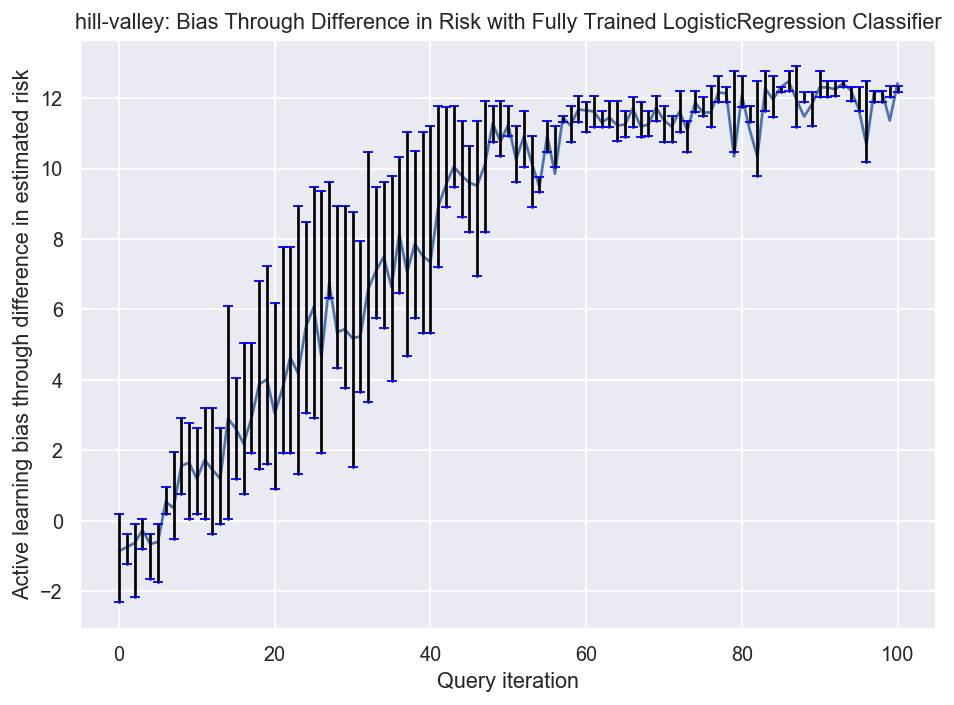

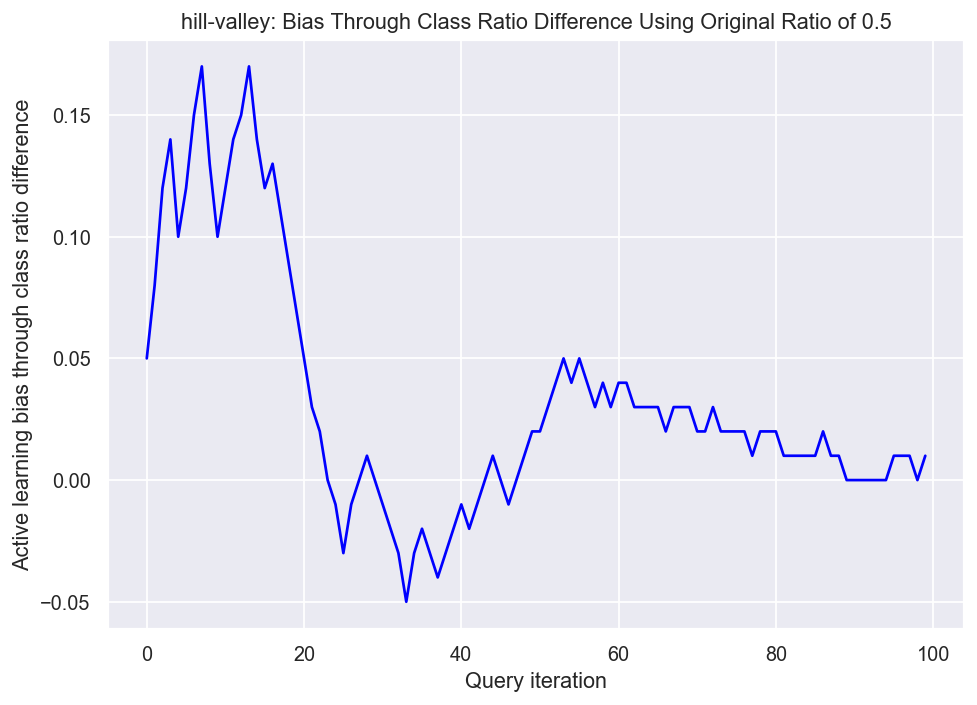

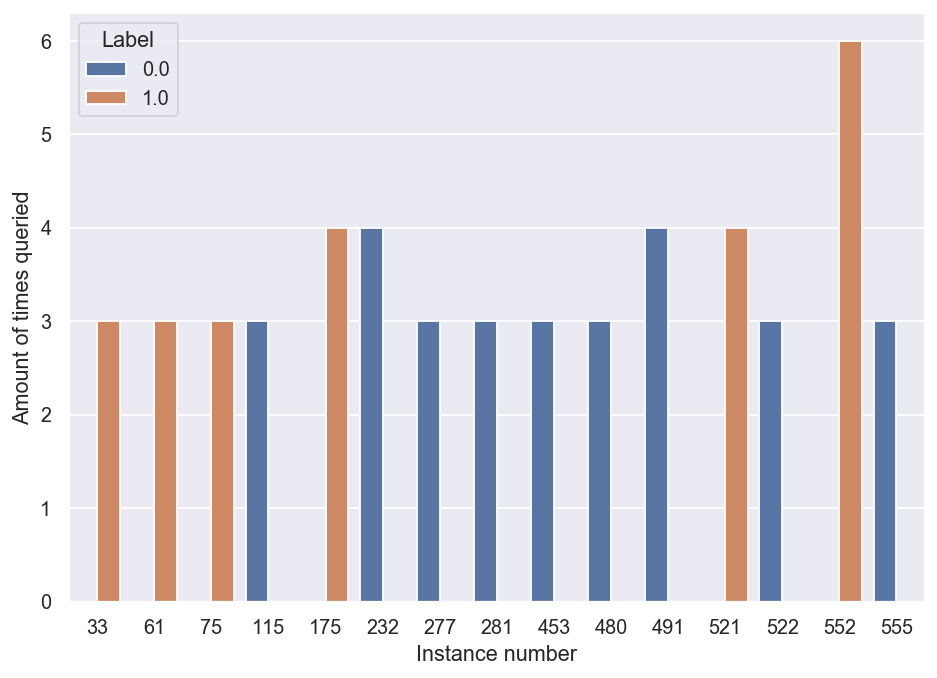

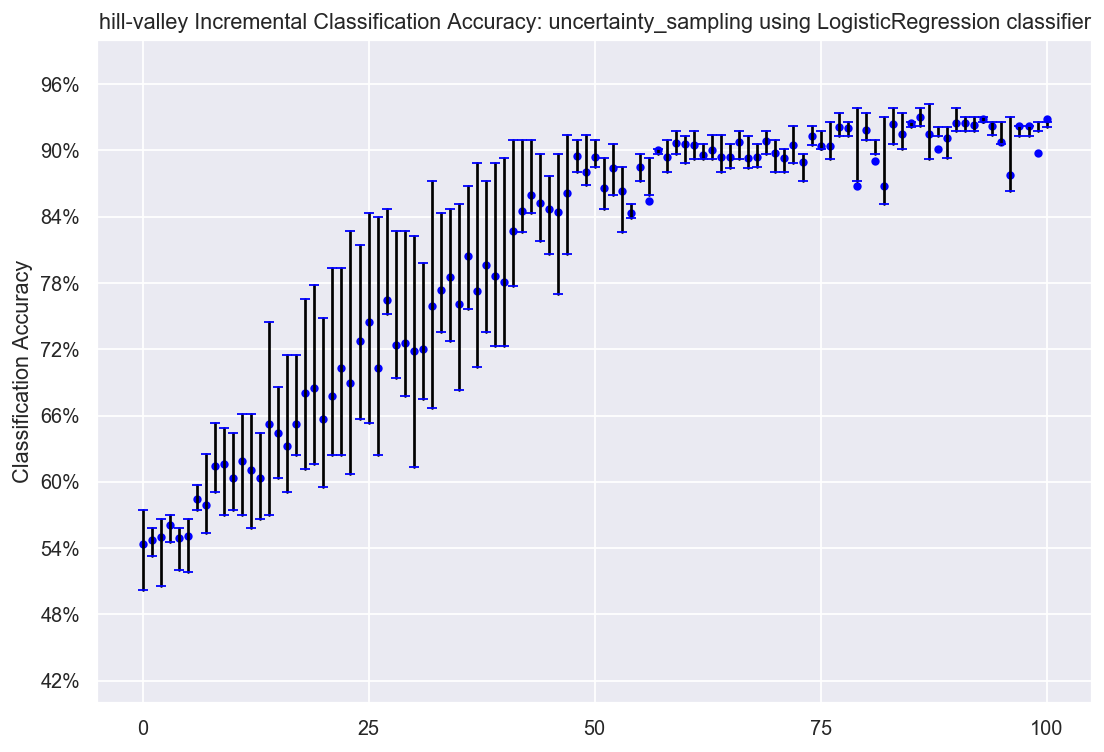

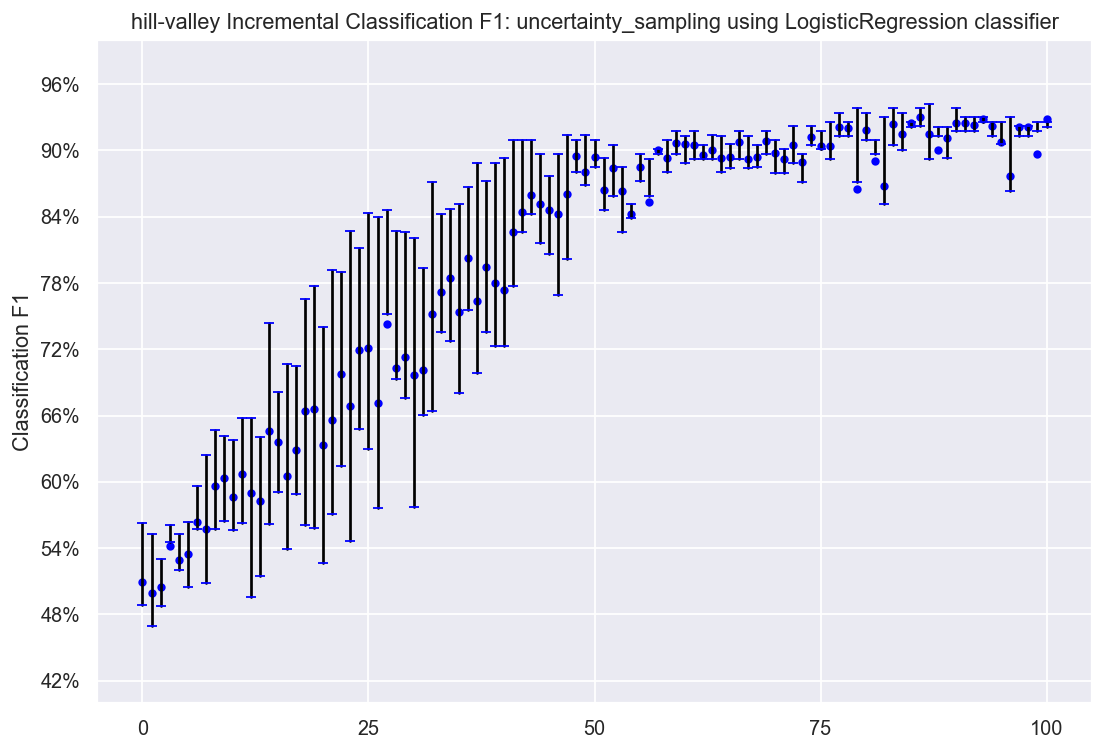

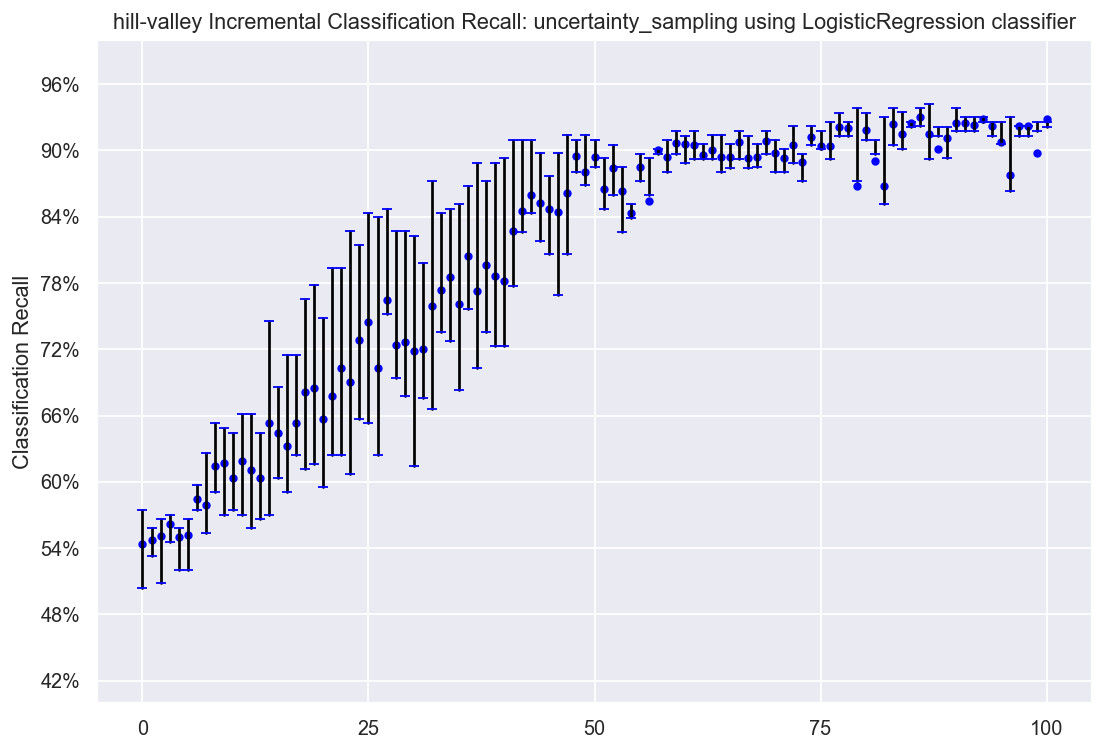

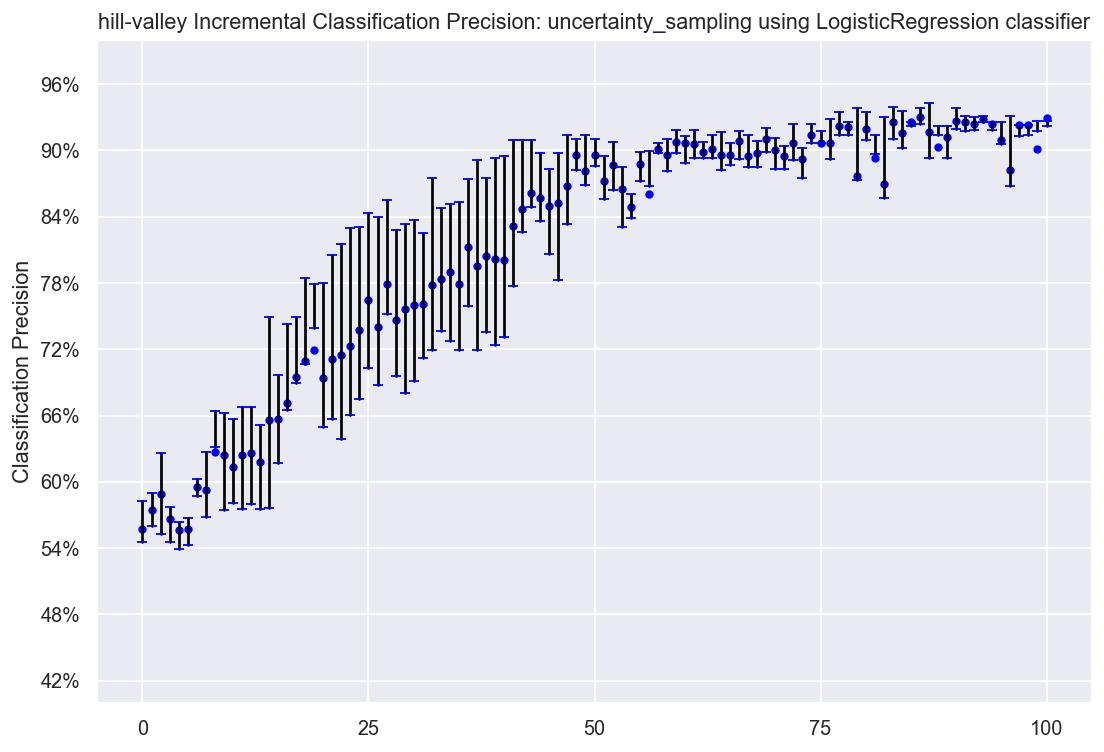

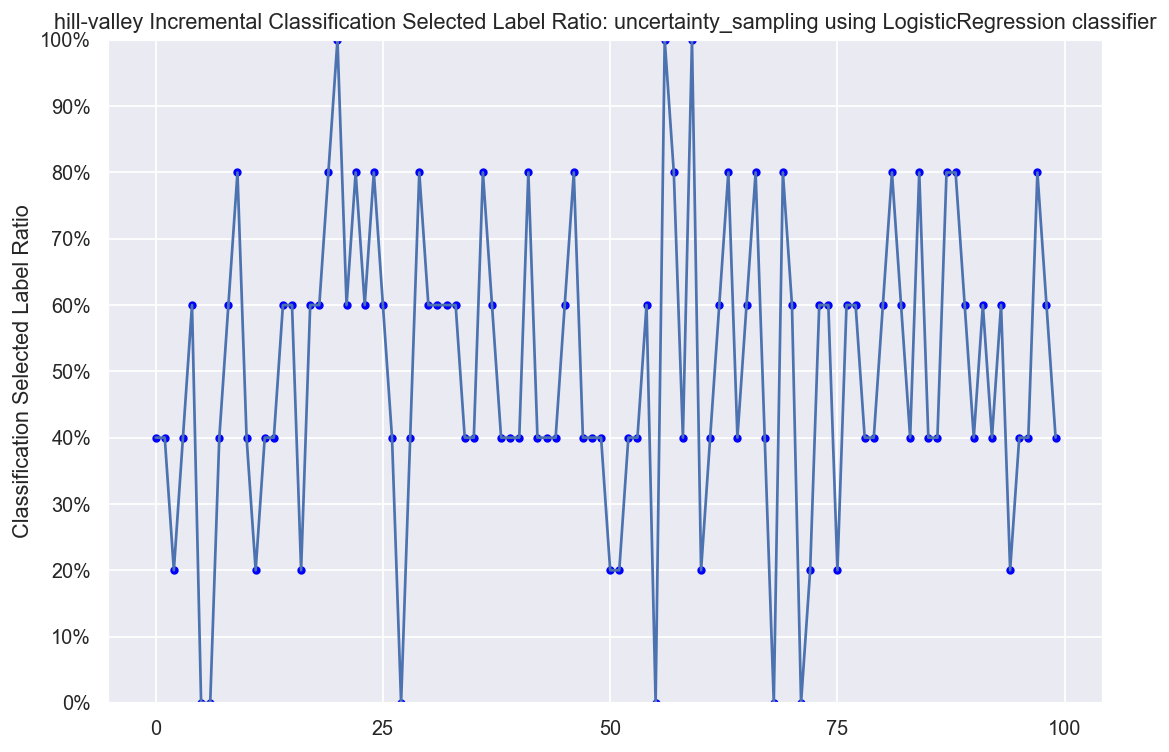

ALC is:  25.234590304994136


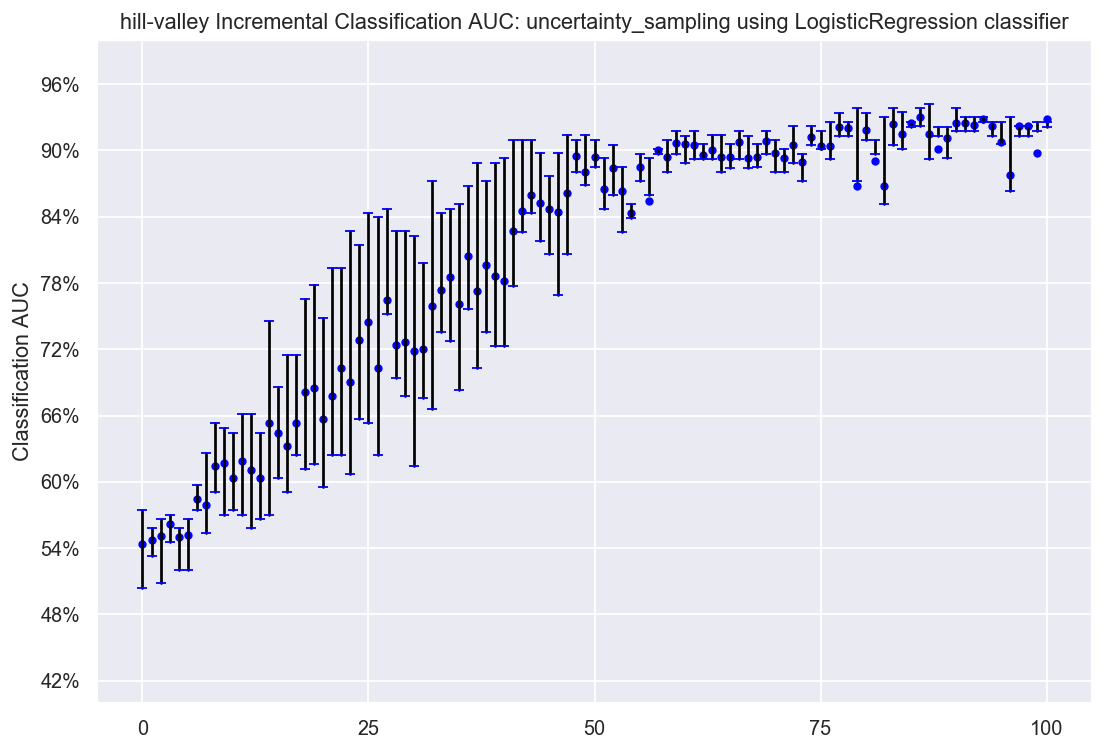

Evaluating on Balanced class ratio data using uncertainty_sampling and the LogisticRegression classifier:


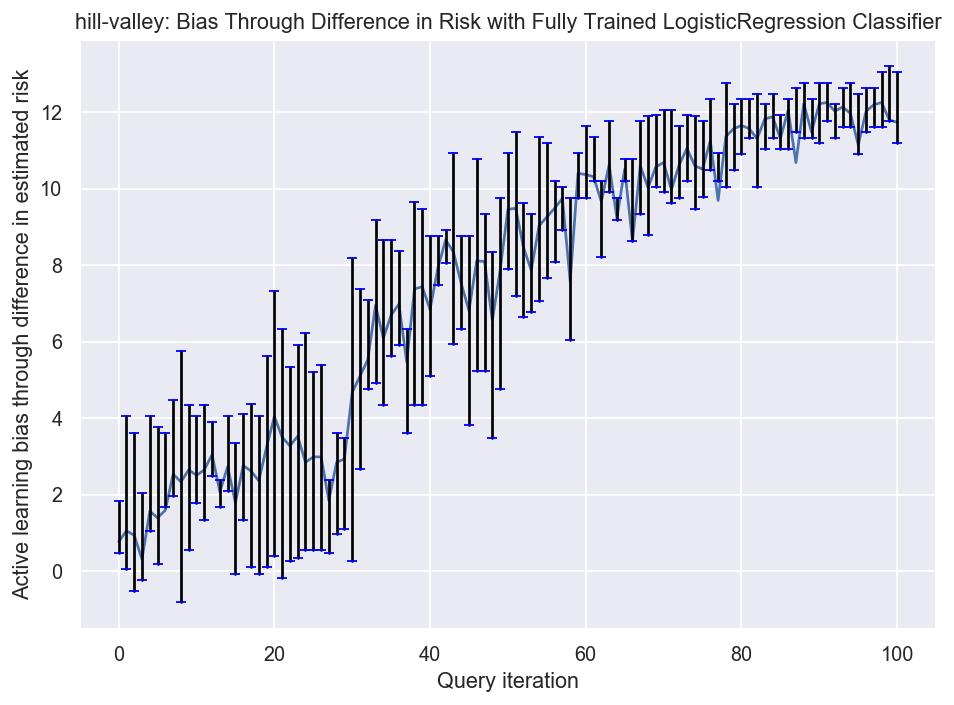

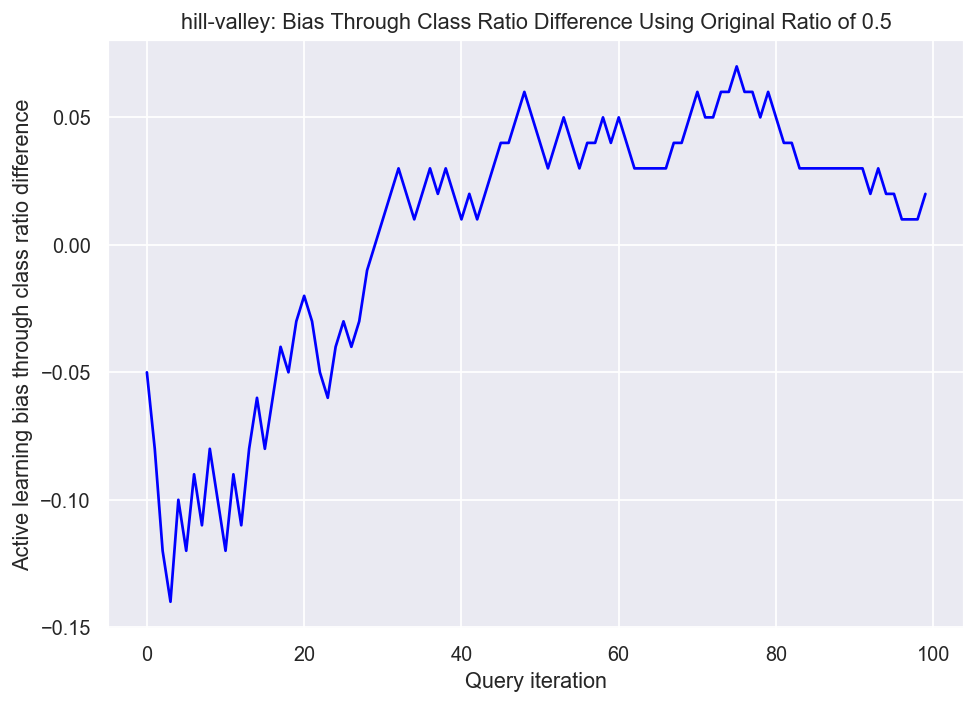

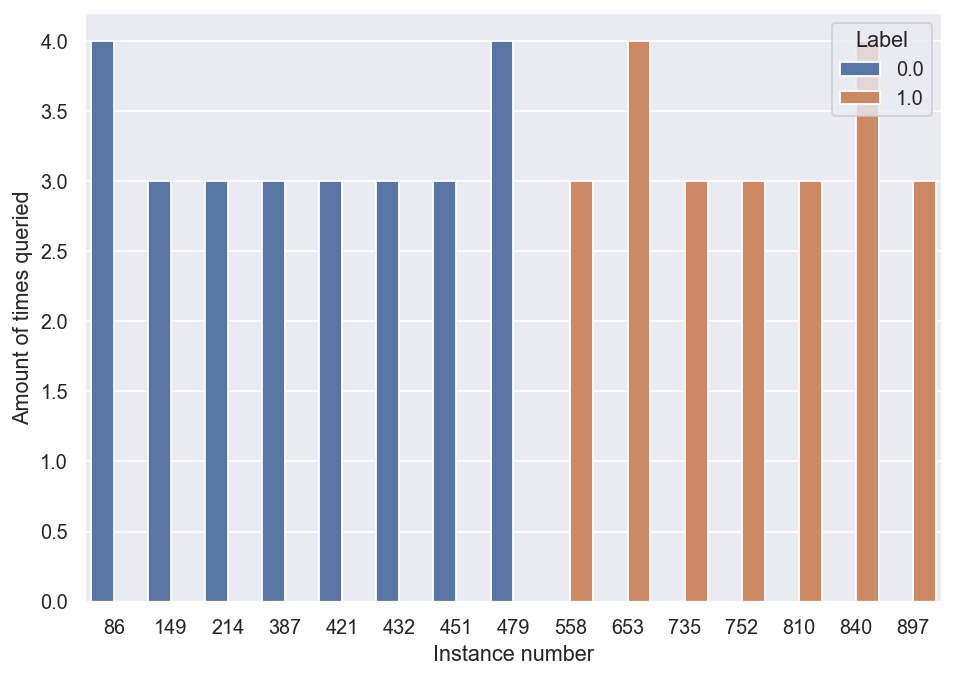

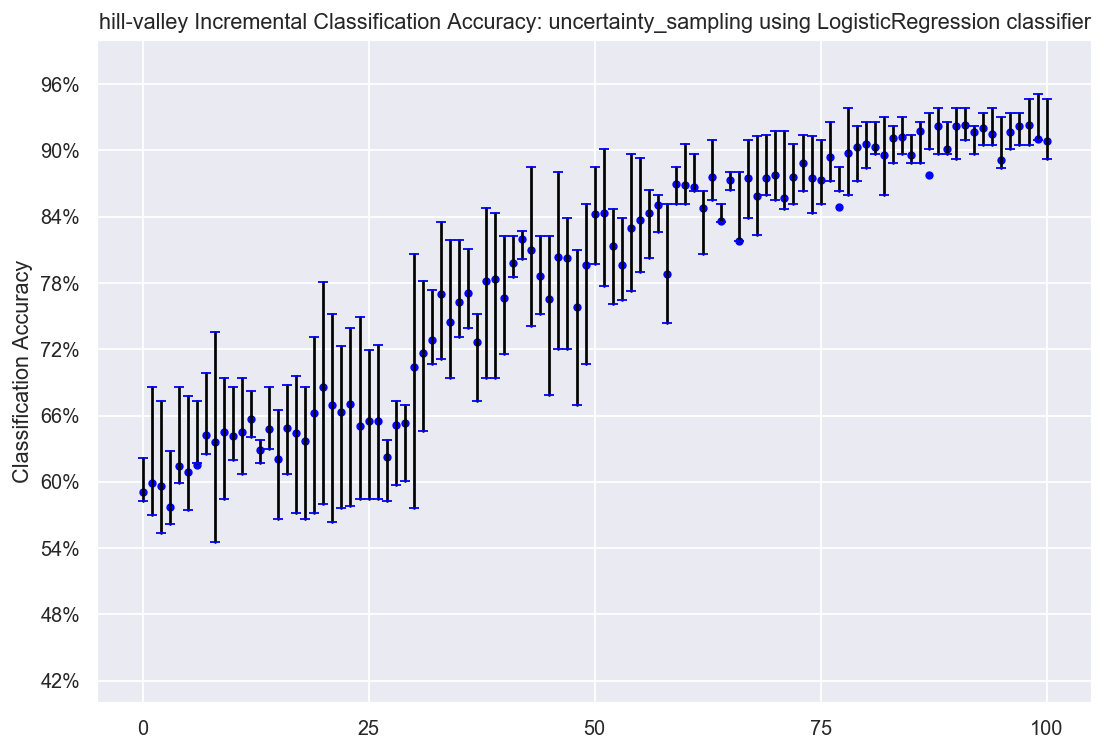

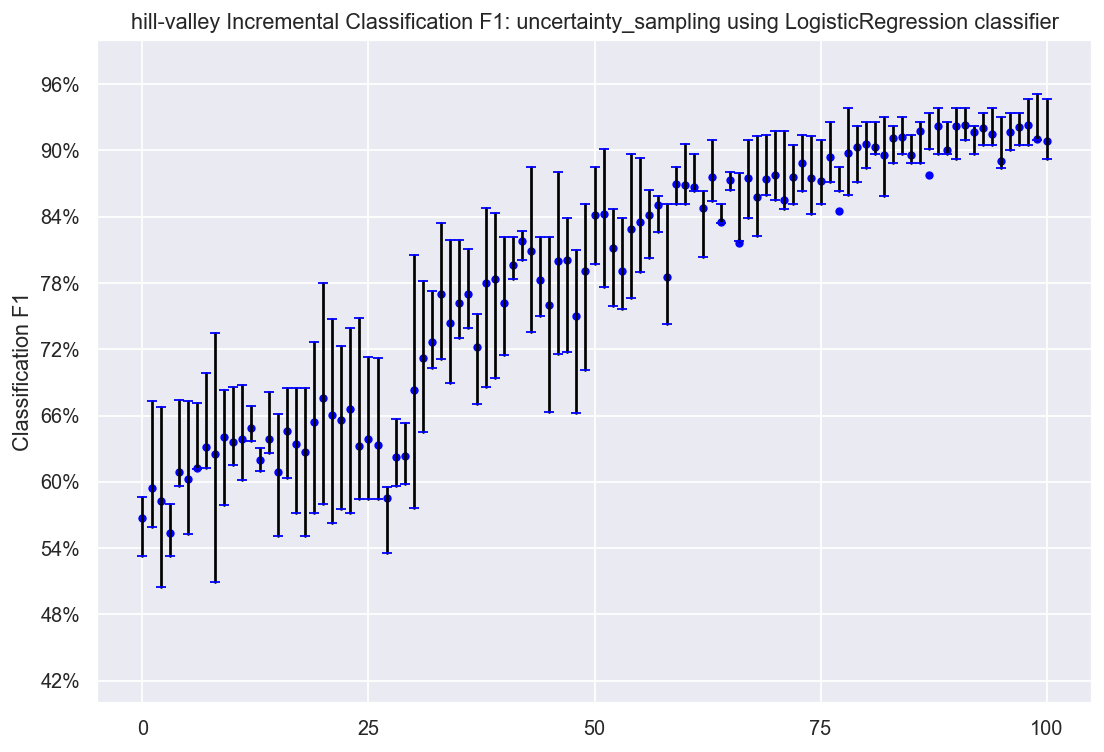

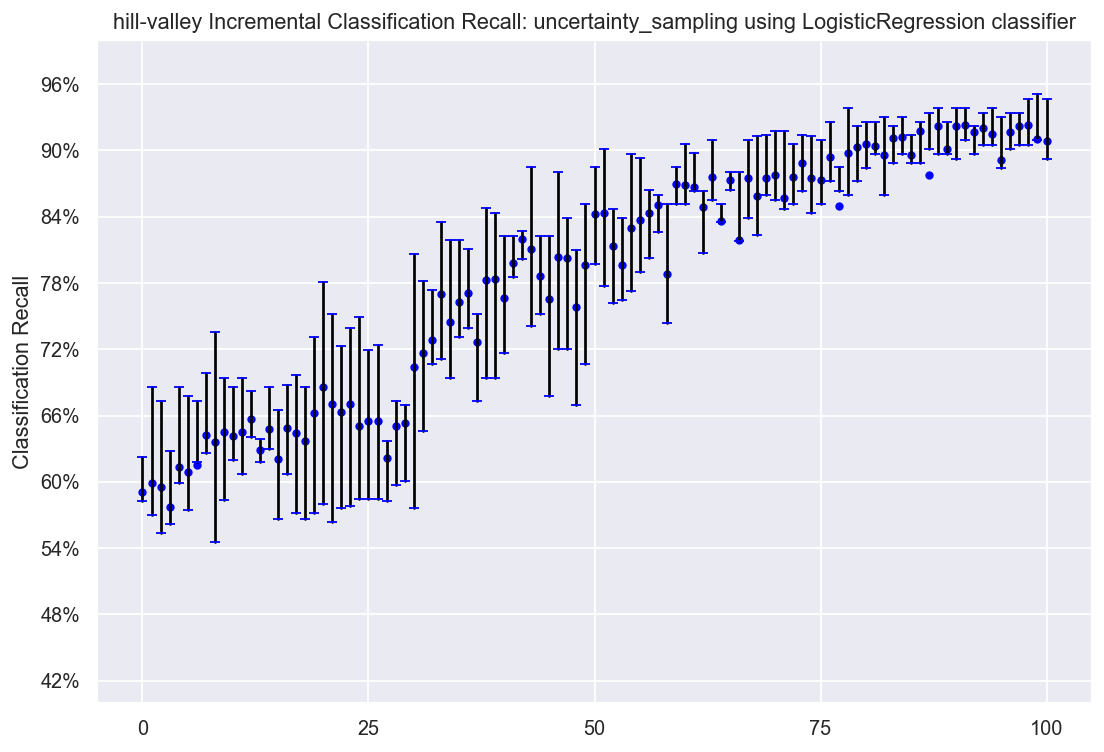

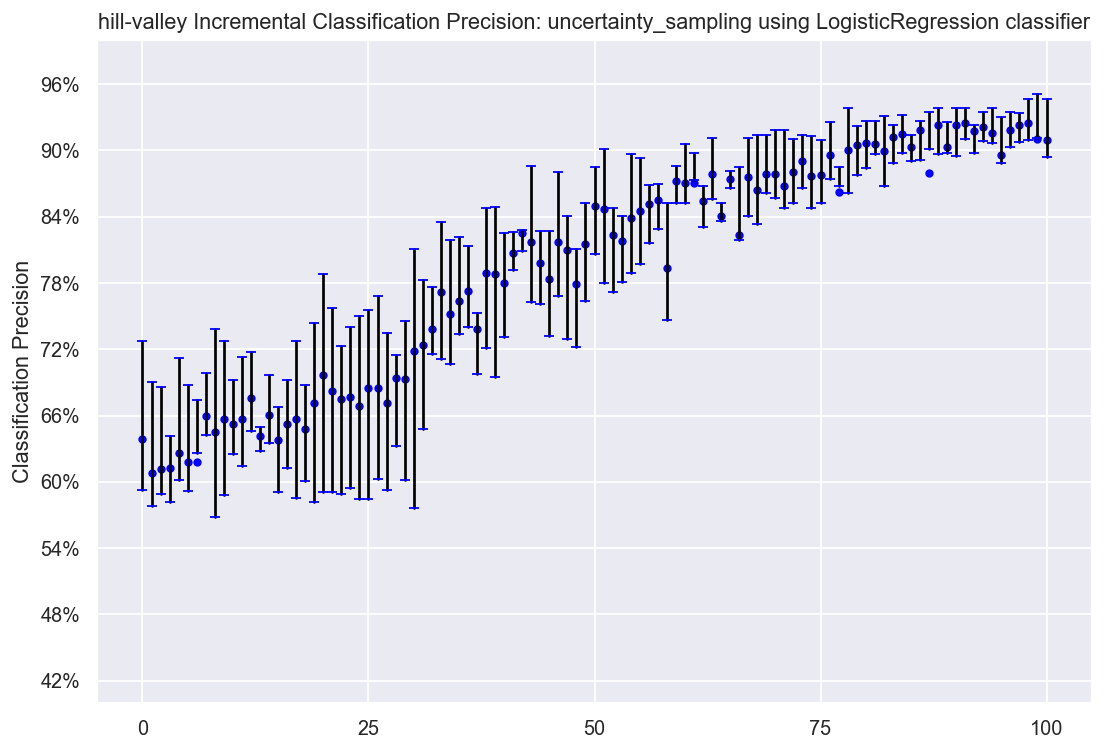

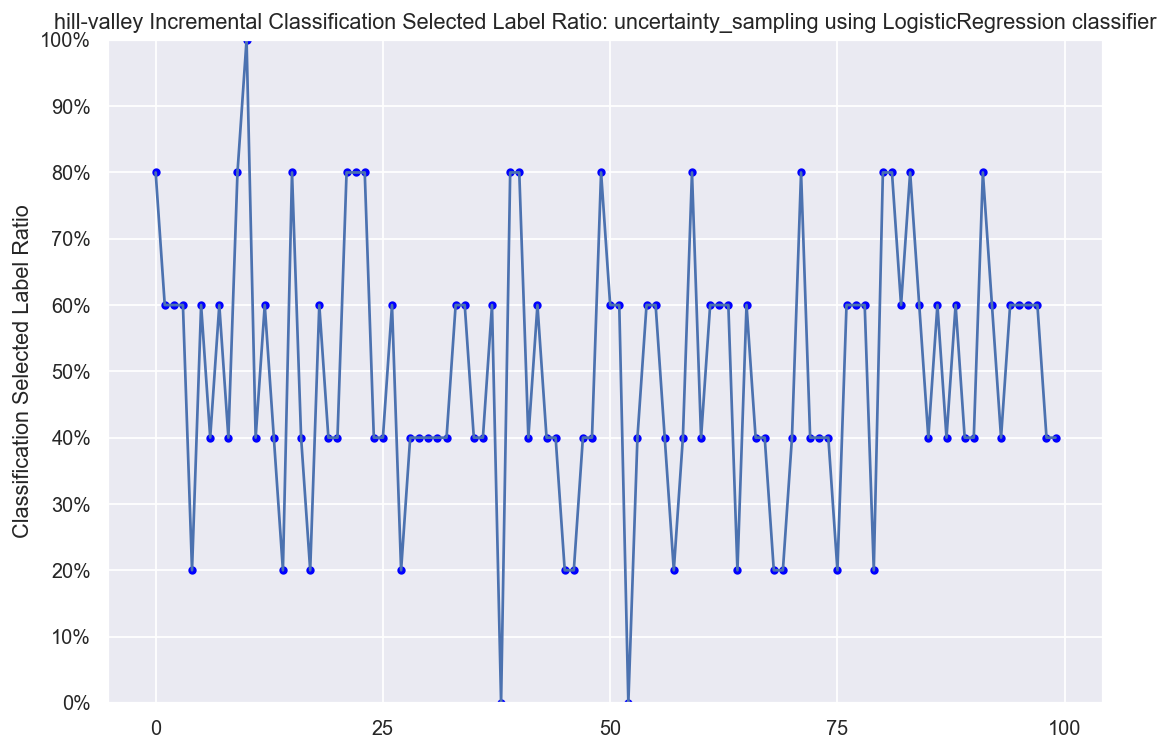

ALC is:  27.267268273178377


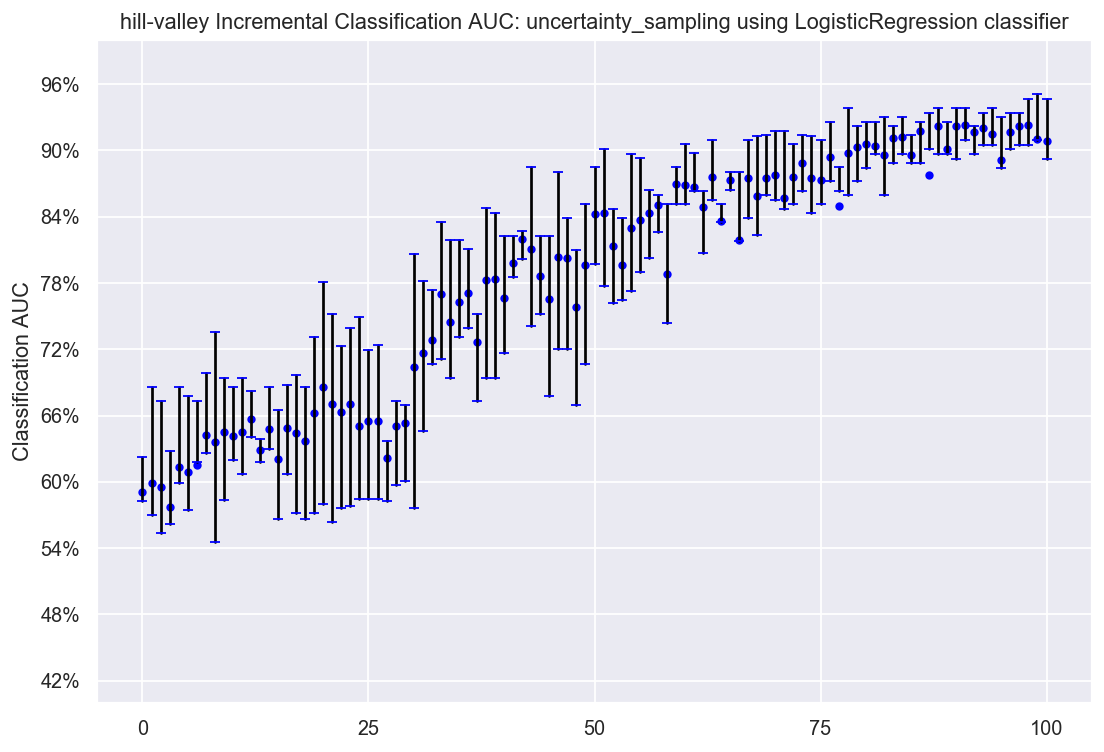

Evaluating on 75-25 class ratio data using uncertainty_sampling and the LogisticRegression classifier:


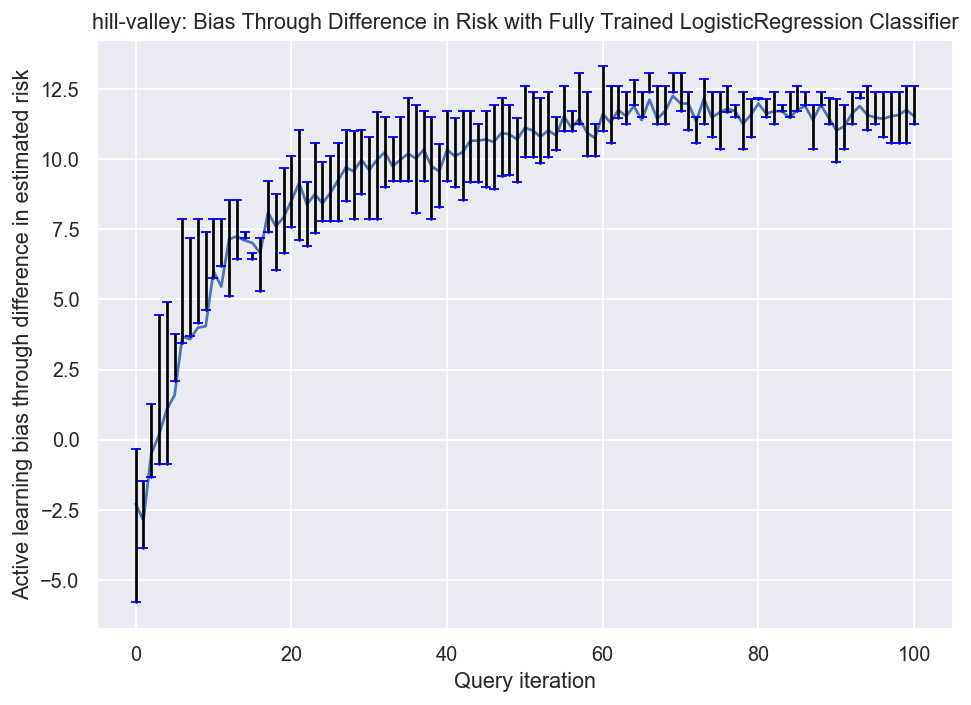

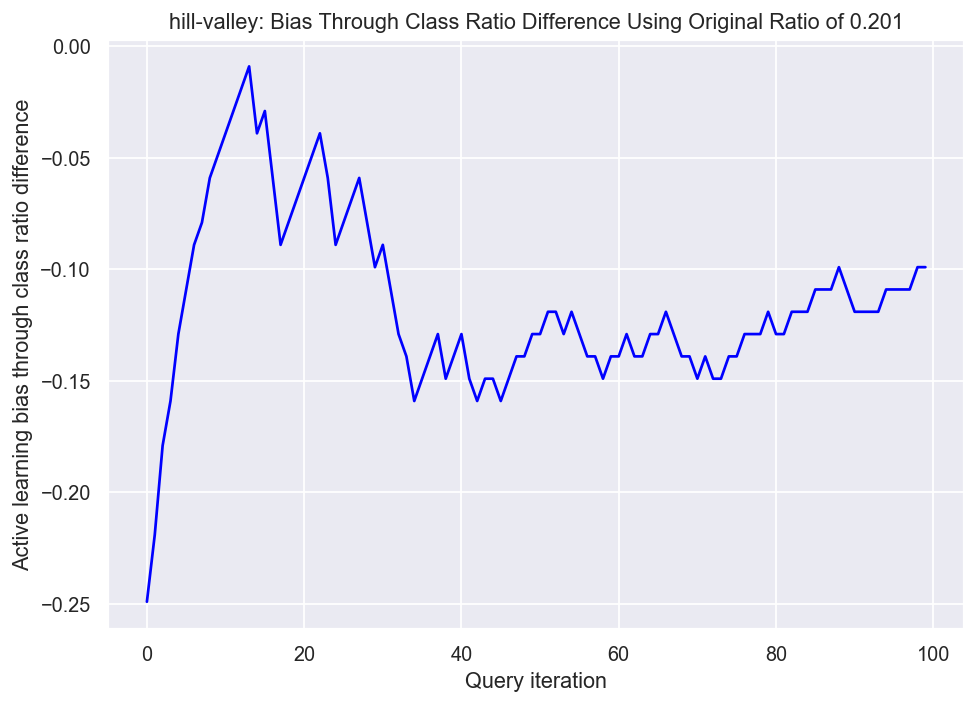

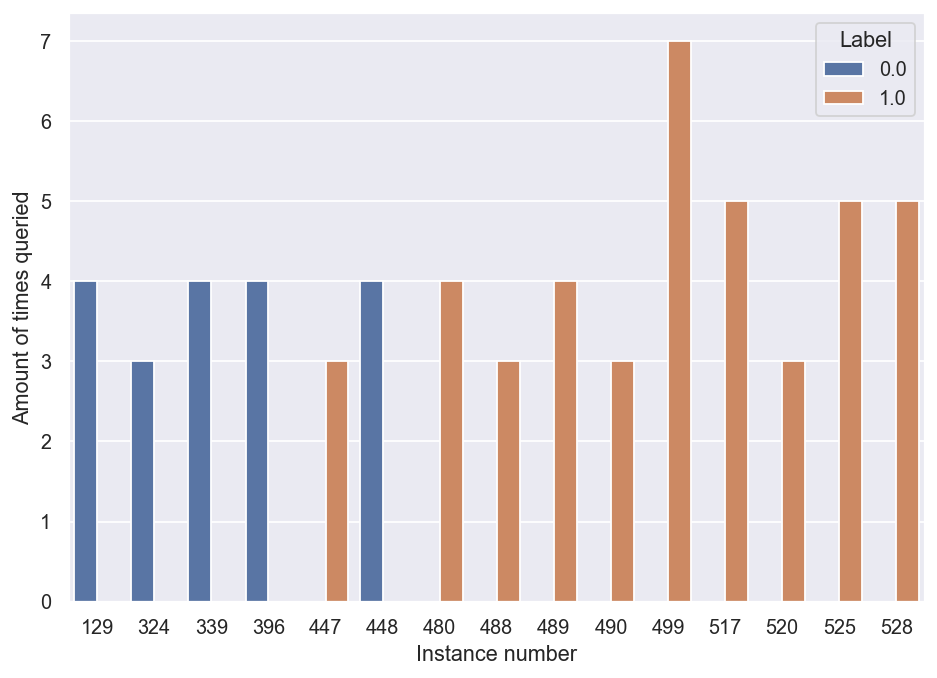

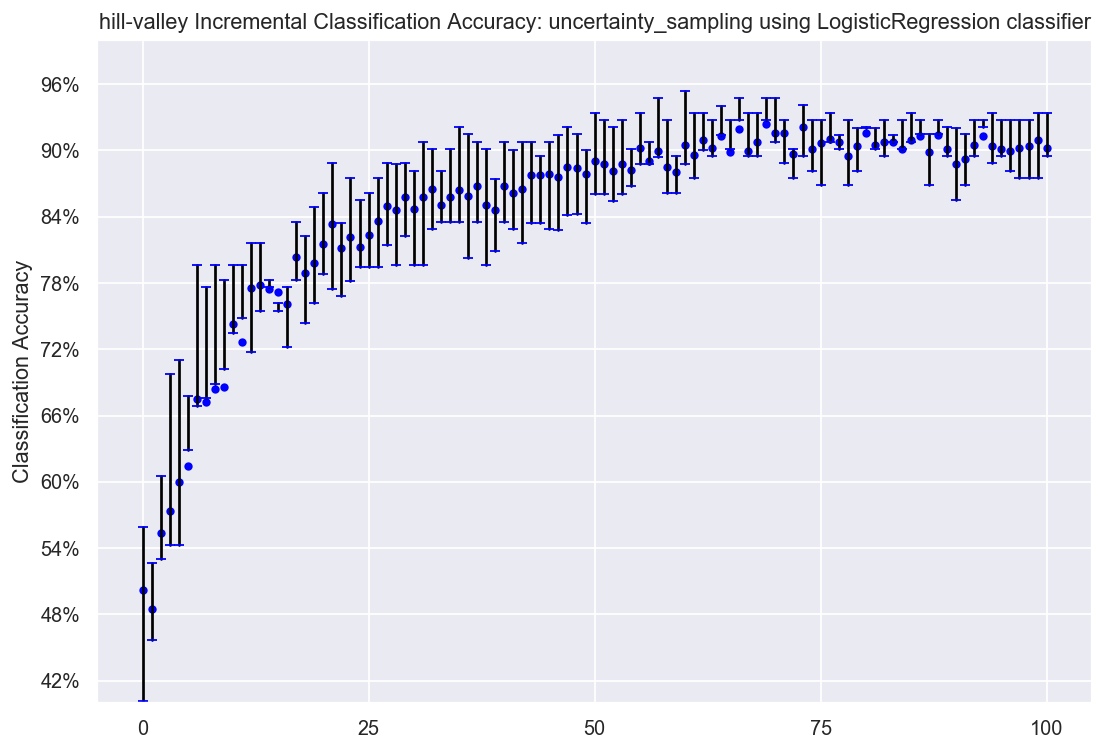

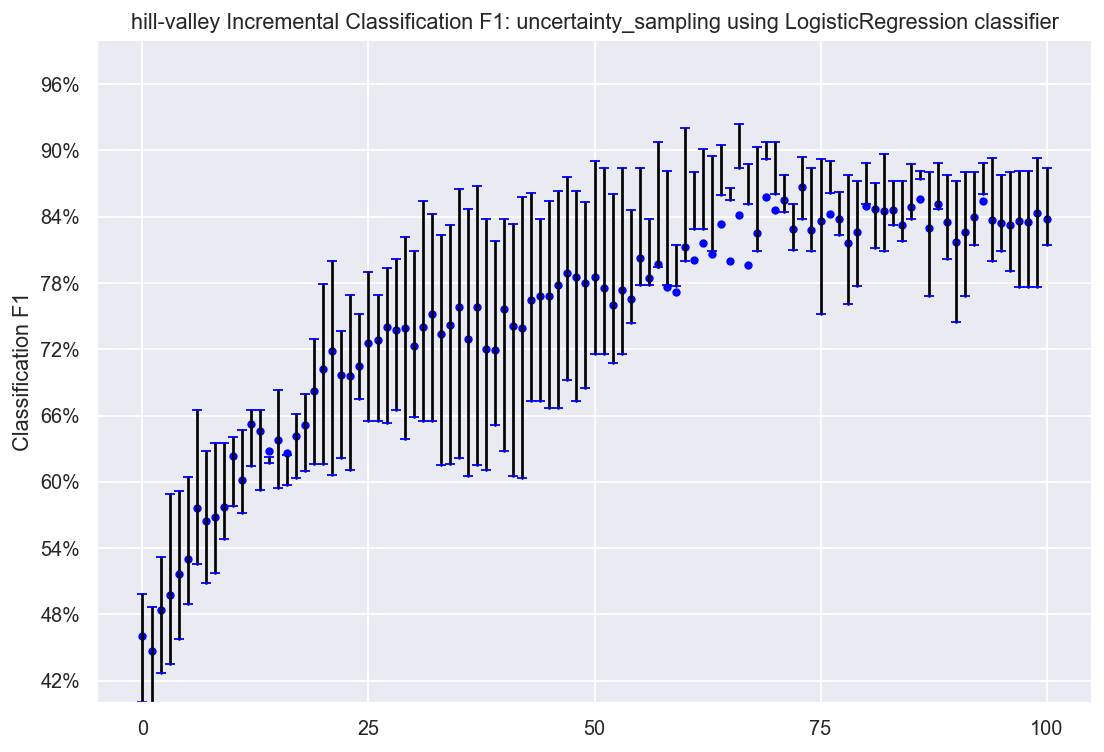

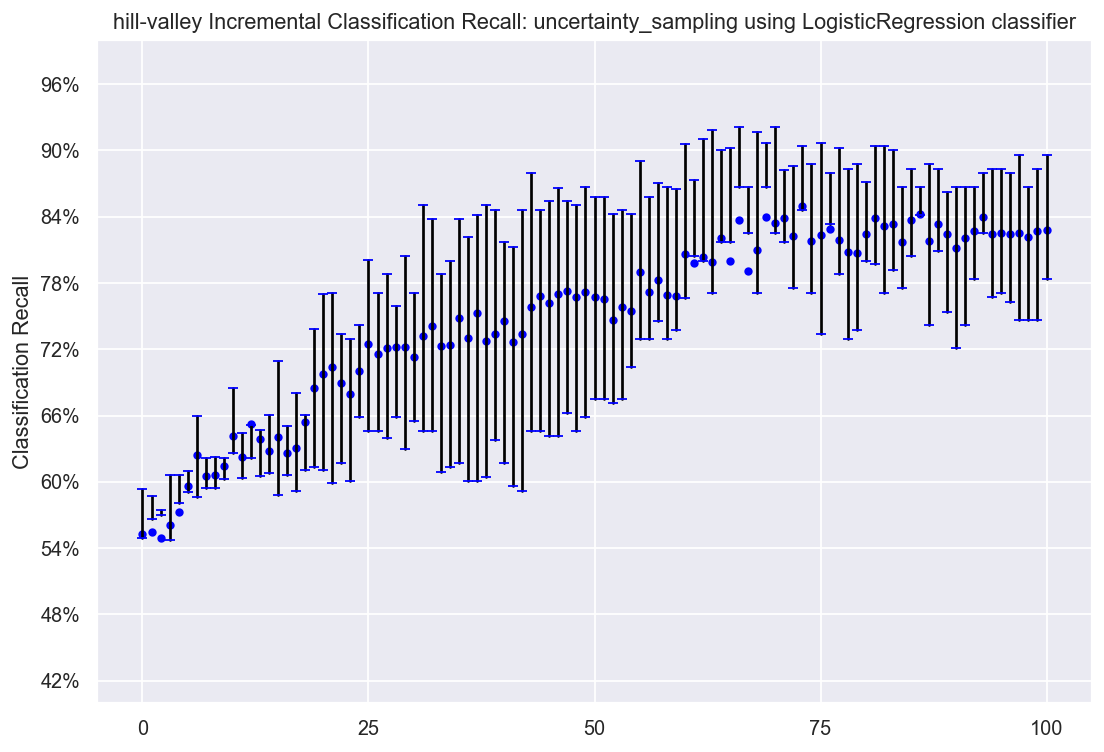

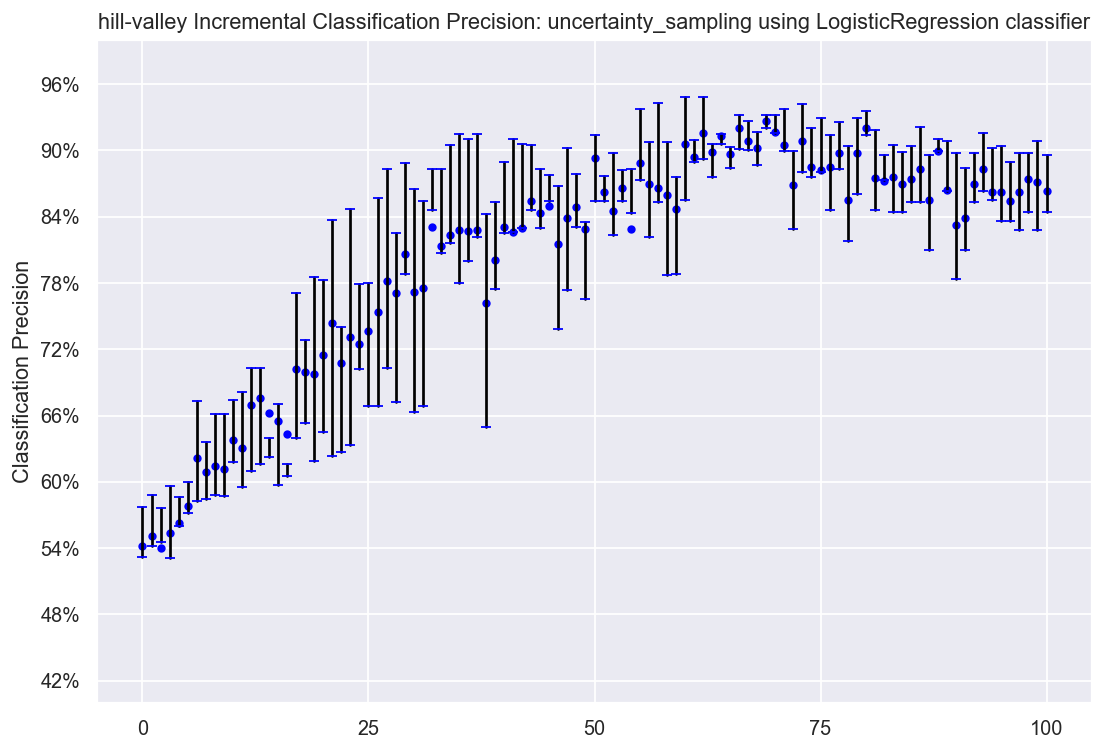

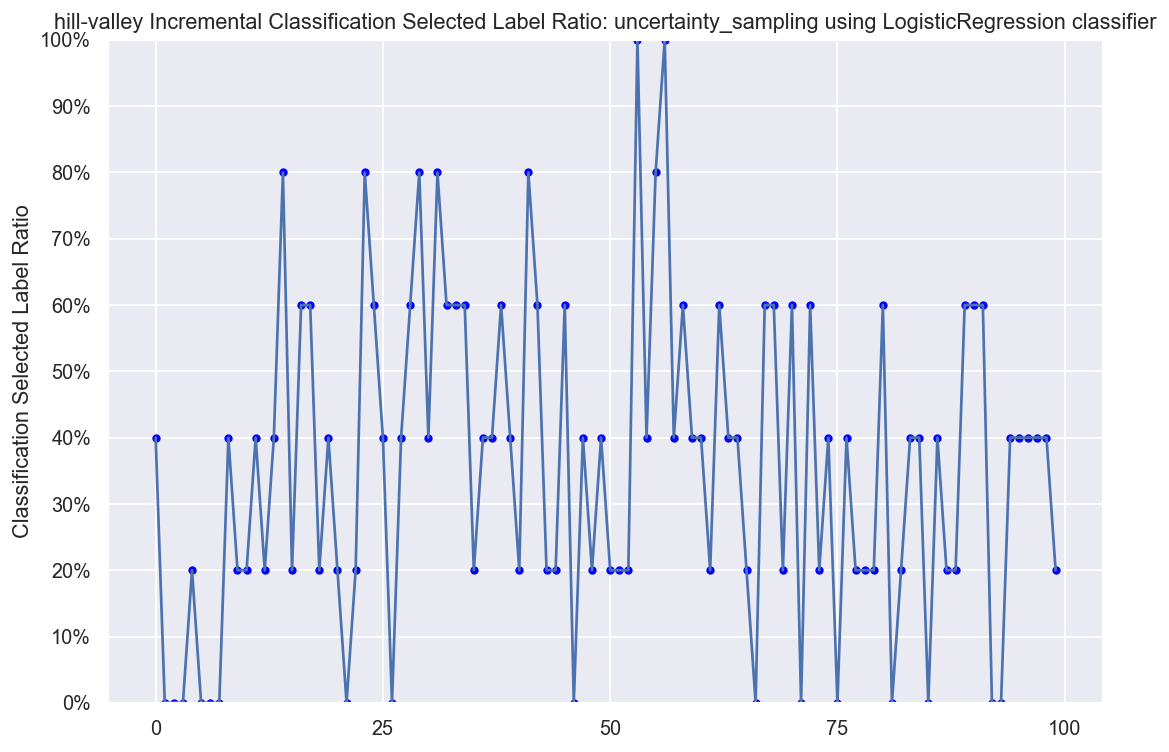

ALC is:  23.820714446833684


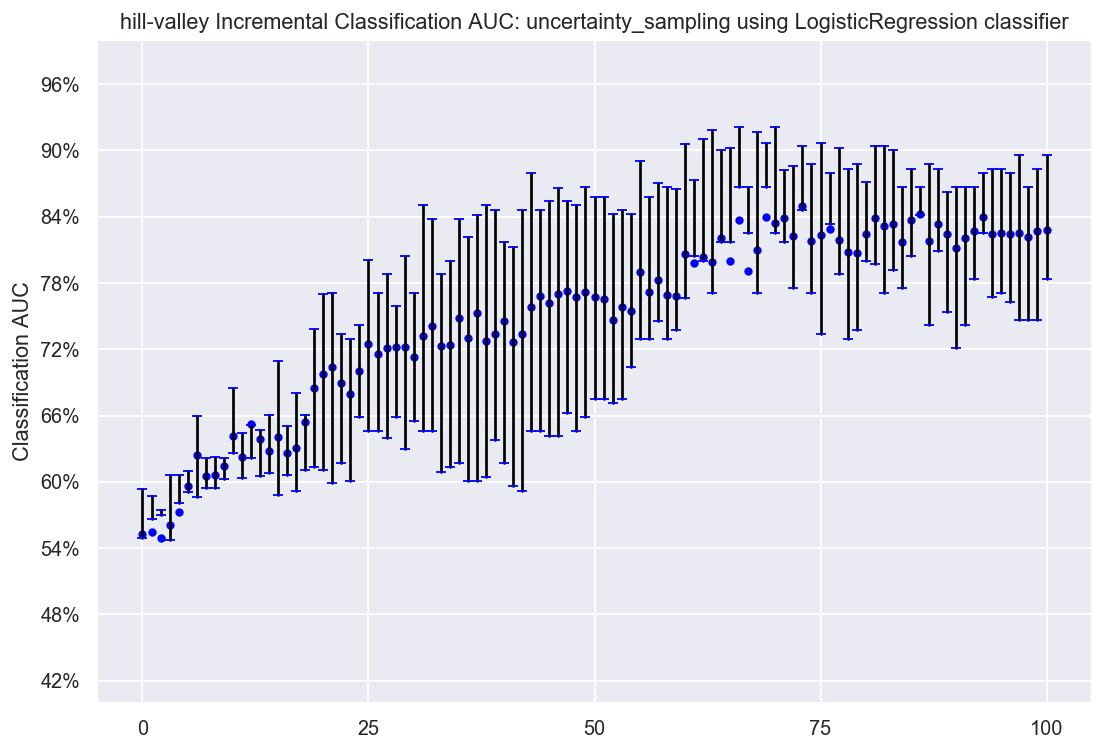

Evaluating on 95-5 class ratio data using uncertainty_sampling and the LogisticRegression classifier:


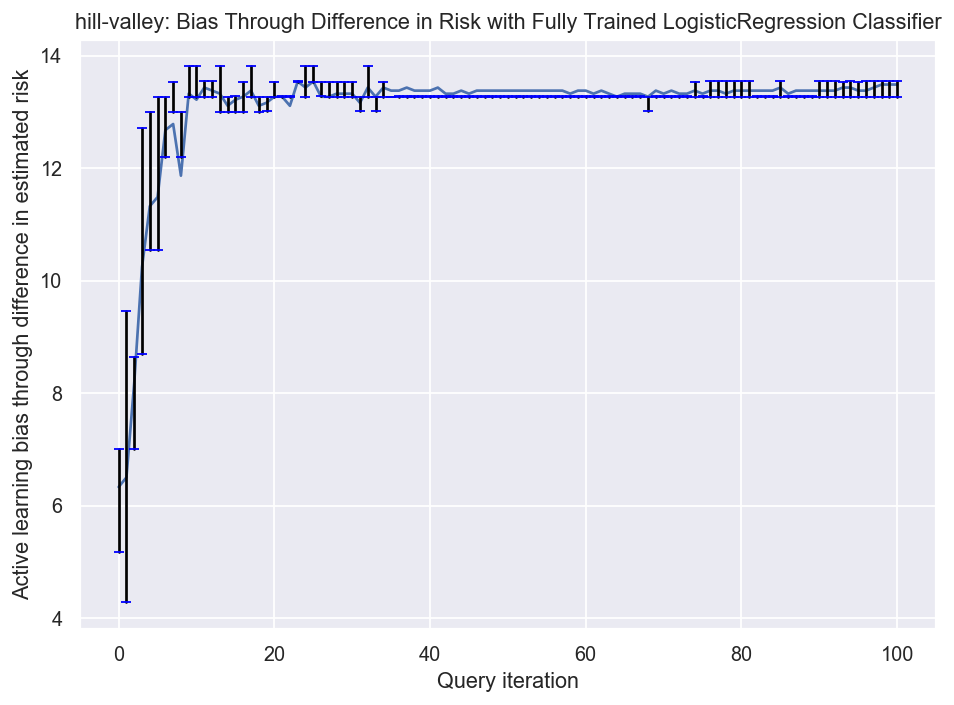

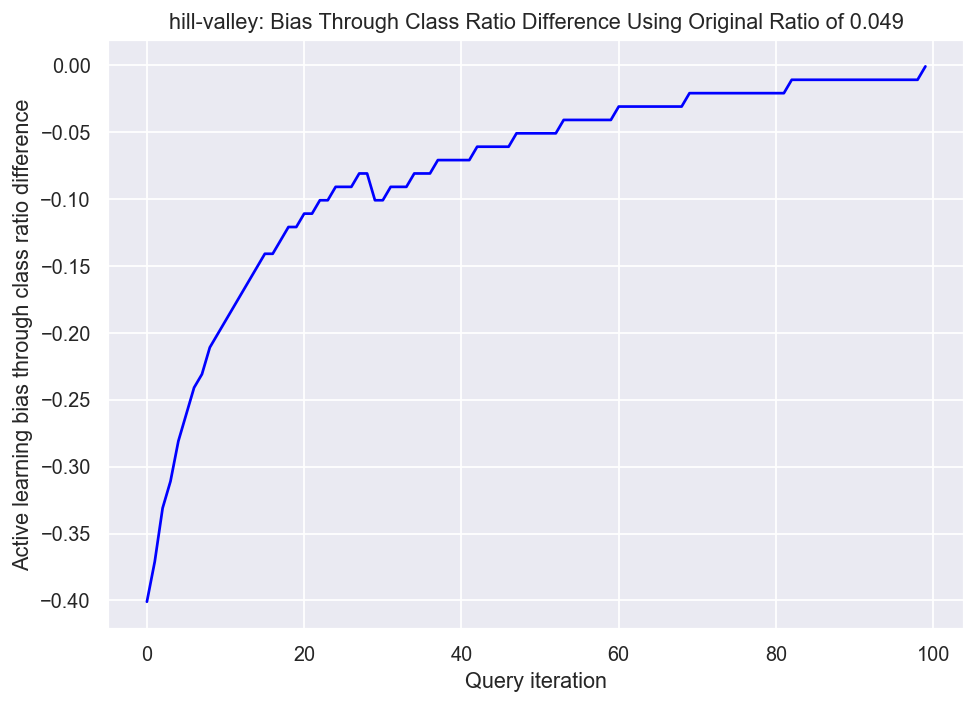

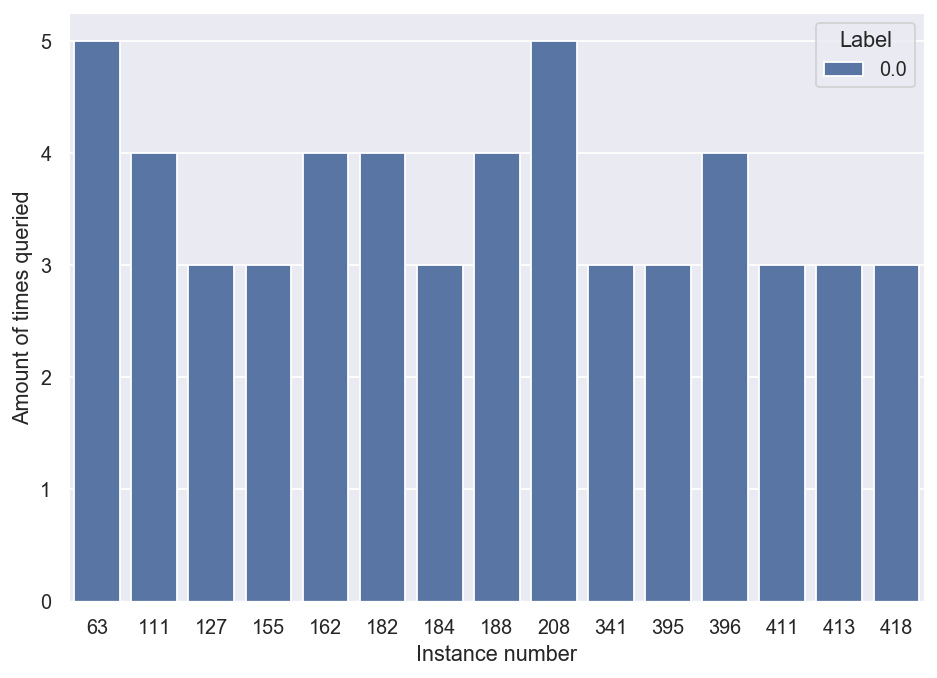

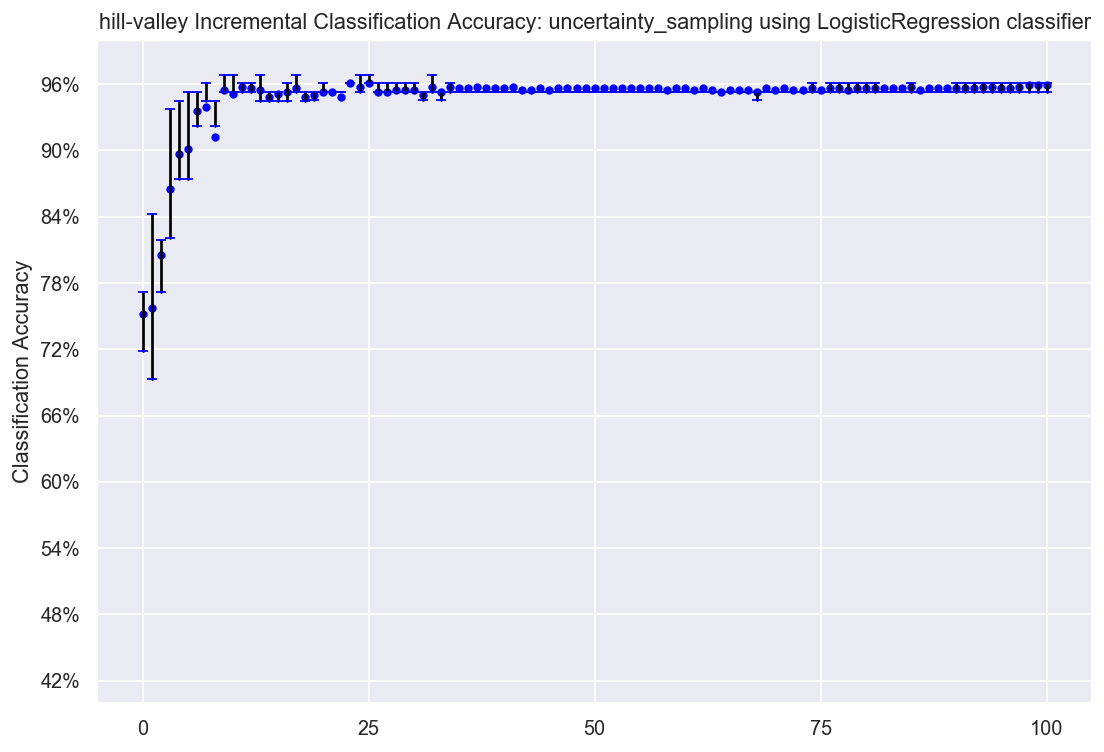

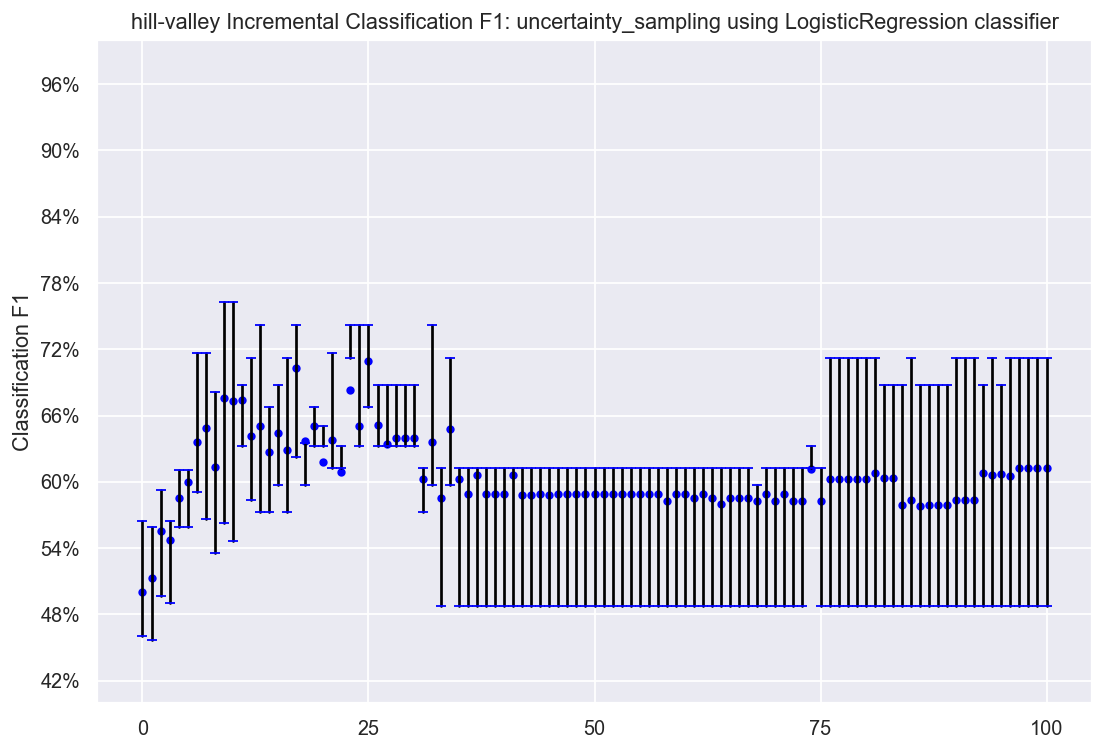

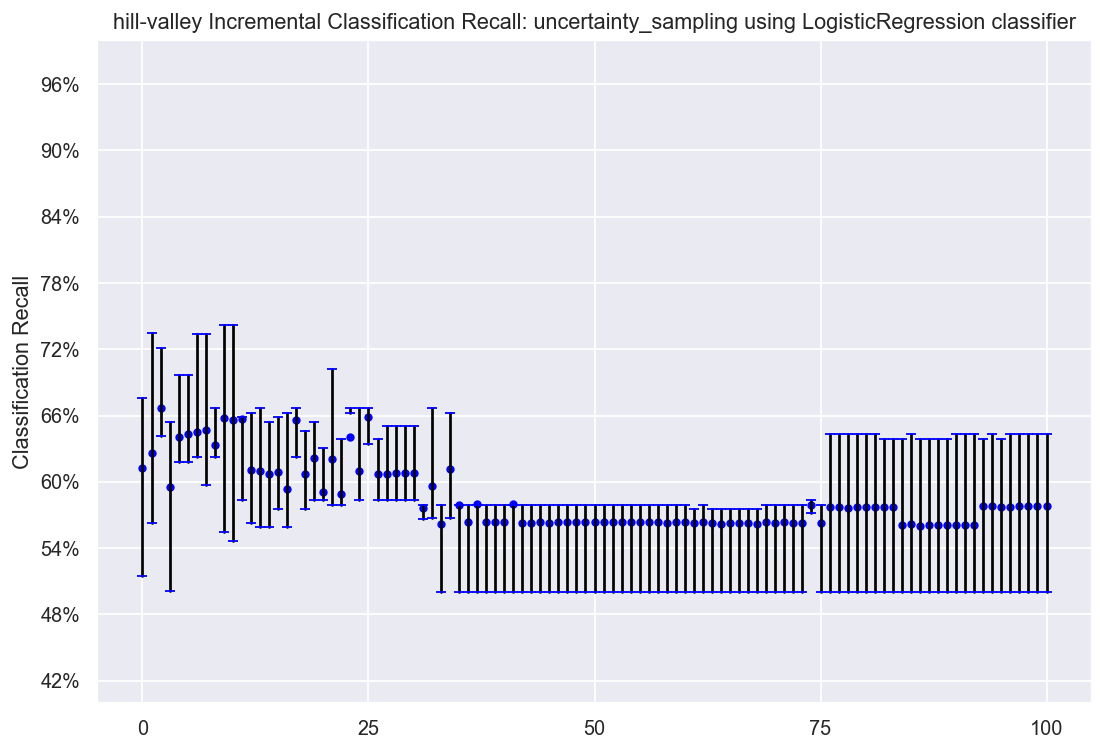

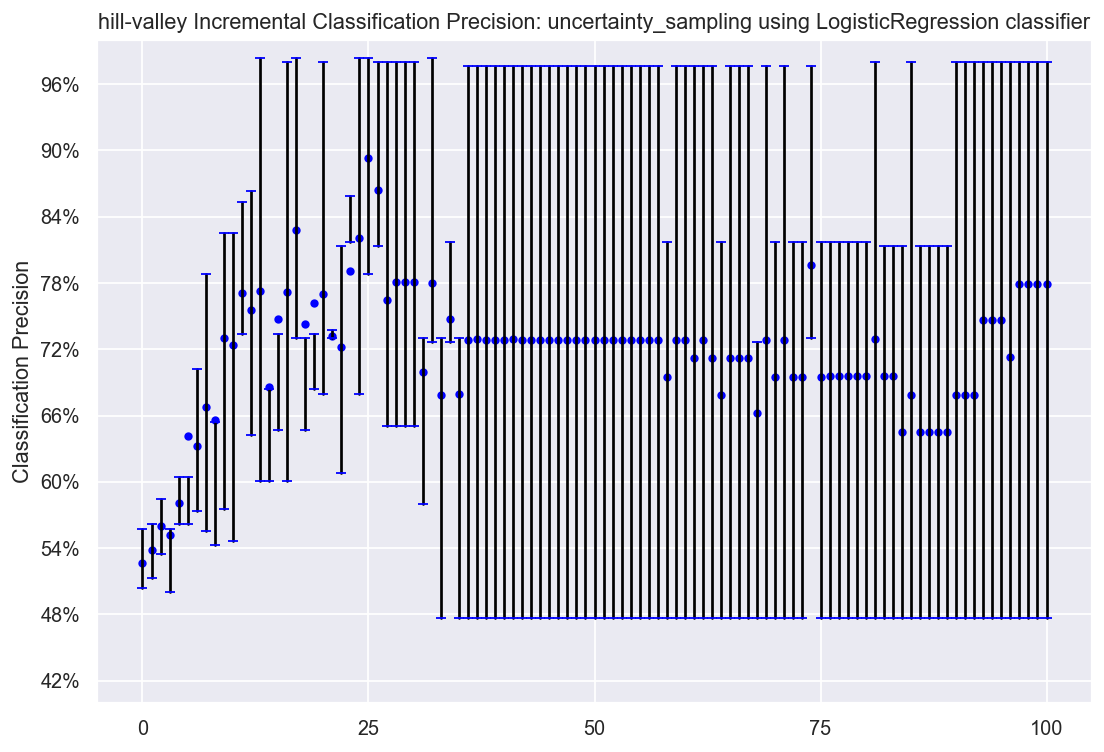

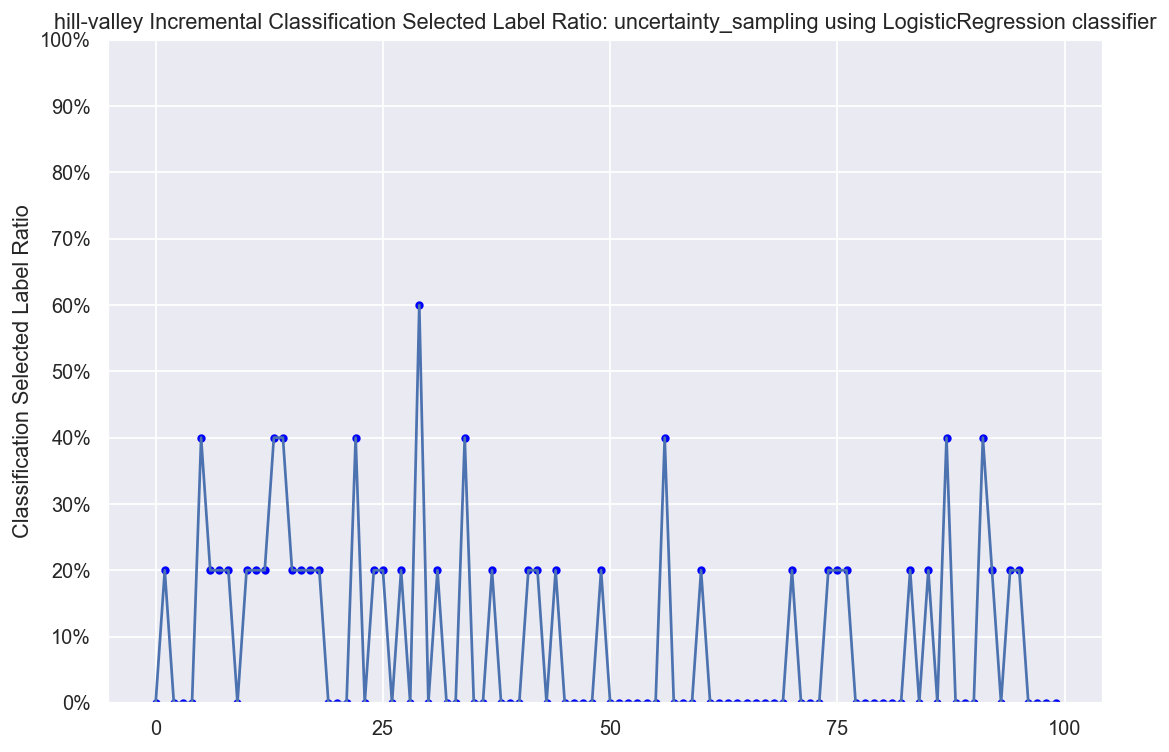

ALC is:  20.900555063600116


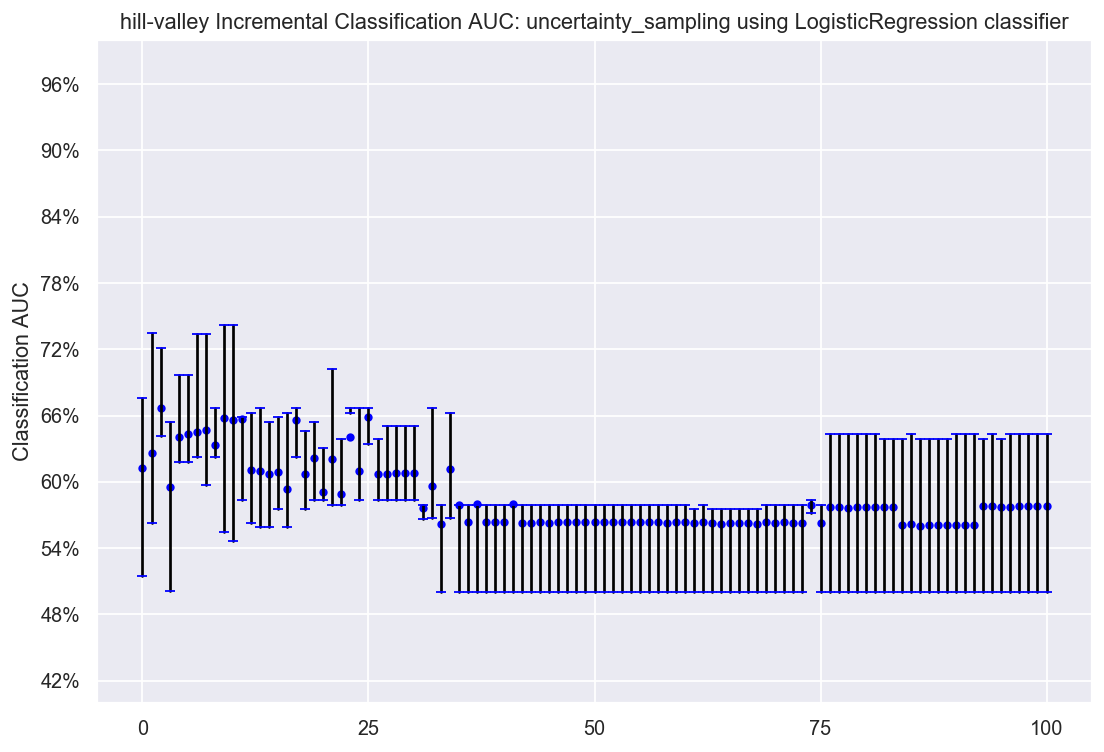

Running experiments on ringnorm
Counter({1: 3736, 0: 3664})
Counter({0: 3664, 1: 3664})
Counter({0: 3664, 1: 916})
Counter({0: 3664, 1: 184})
LogisticRegression: Fully trained classifier performance:
 - Accuracy:  0.7581081081081081
 - F1:  0.757846271158795
 - Recall:  0.7582716149585049
 - Precision:  0.7595479993735808
 - AUC:  0.7582716149585049
 - Log Loss:  8.354761621292973
XGBClassifier: Fully trained classifier performance:
 - Accuracy:  0.9648648648648649
 - F1:  0.9648470330294971
 - Recall:  0.9647713105812685
 - Precision:  0.9654891542916229
 - AUC:  0.9647713105812685
 - Log Loss:  1.2135454664207148
RandomForestClassifier: Fully trained classifier performance:
 - Accuracy:  0.9459459459459459
 - F1:  0.9459185123530726
 - Recall:  0.9461574174780607
 - Precision:  0.9473556565446117
 - AUC:  0.9461574174780607
 - Log Loss:  1.8669706110449997
hill-valley
Evaluating on Original class ratio data using uncertainty_sampling and the LogisticRegression classifier:


<Figure size 432x288 with 0 Axes>

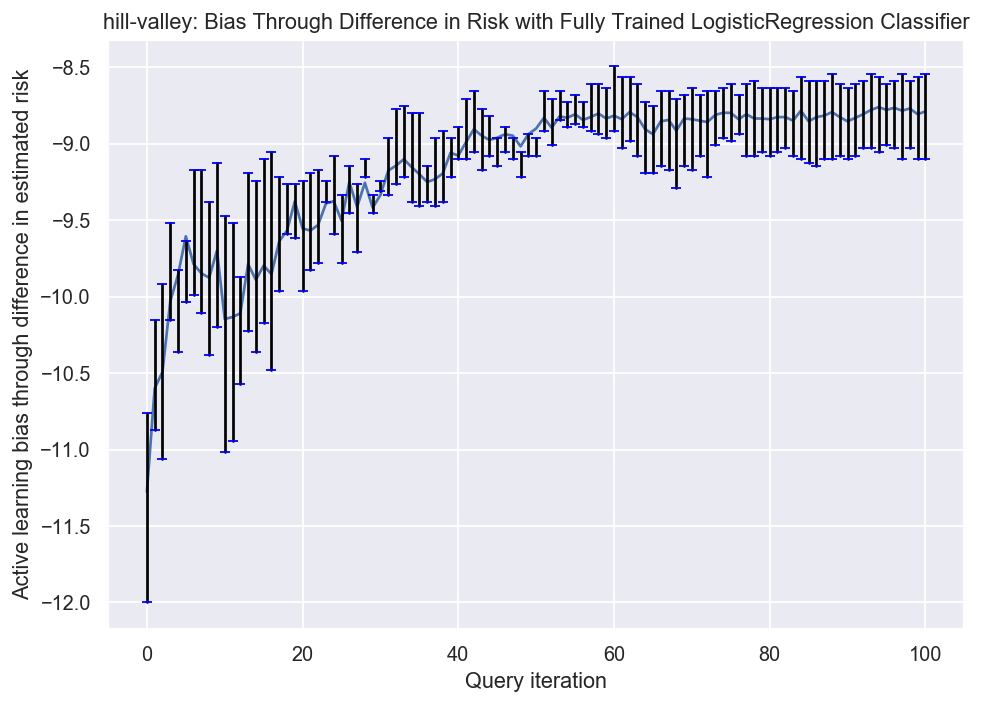

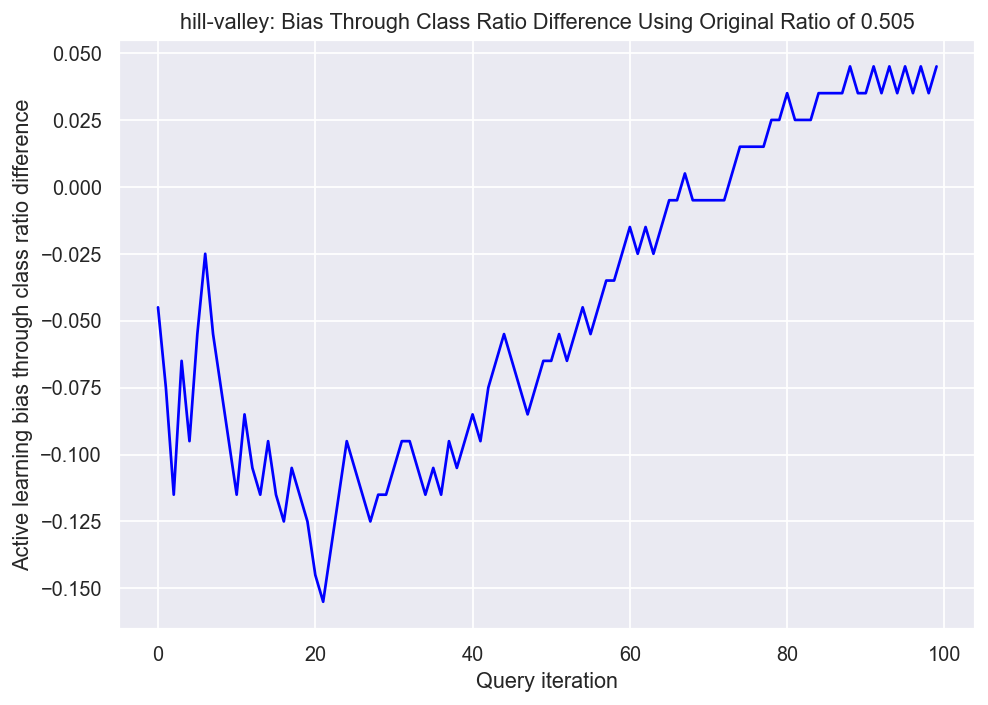

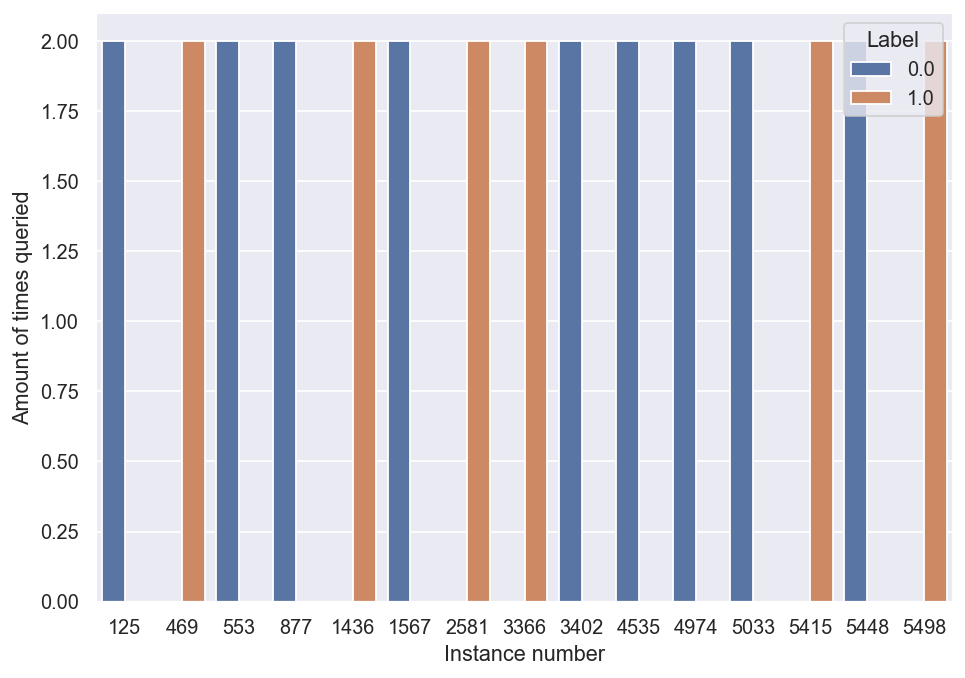

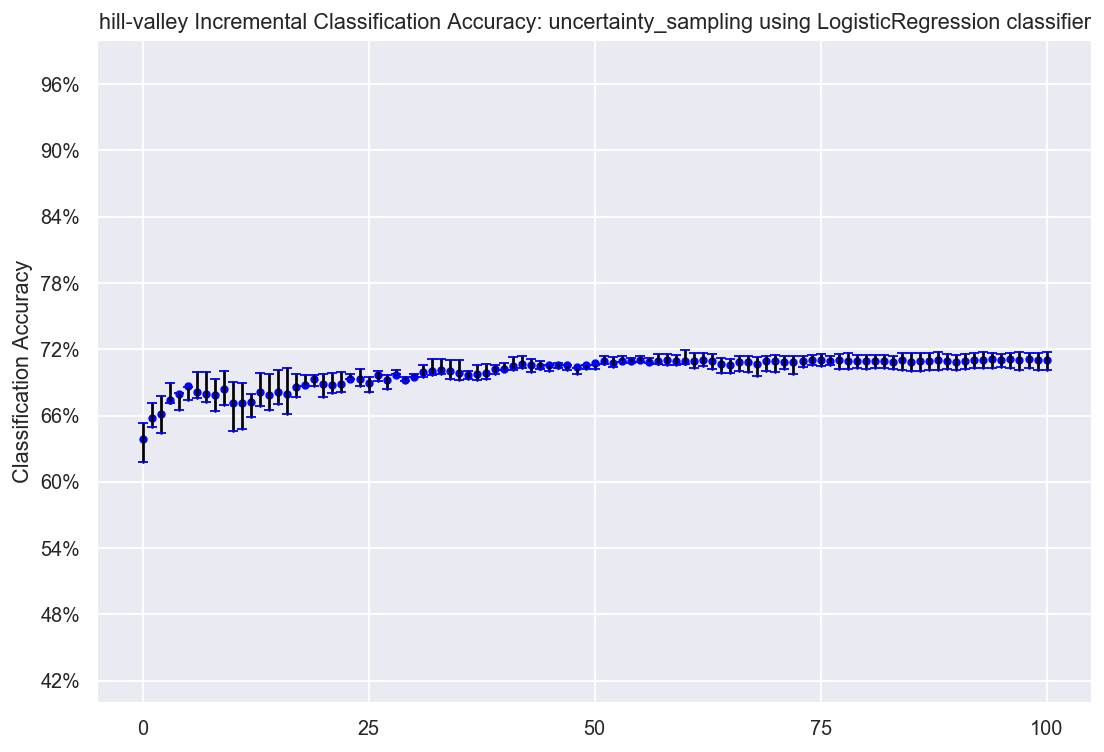

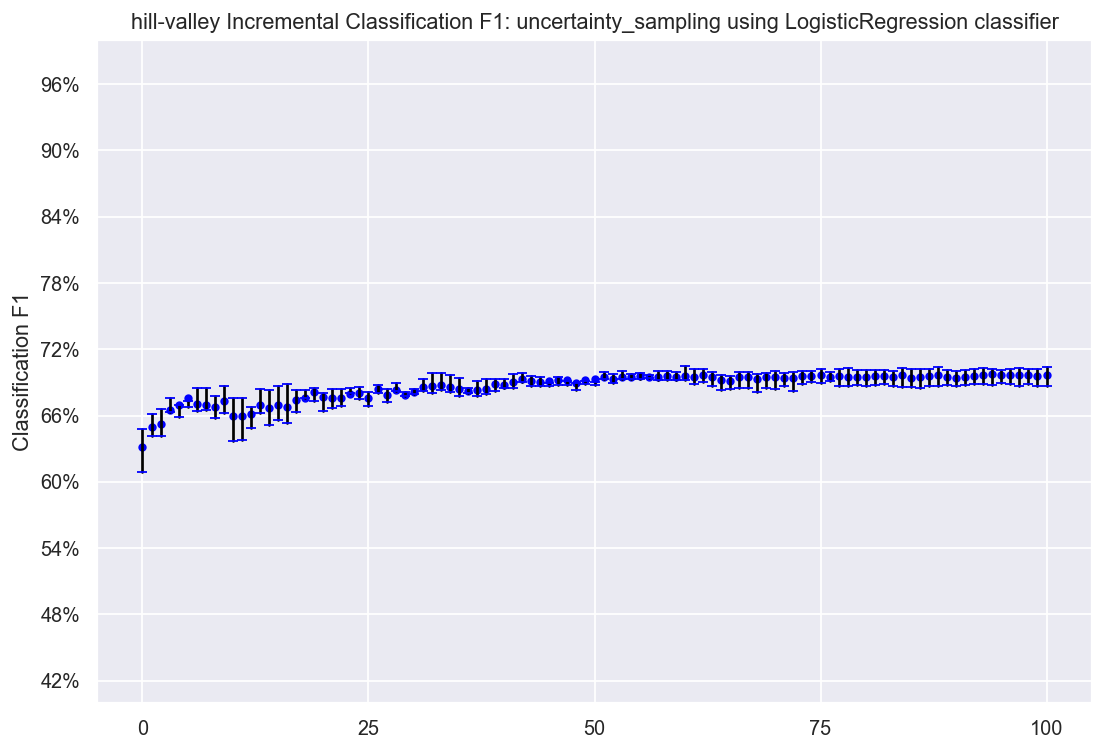

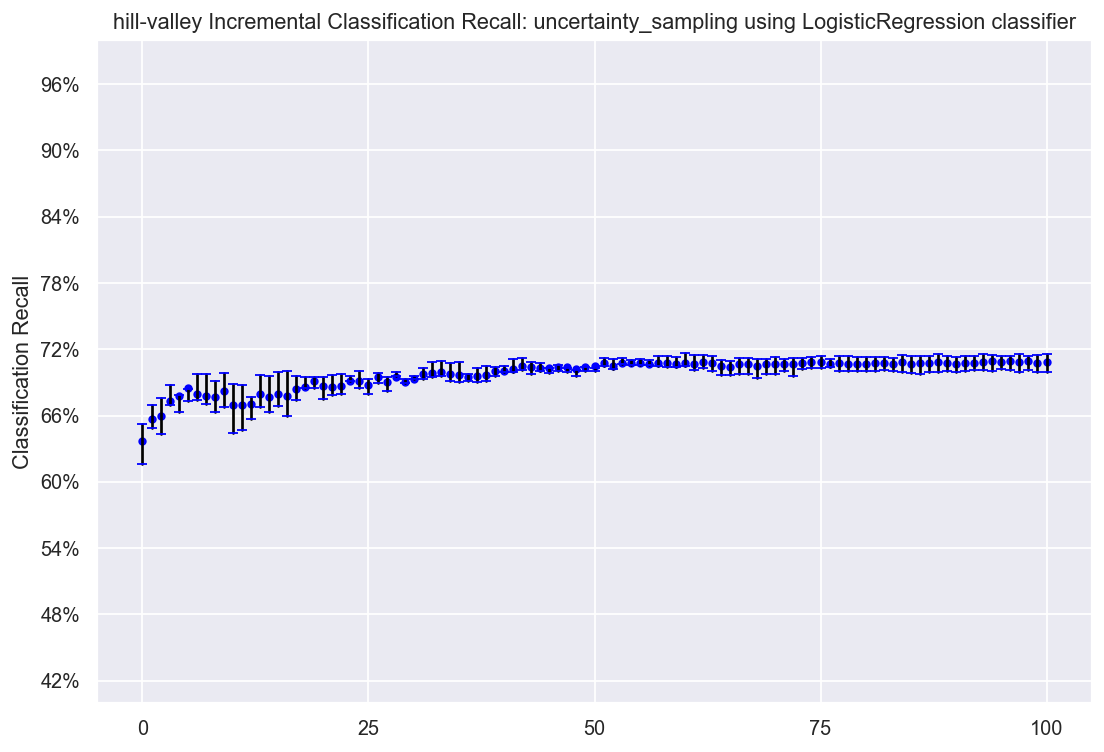

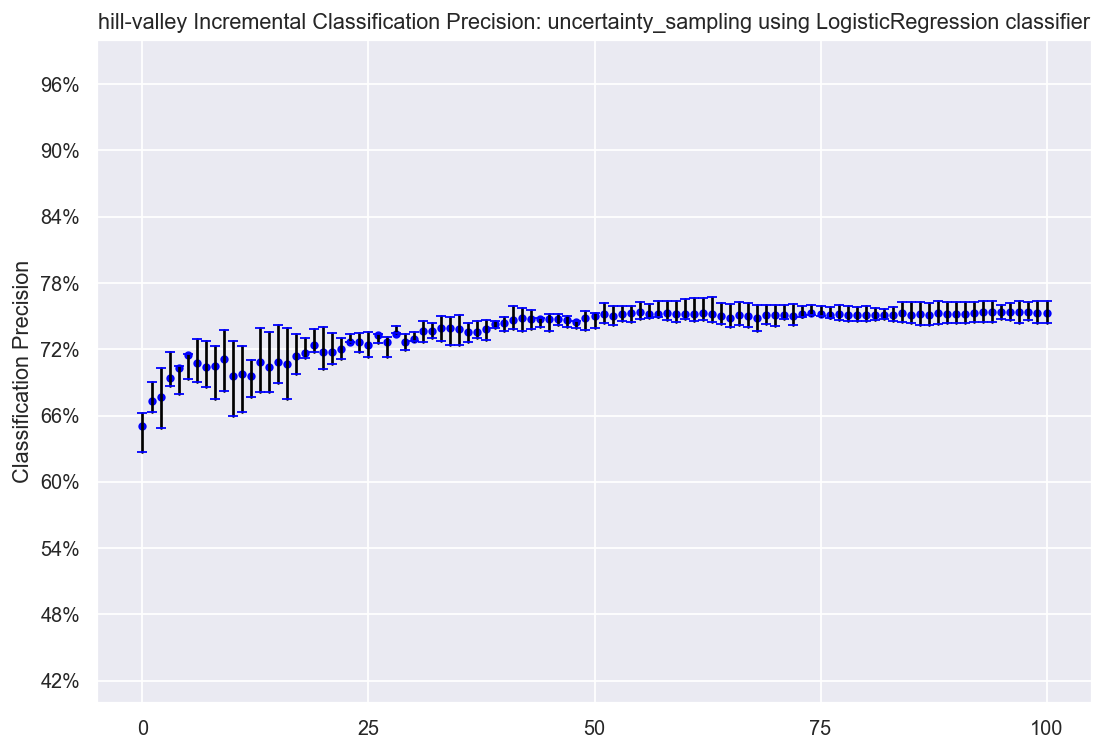

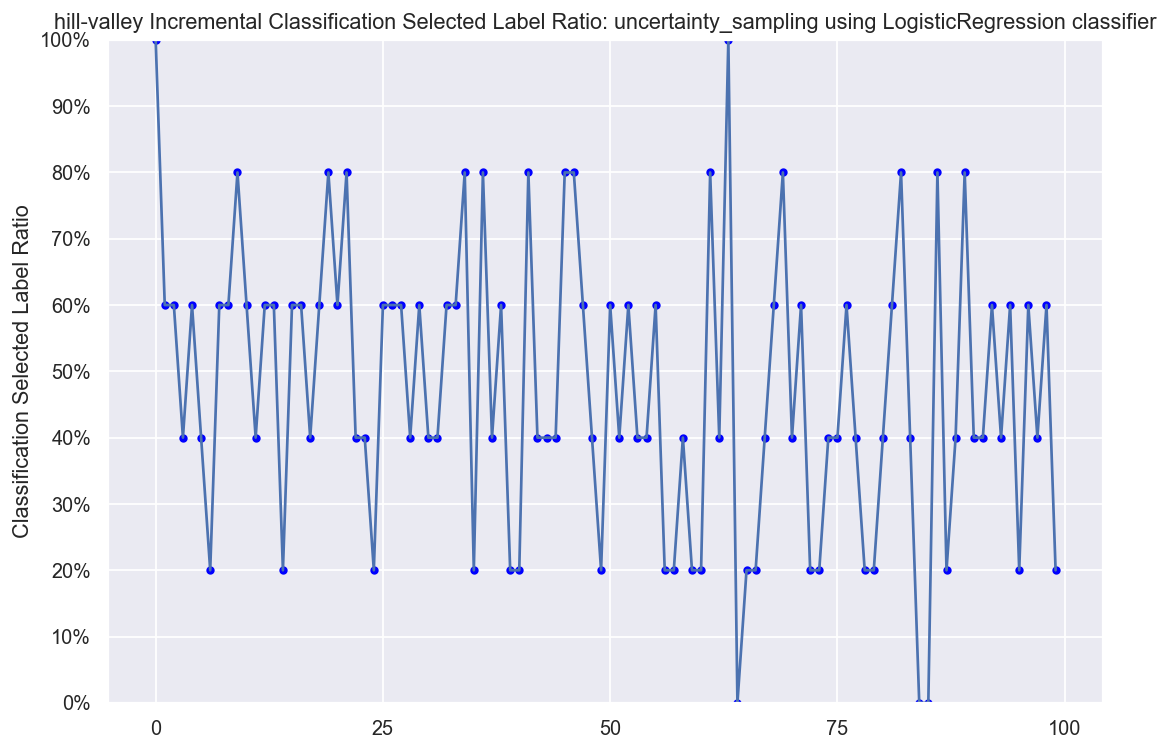

ALC is:  26.926146198553738


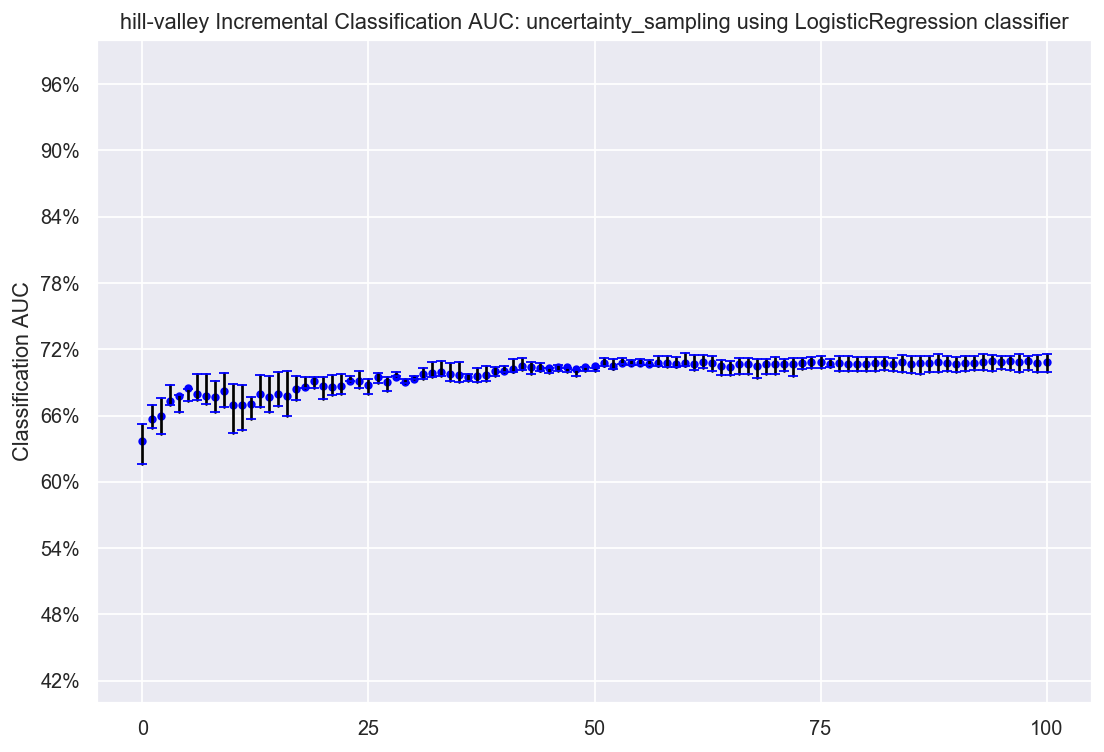

Evaluating on Balanced class ratio data using uncertainty_sampling and the LogisticRegression classifier:


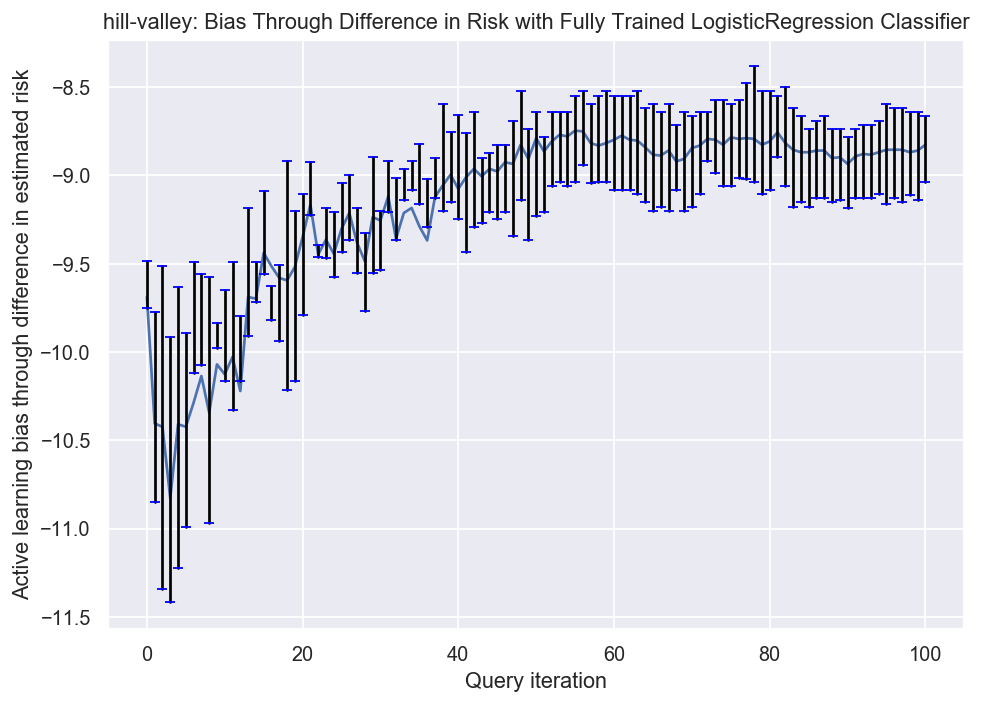

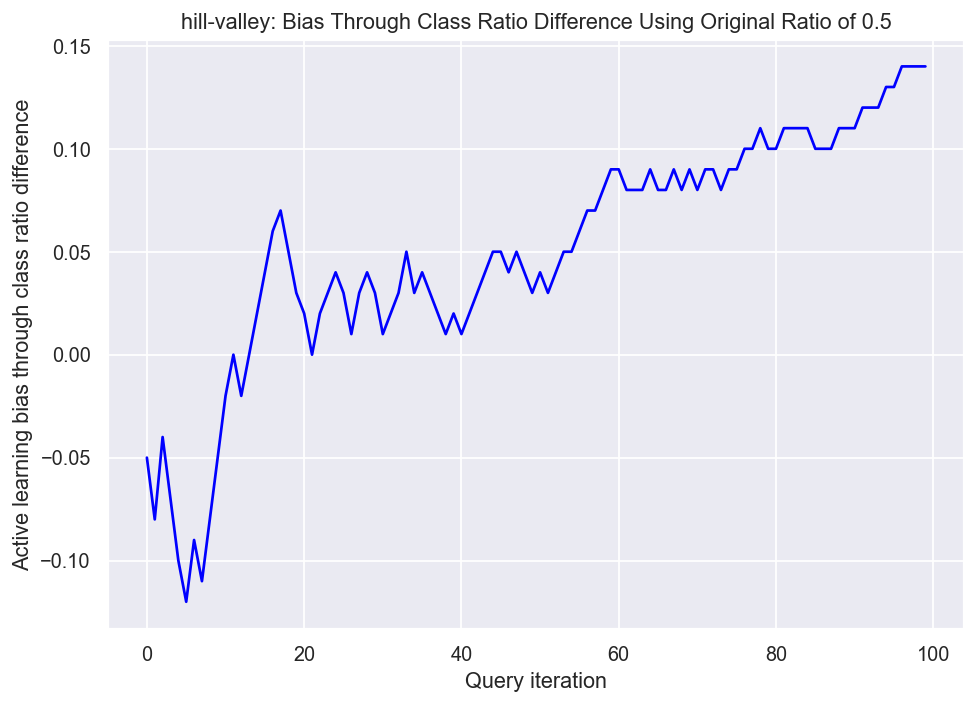

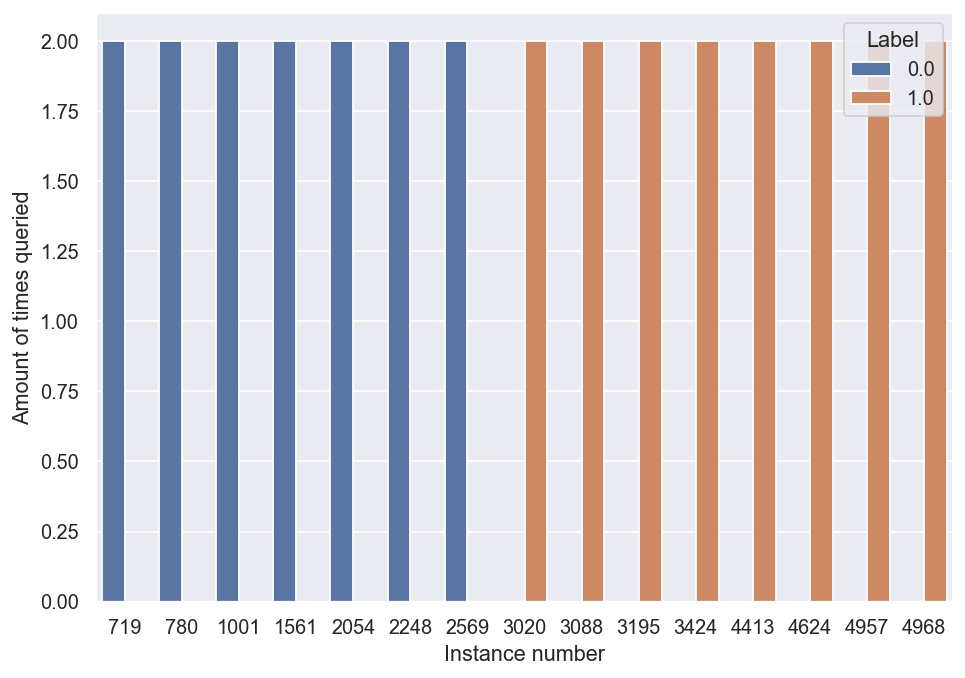

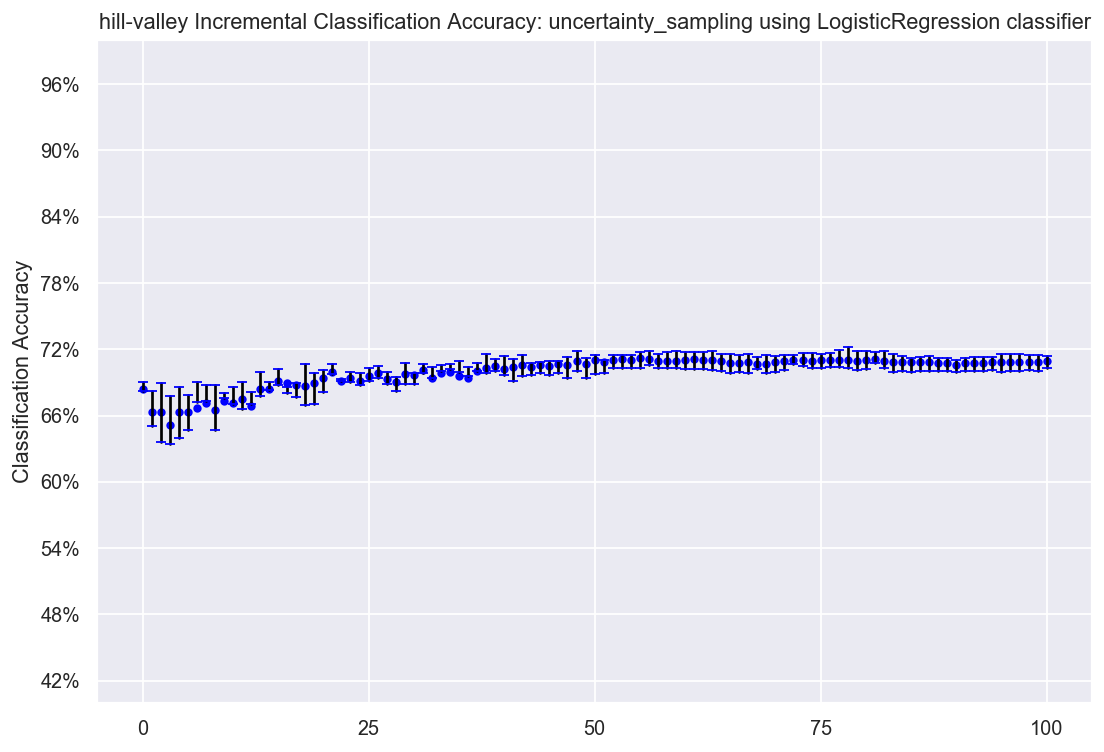

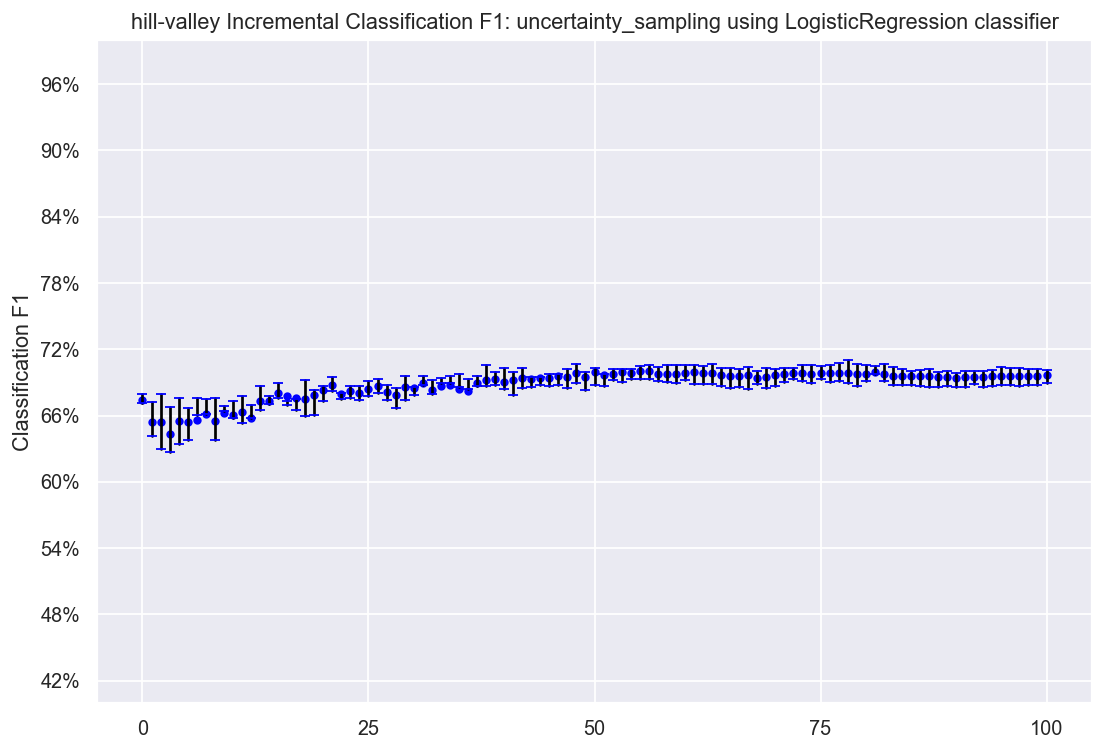

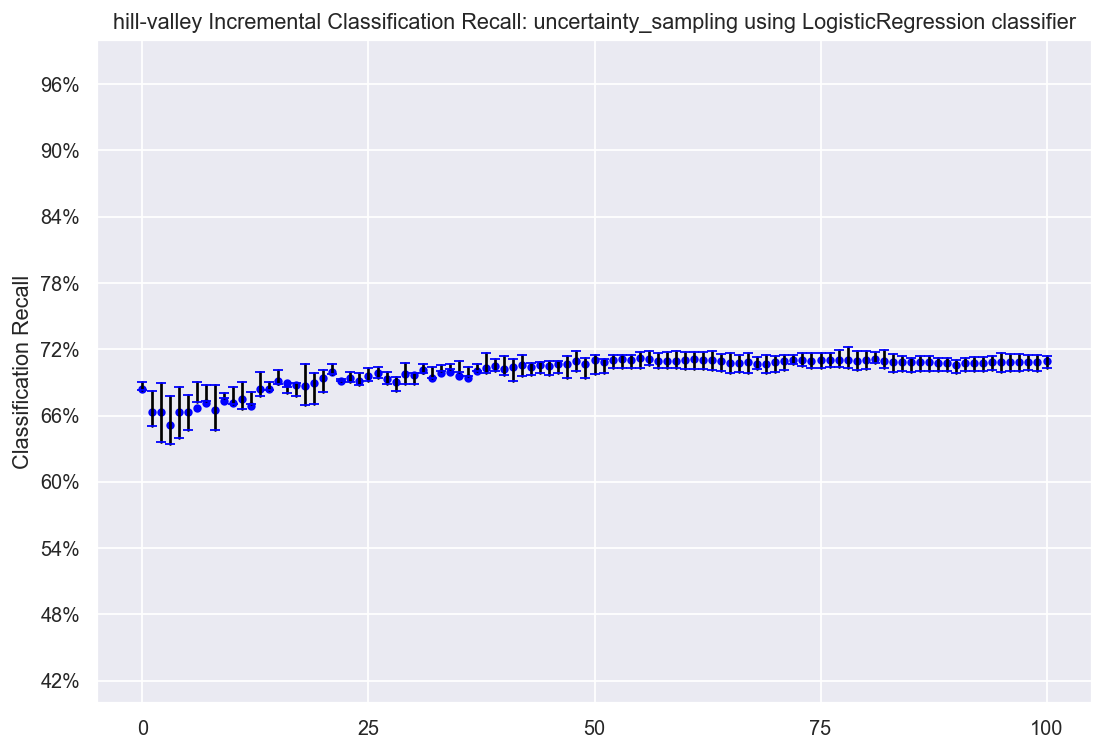

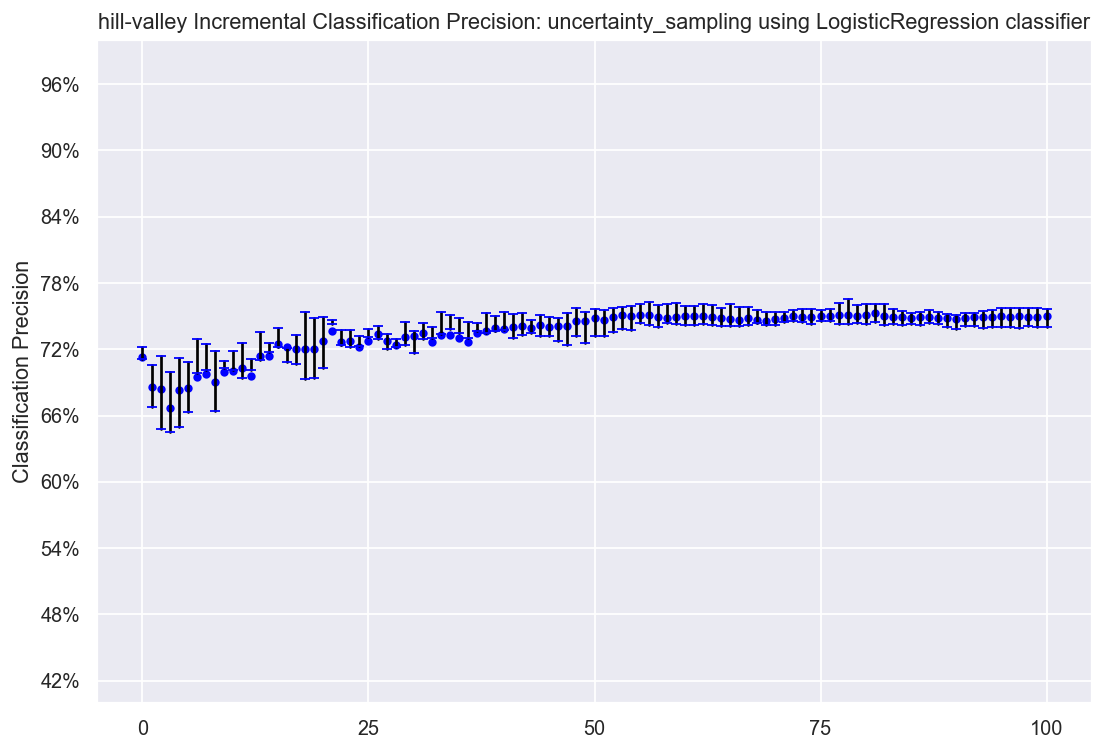

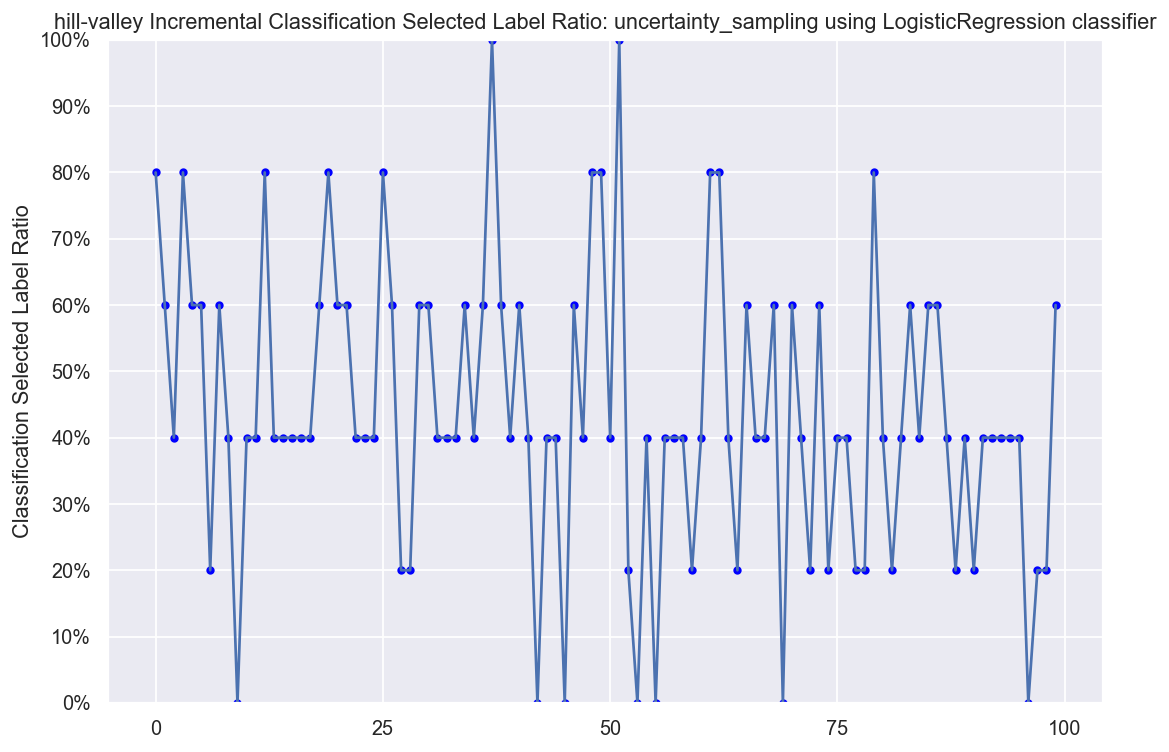

ALC is:  30.865421897025485


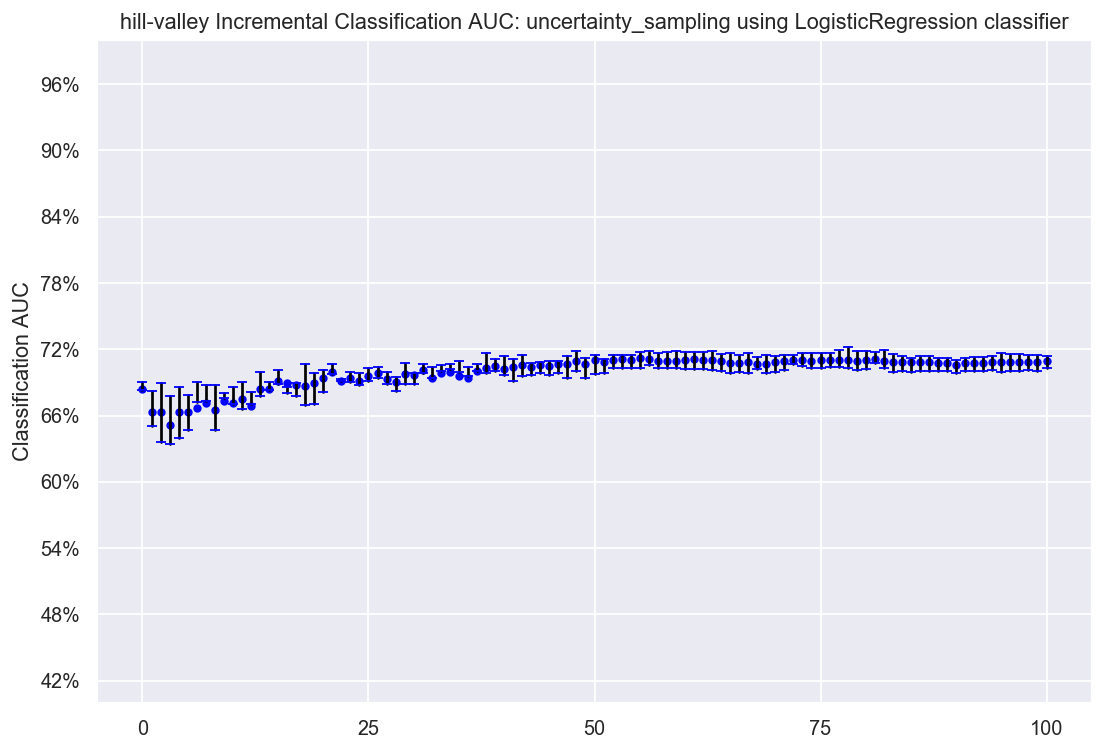

Evaluating on 75-25 class ratio data using uncertainty_sampling and the LogisticRegression classifier:


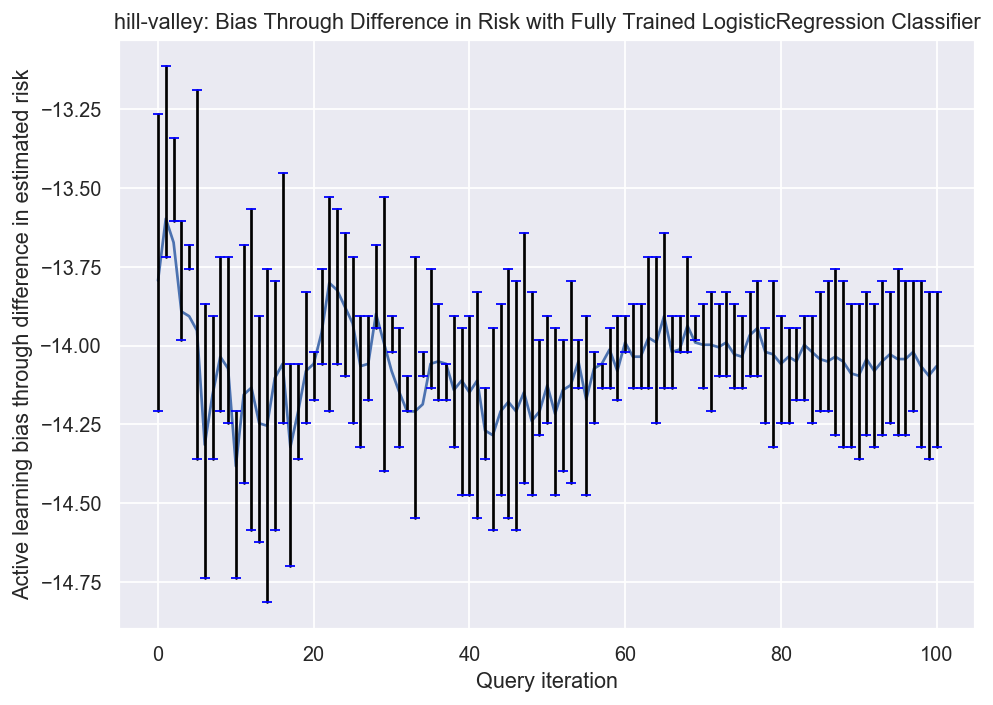

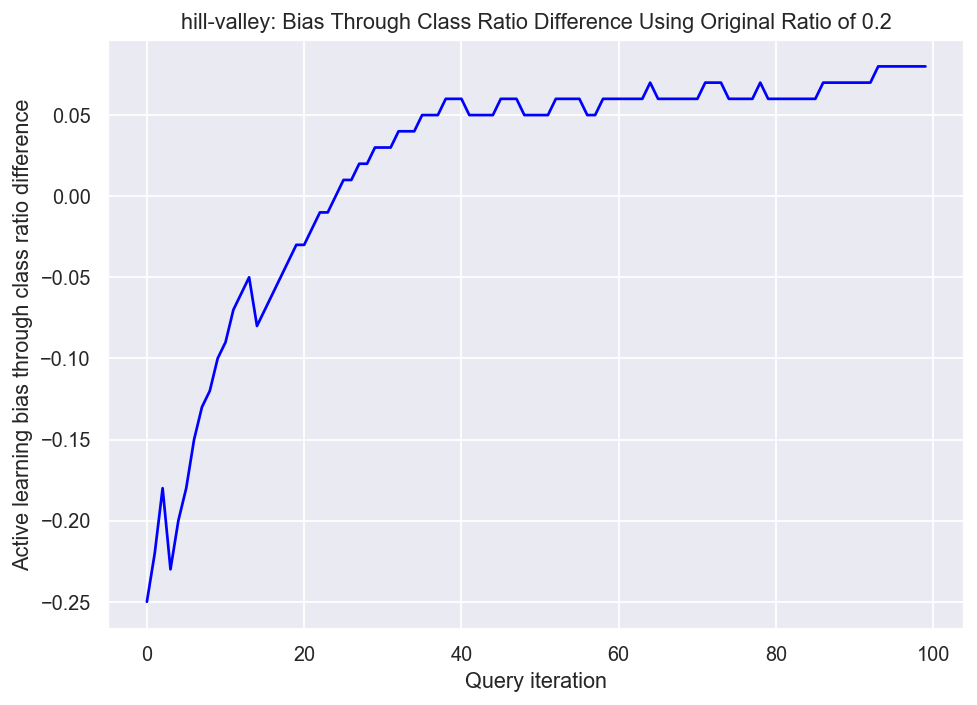

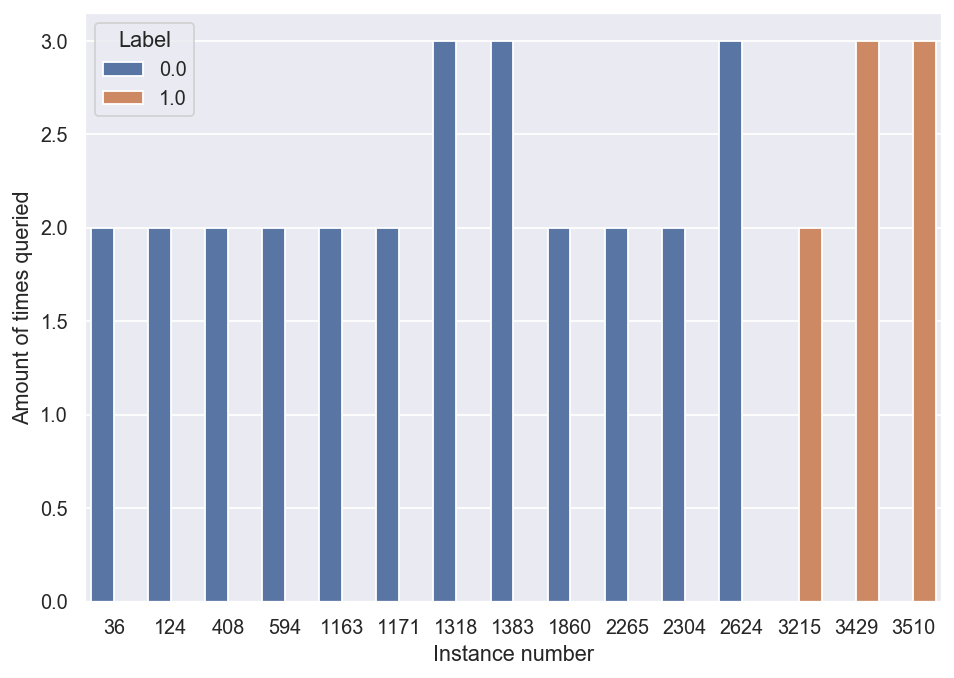

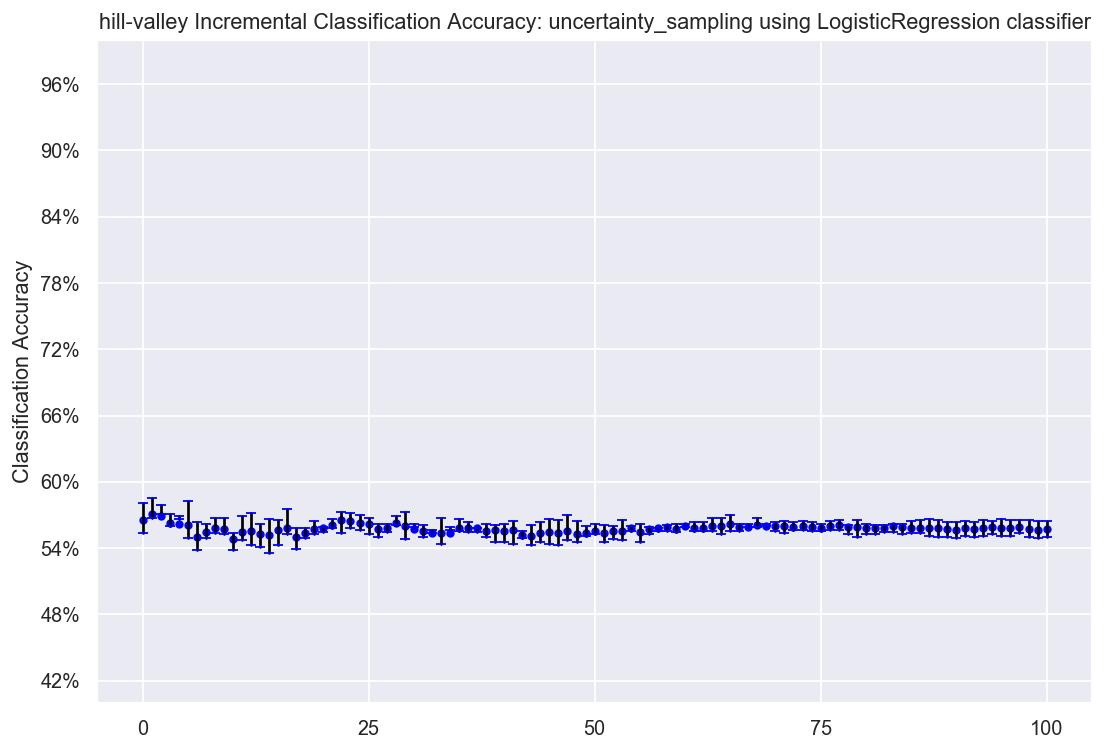

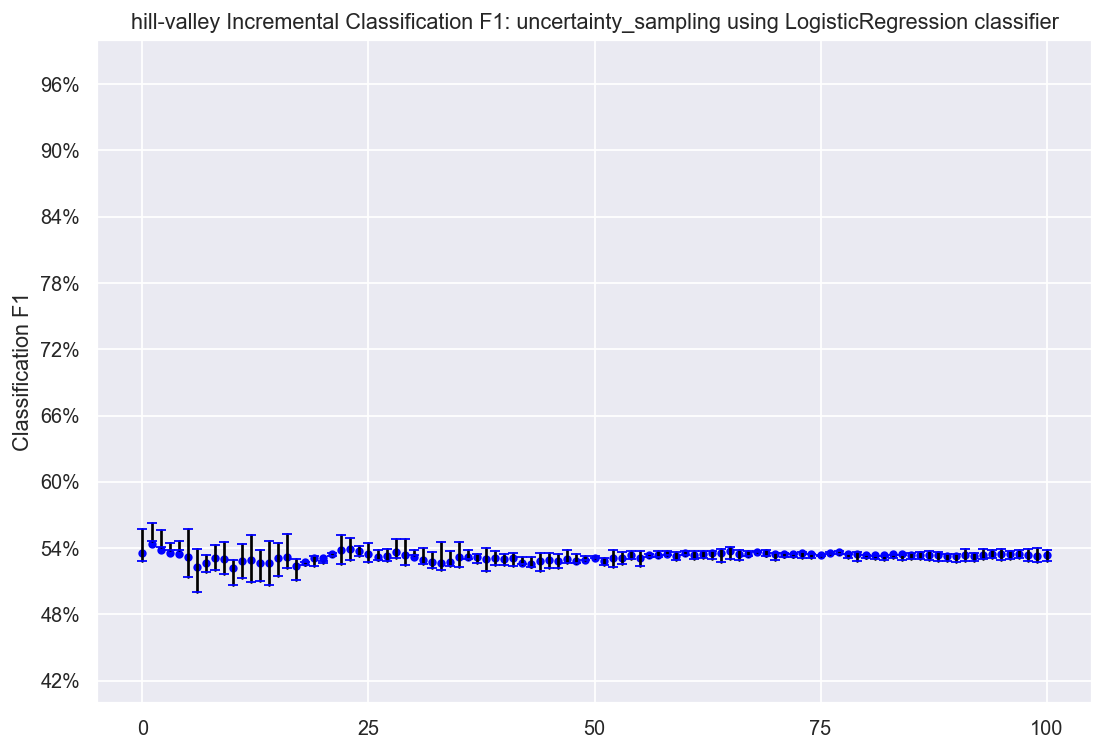

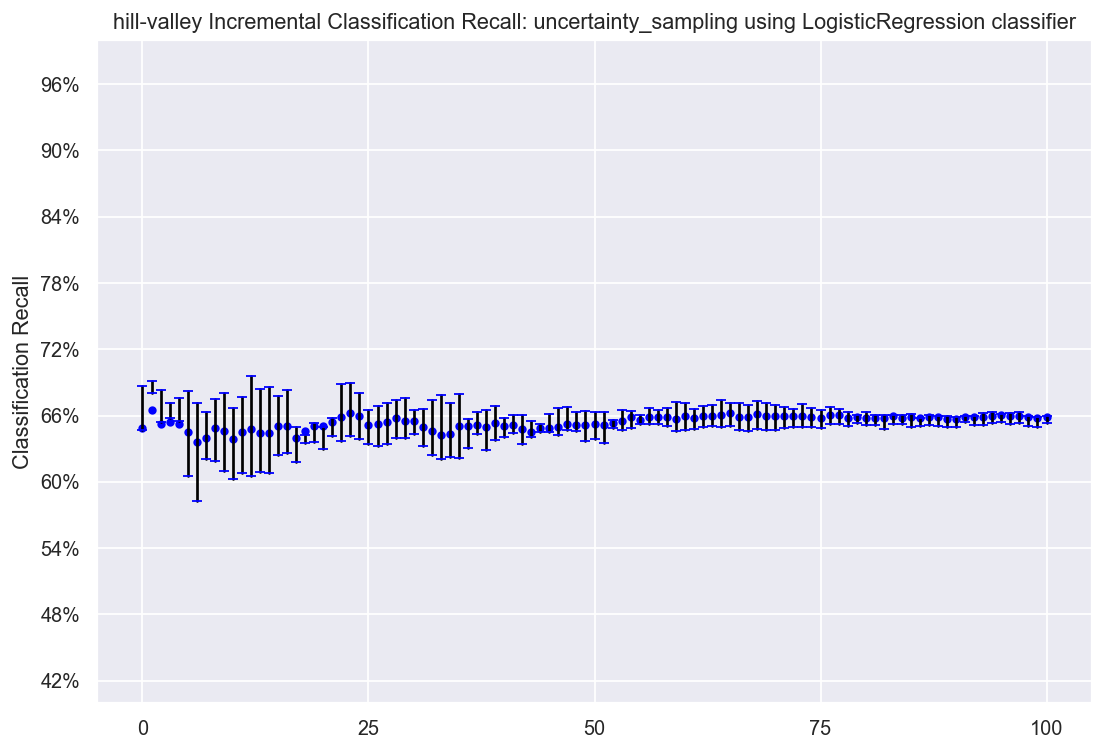

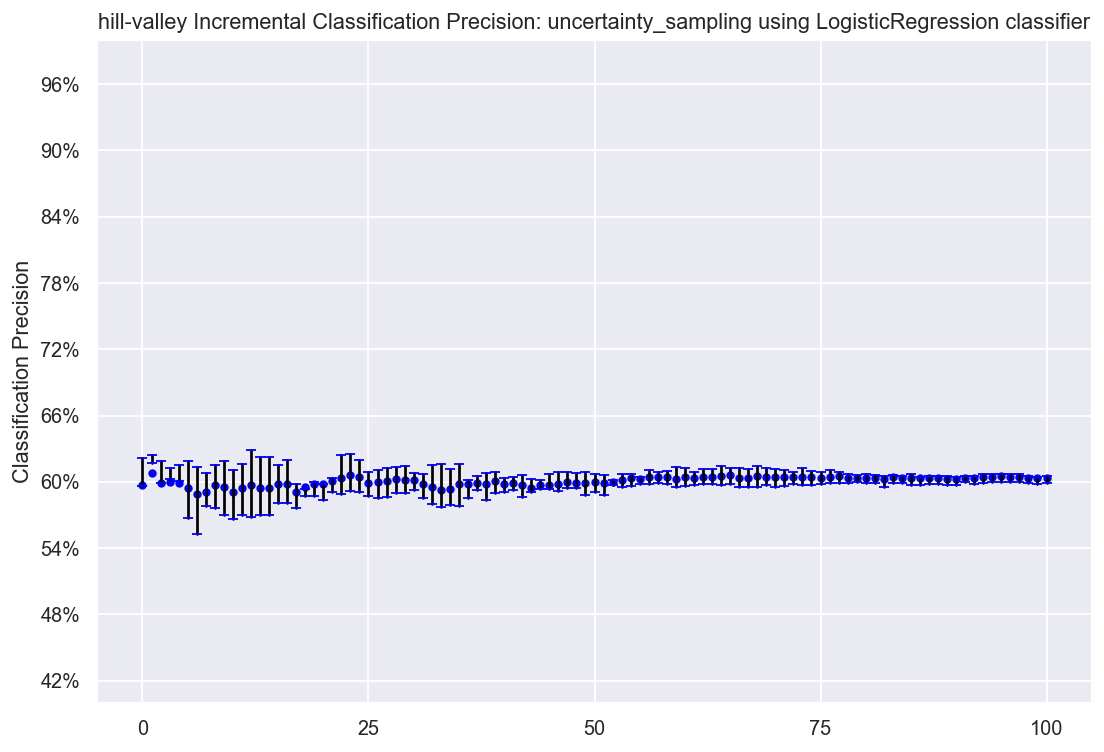

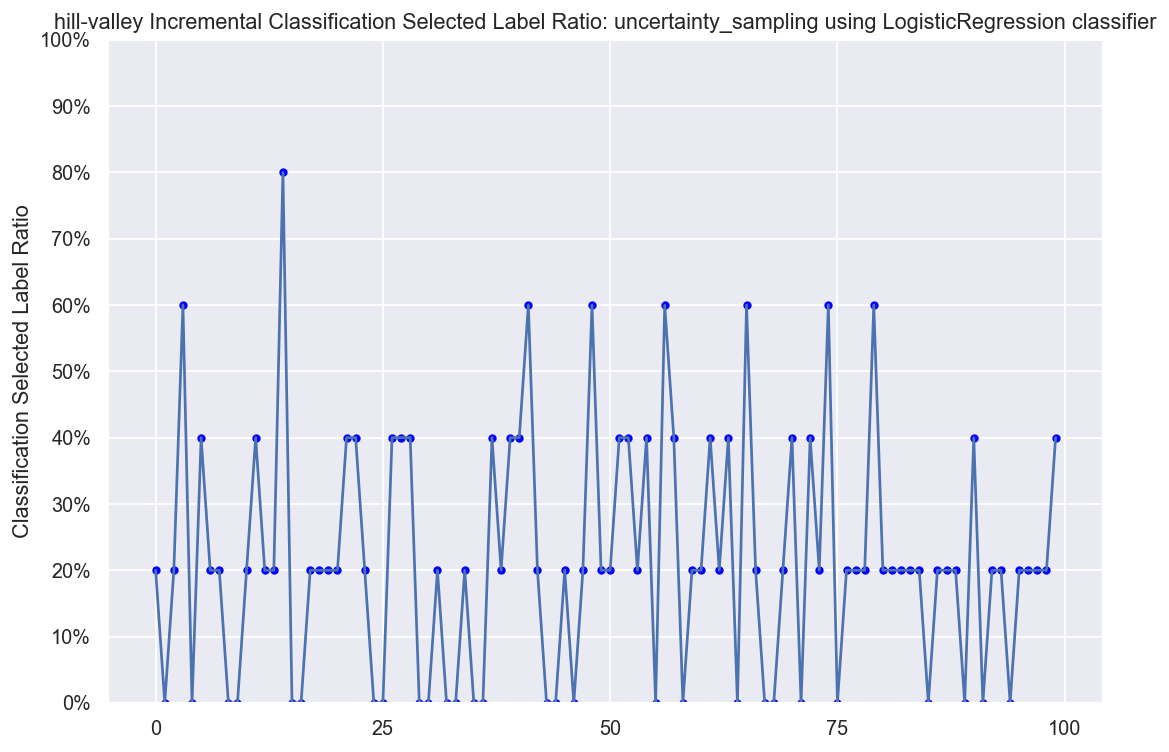

ALC is:  25.89150283994432


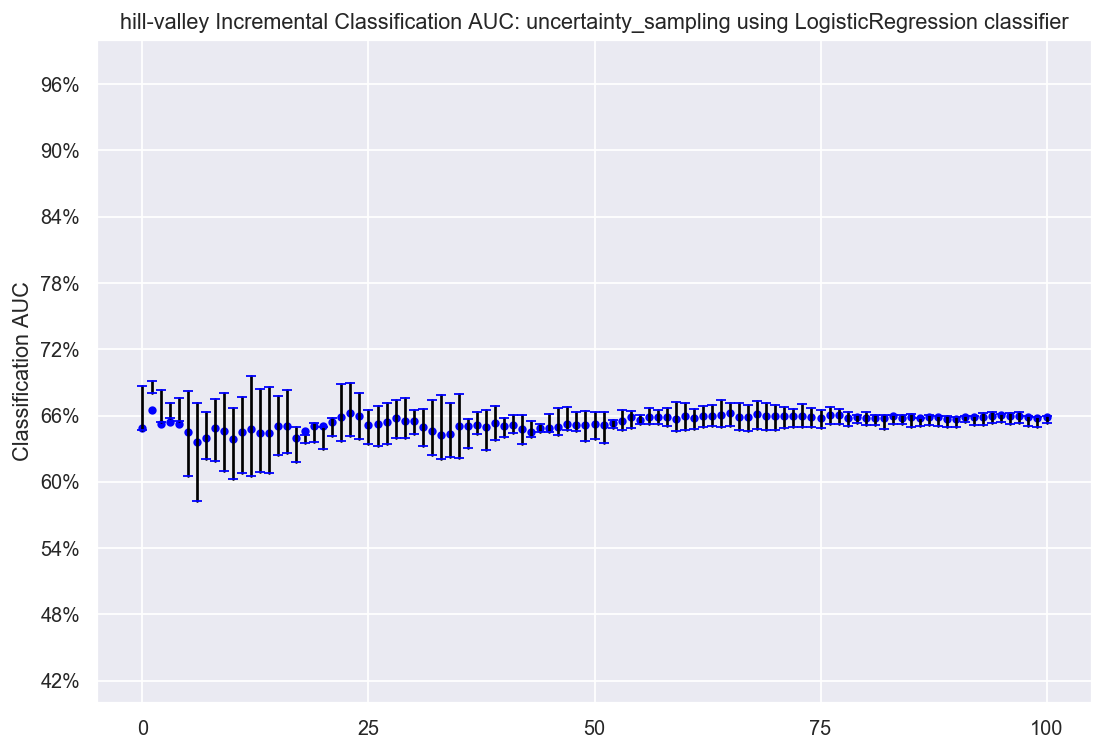

Evaluating on 95-5 class ratio data using uncertainty_sampling and the LogisticRegression classifier:


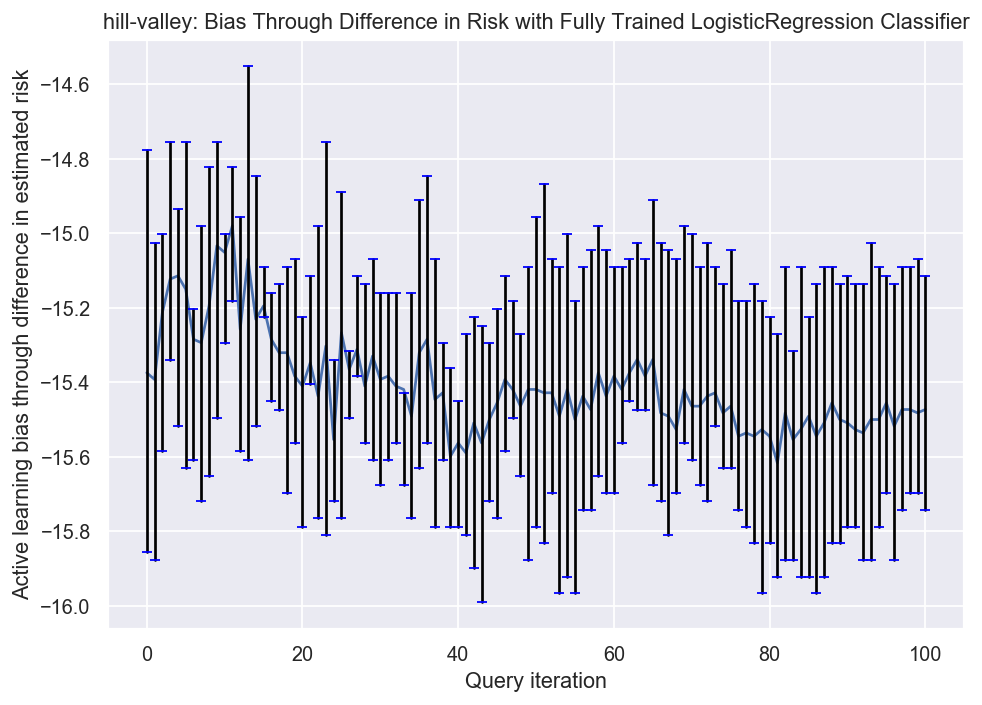

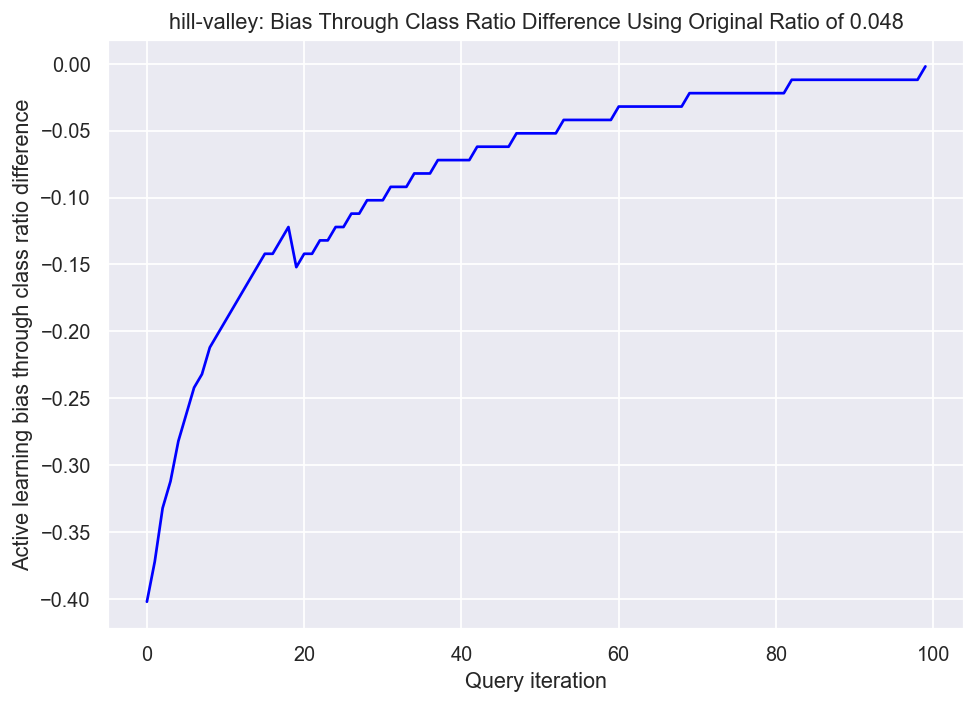

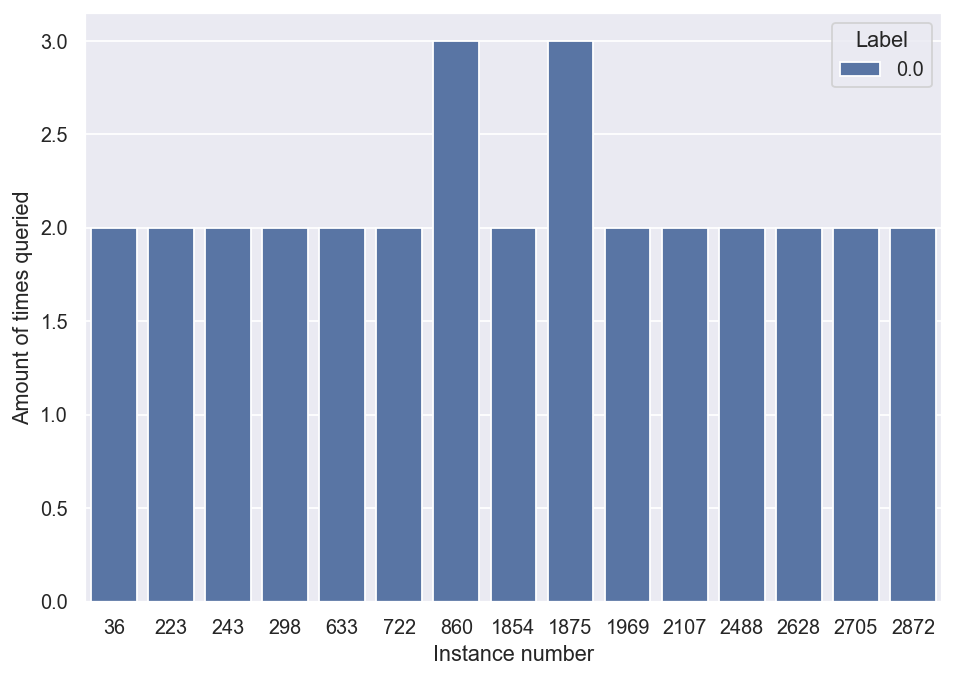

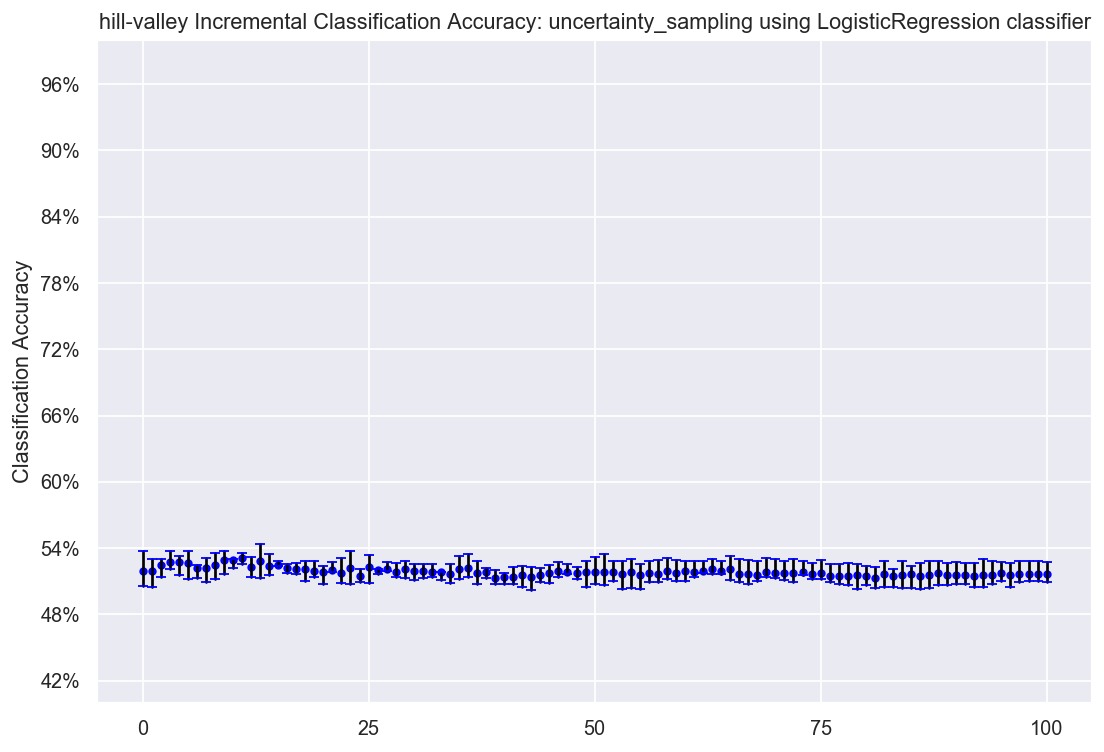

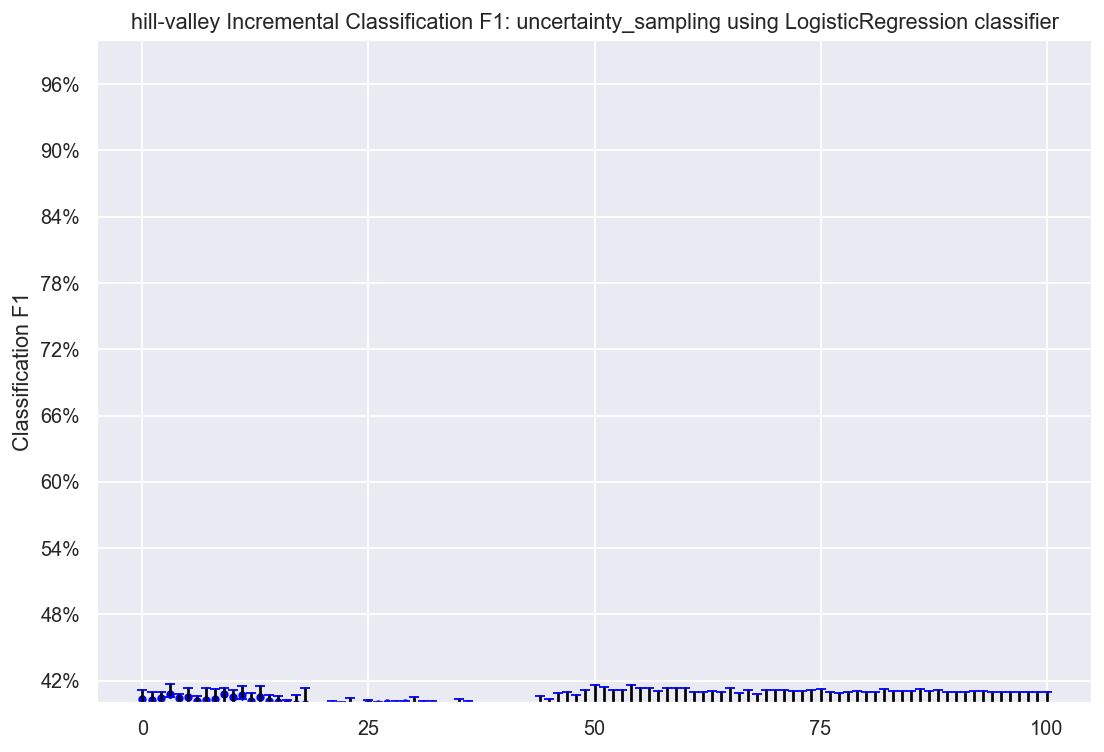

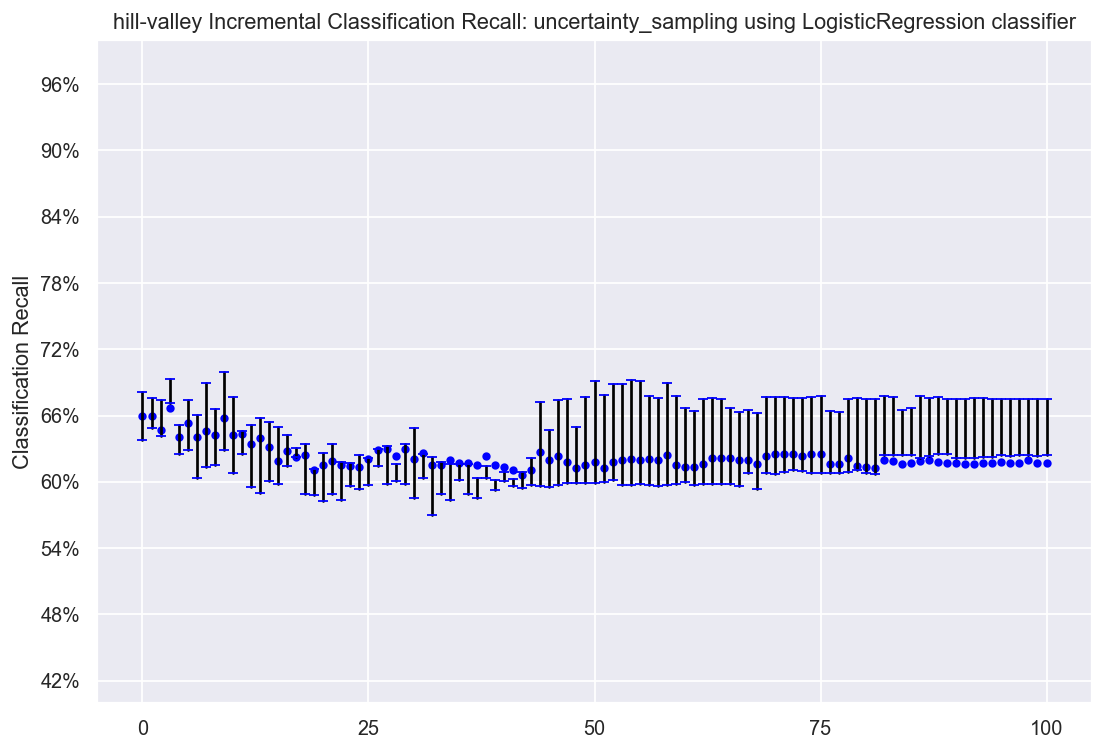

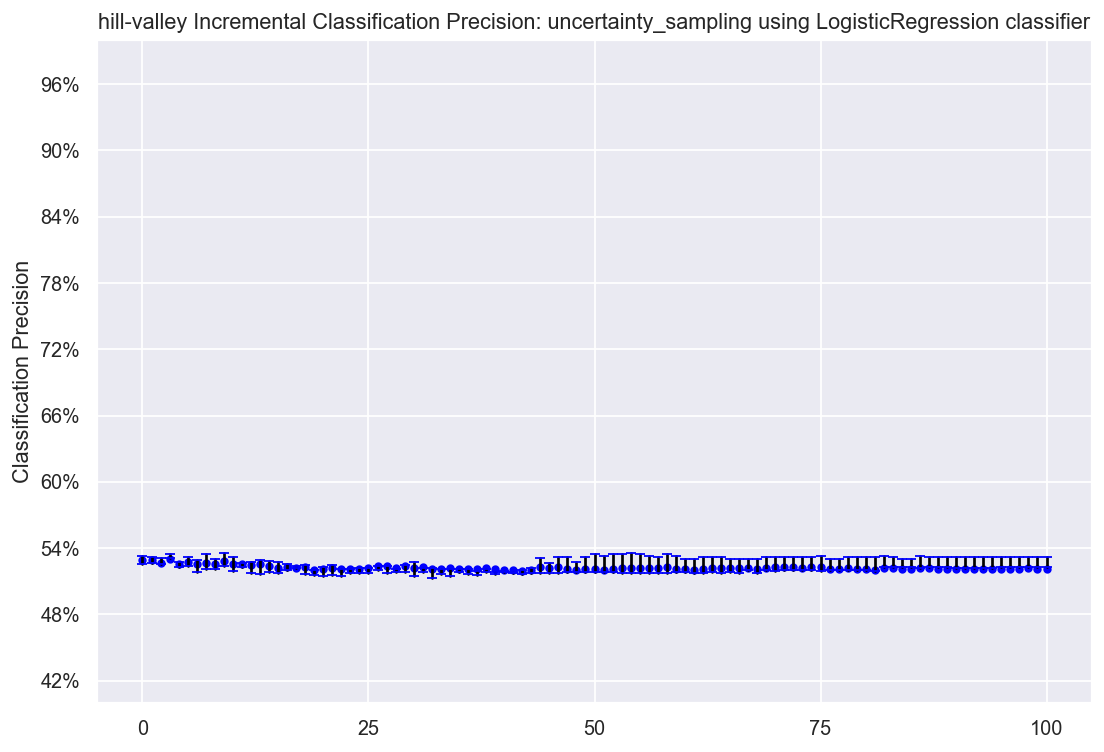

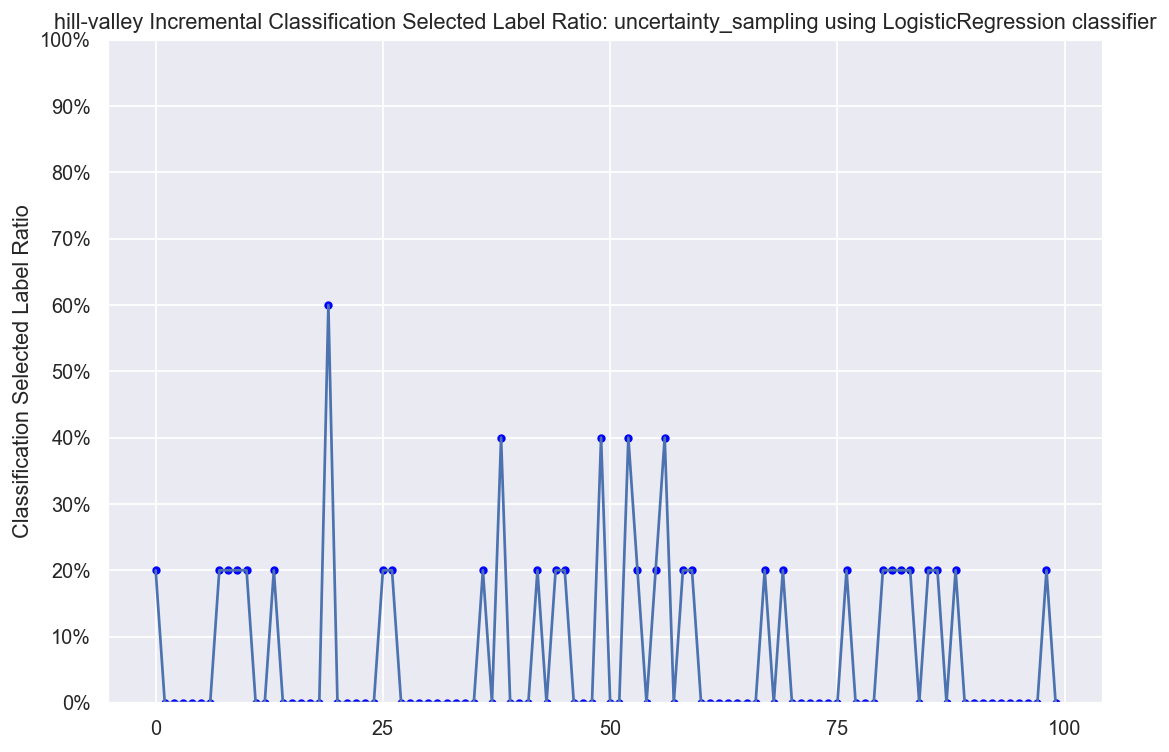

ALC is:  25.33941462961507


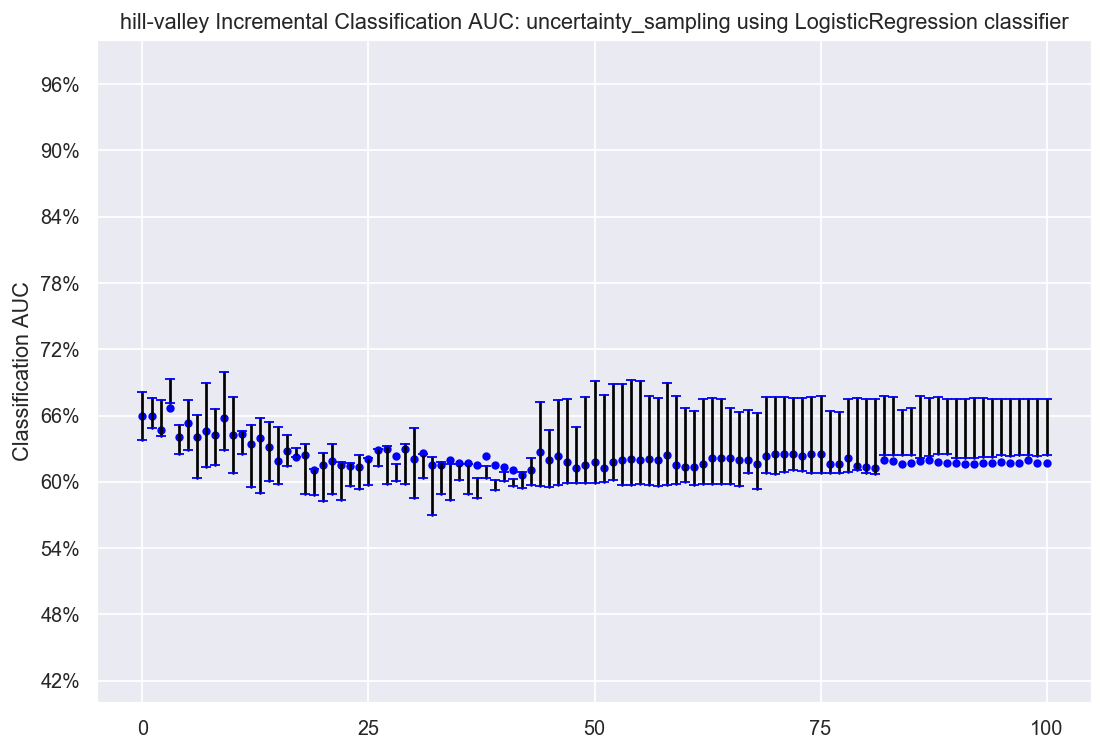

Running experiments on mushroom
Counter({0: 4208, 1: 3916})
Counter({0: 3916, 1: 3916})
Counter({0: 4208, 1: 1052})
Counter({0: 4208, 1: 211})
LogisticRegression: Fully trained classifier performance:
 - Accuracy:  0.9544708777686628
 - F1:  0.9544230222195724
 - Recall:  0.9544110910511707
 - Precision:  0.9544352755158617
 - AUC:  0.9544110910511707
 - Log Loss:  1.572538210702932
XGBClassifier: Fully trained classifier performance:
 - Accuracy:  1.0
 - F1:  1.0
 - Recall:  1.0
 - Precision:  1.0
 - AUC:  1.0
 - Log Loss:  9.992007221626415e-16
RandomForestClassifier: Fully trained classifier performance:
 - Accuracy:  1.0
 - F1:  1.0
 - Recall:  1.0
 - Precision:  1.0
 - AUC:  1.0
 - Log Loss:  9.992007221626415e-16
hill-valley
Evaluating on Original class ratio data using uncertainty_sampling and the LogisticRegression classifier:


<Figure size 432x288 with 0 Axes>

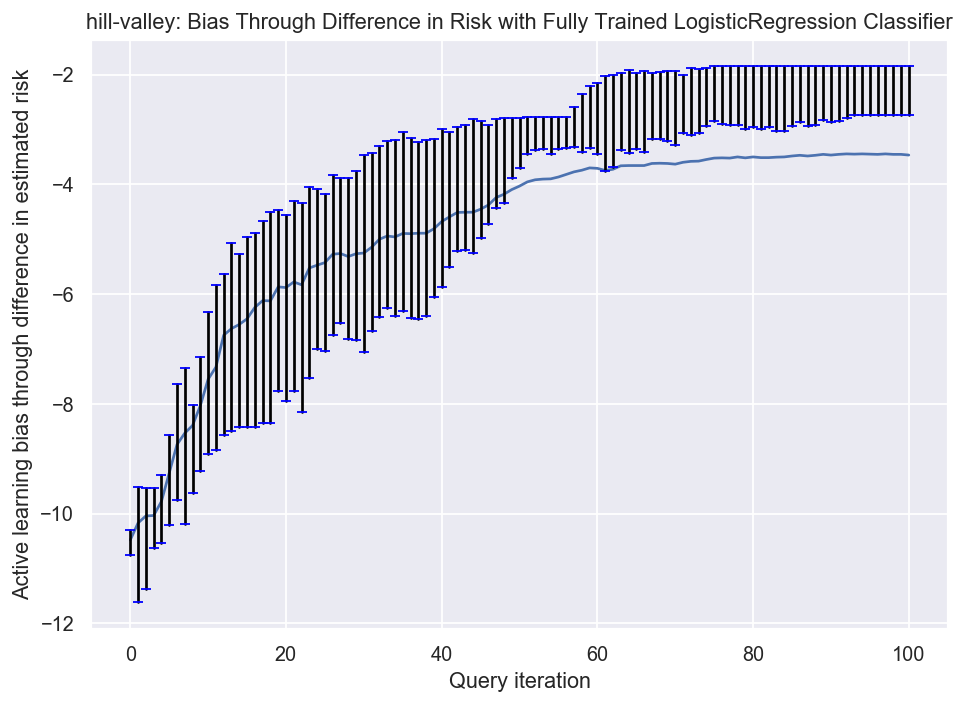

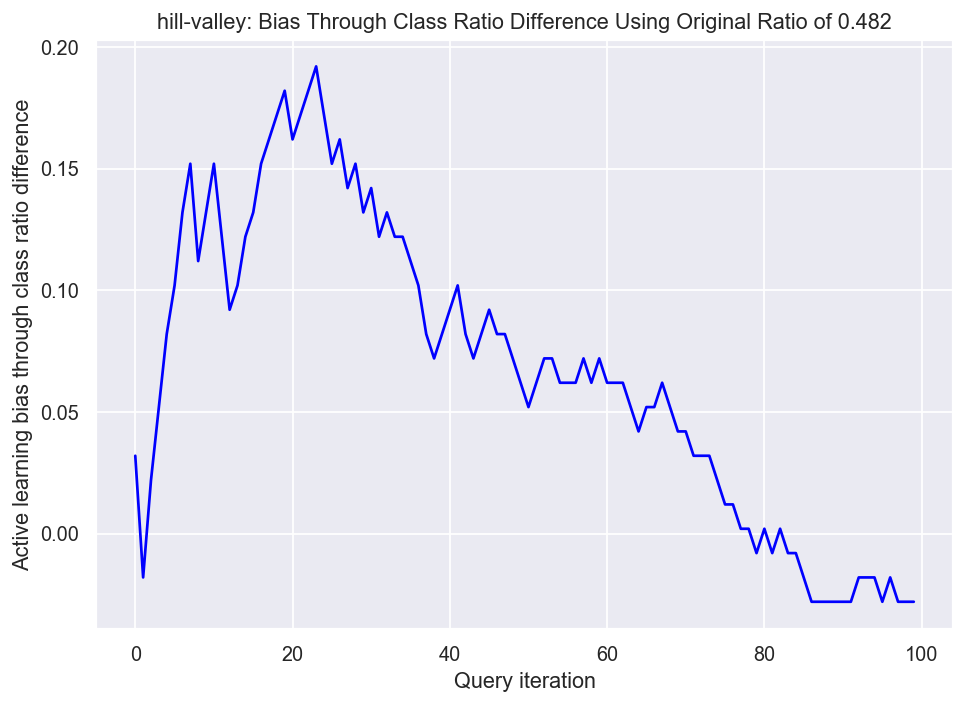

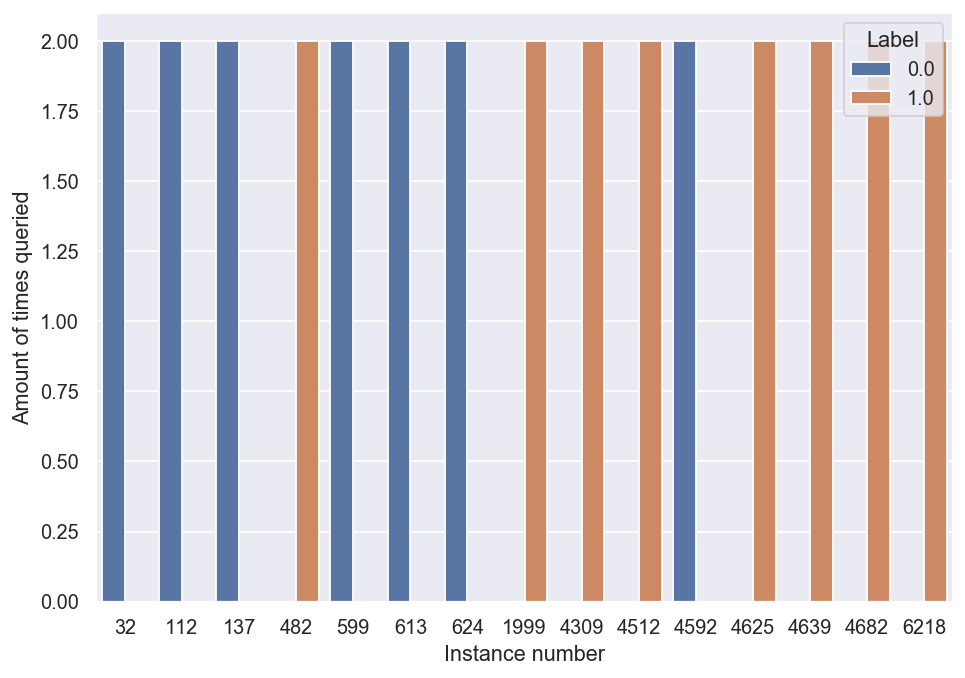

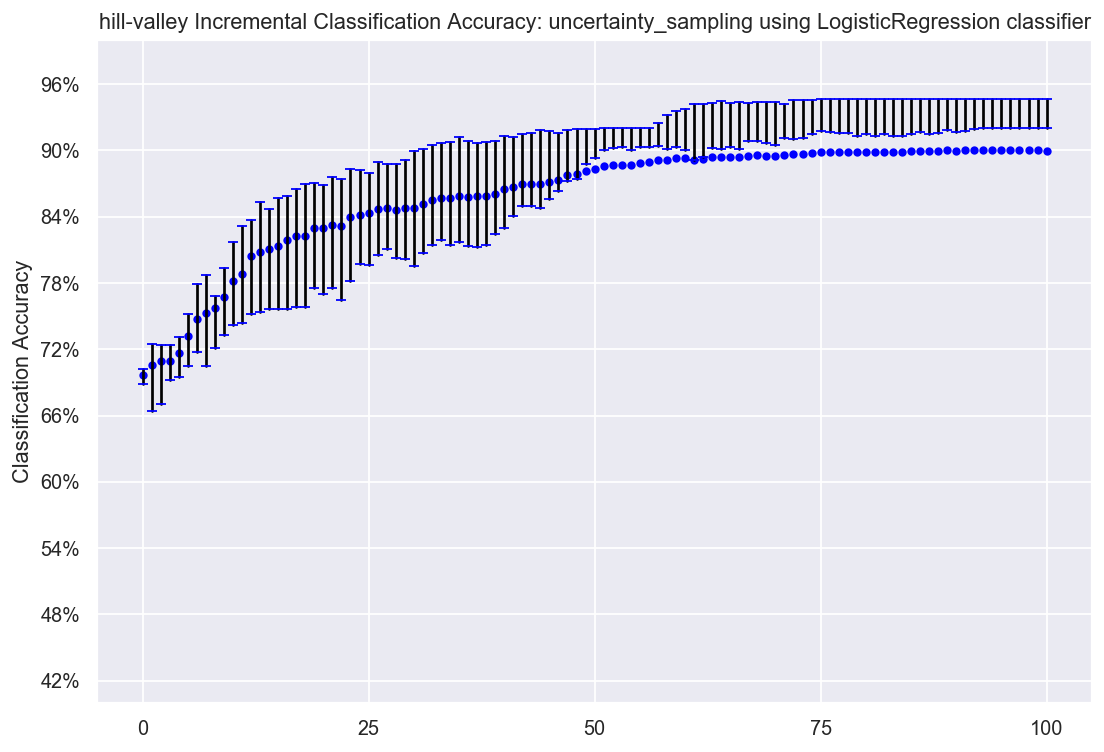

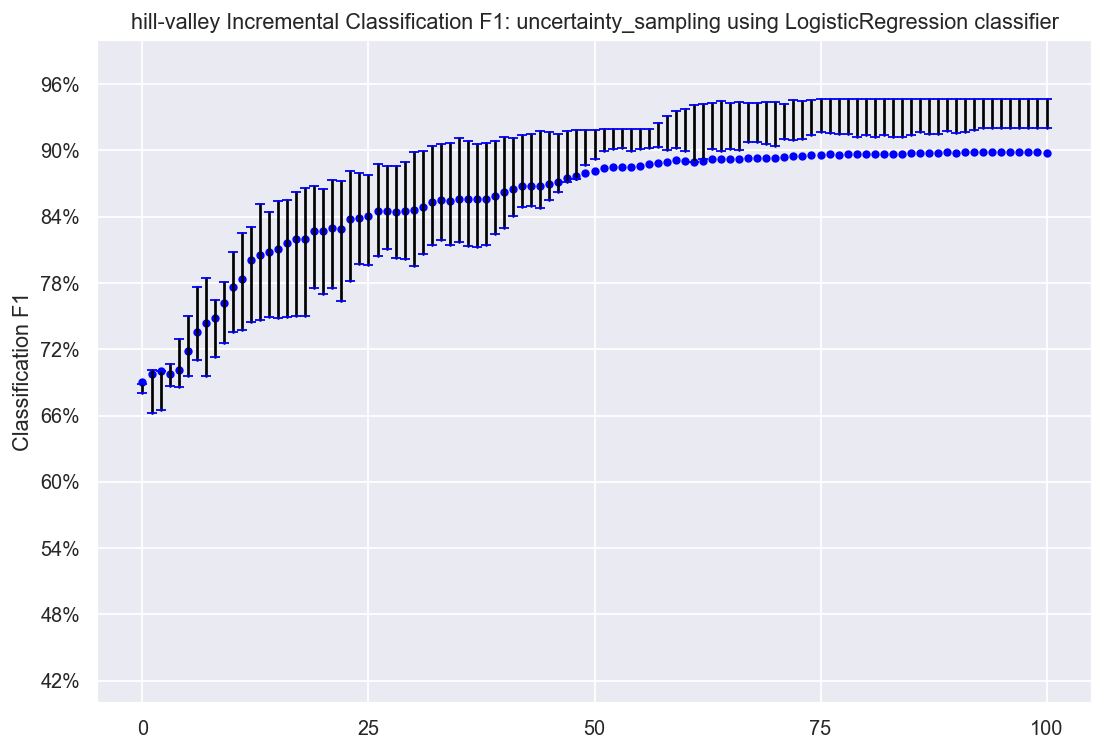

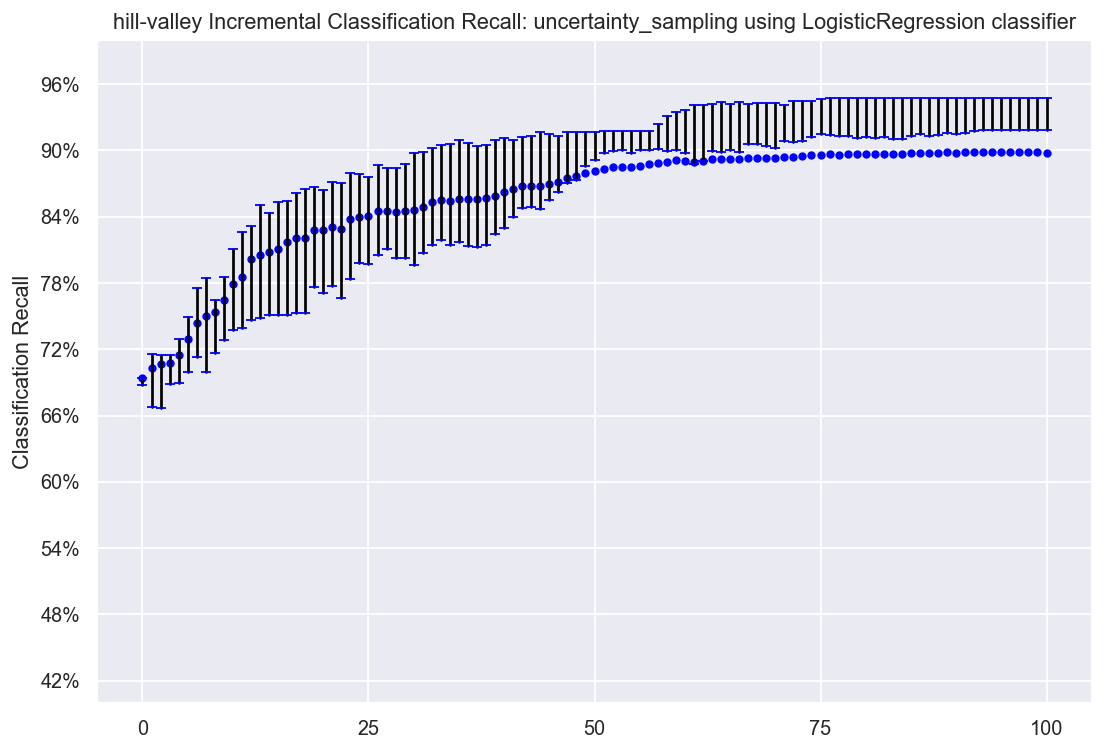

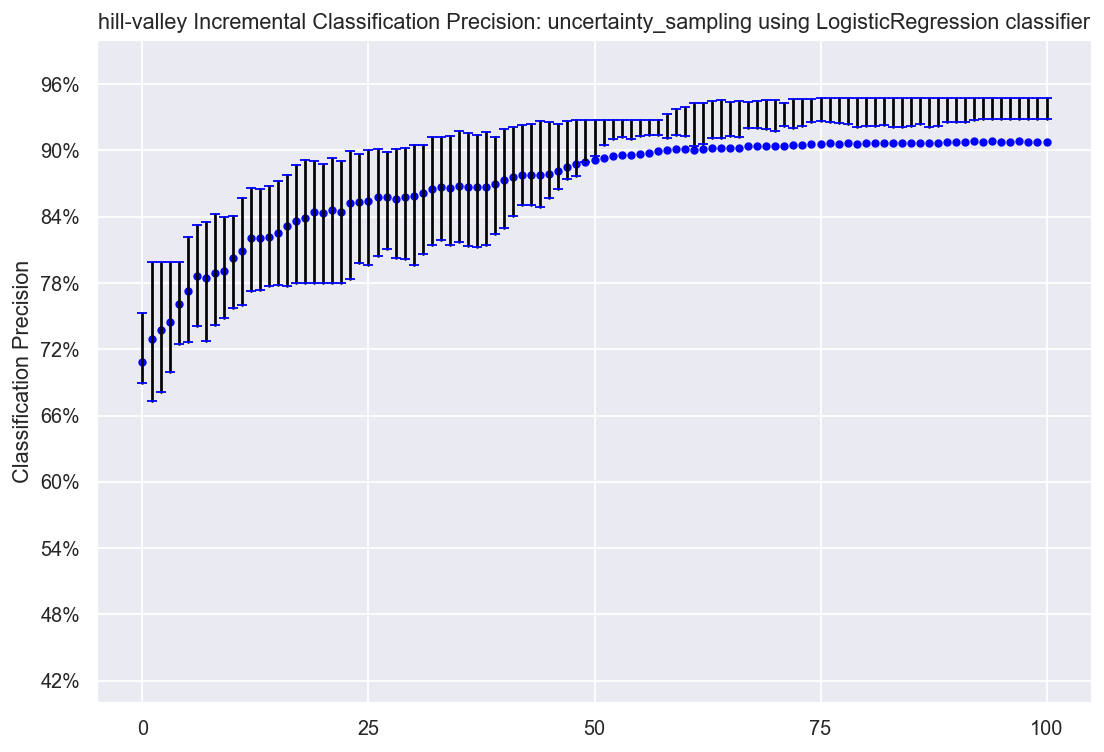

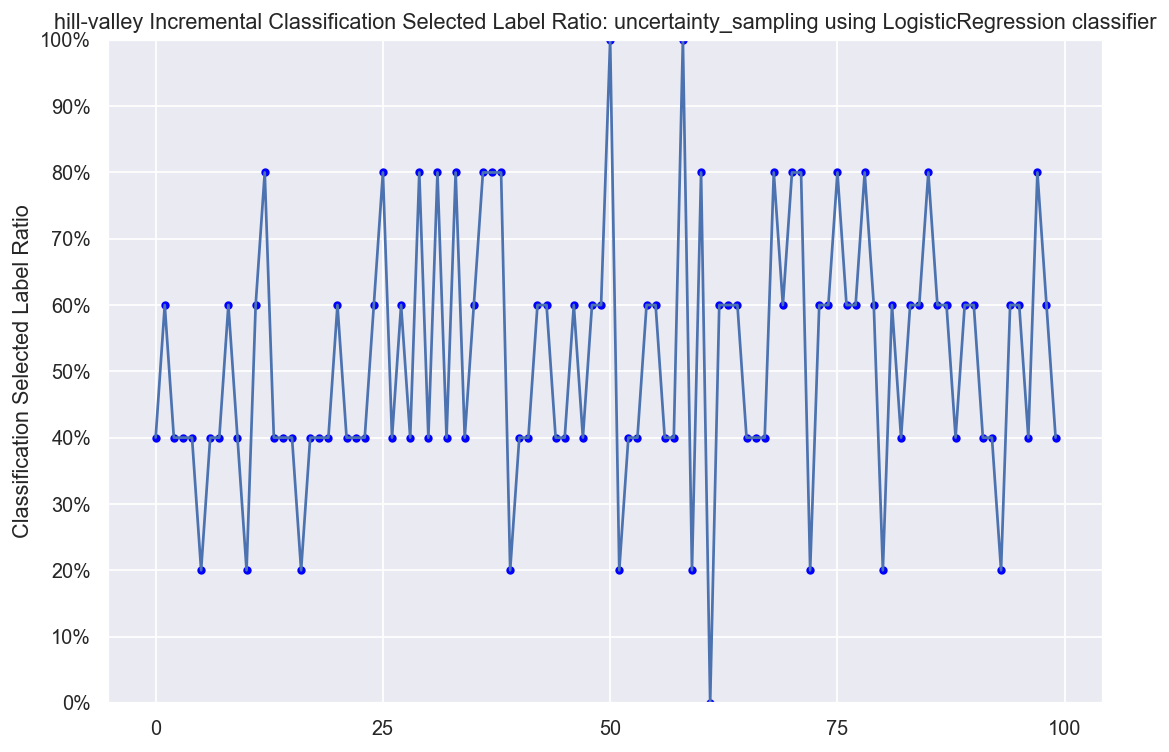

ALC is:  39.52411159687518


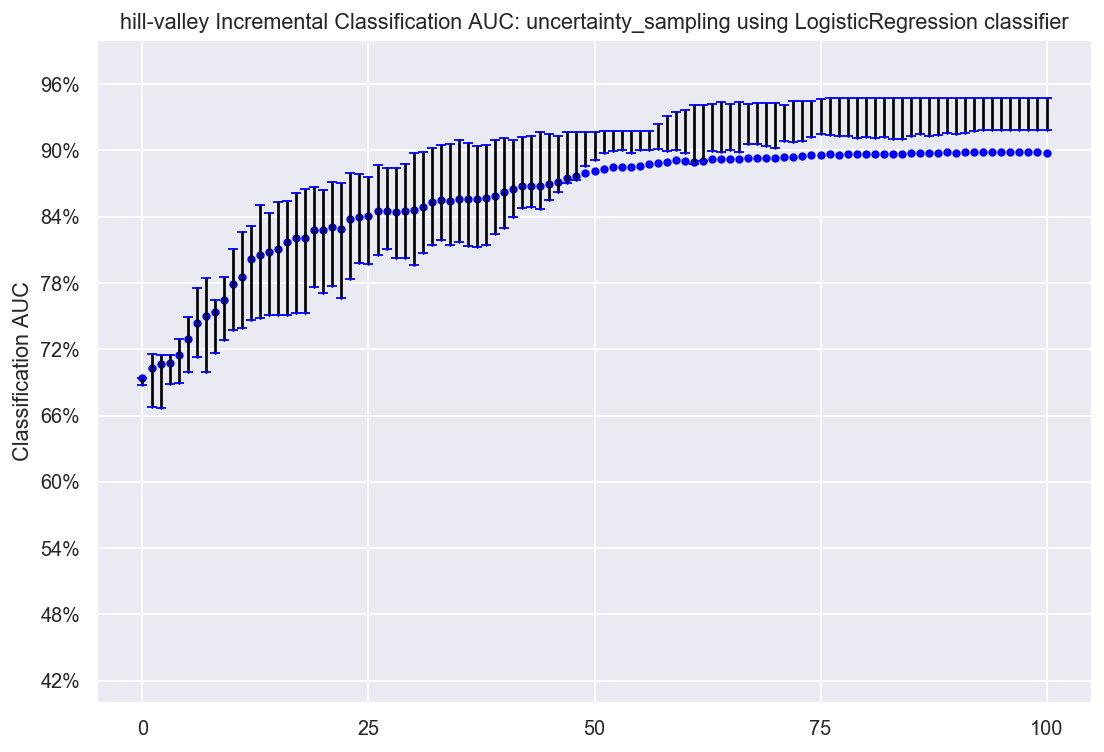

Evaluating on Balanced class ratio data using uncertainty_sampling and the LogisticRegression classifier:


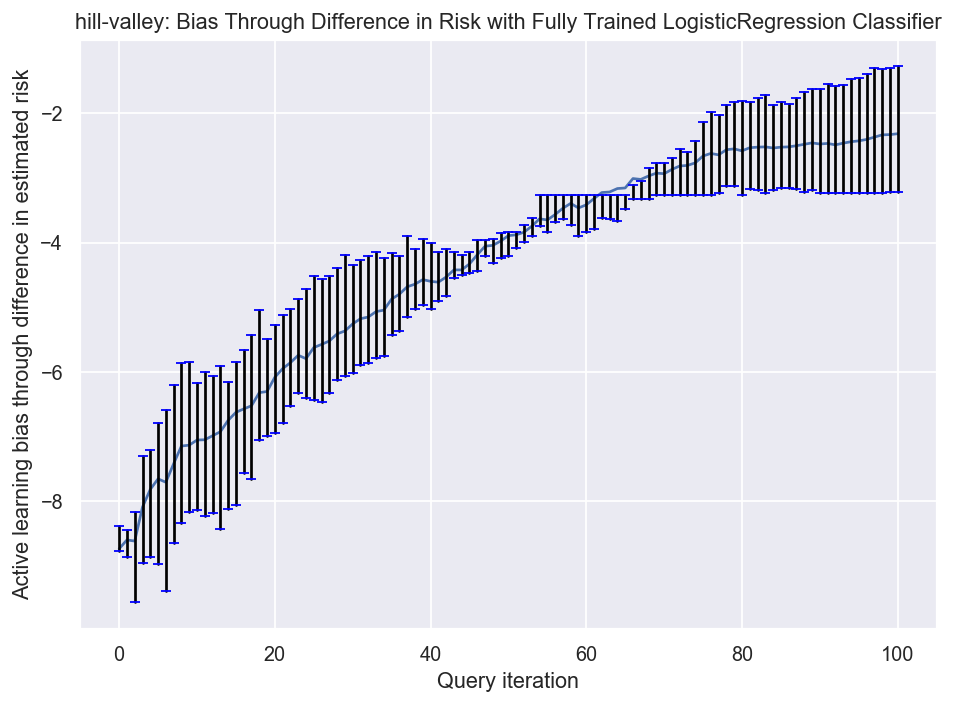

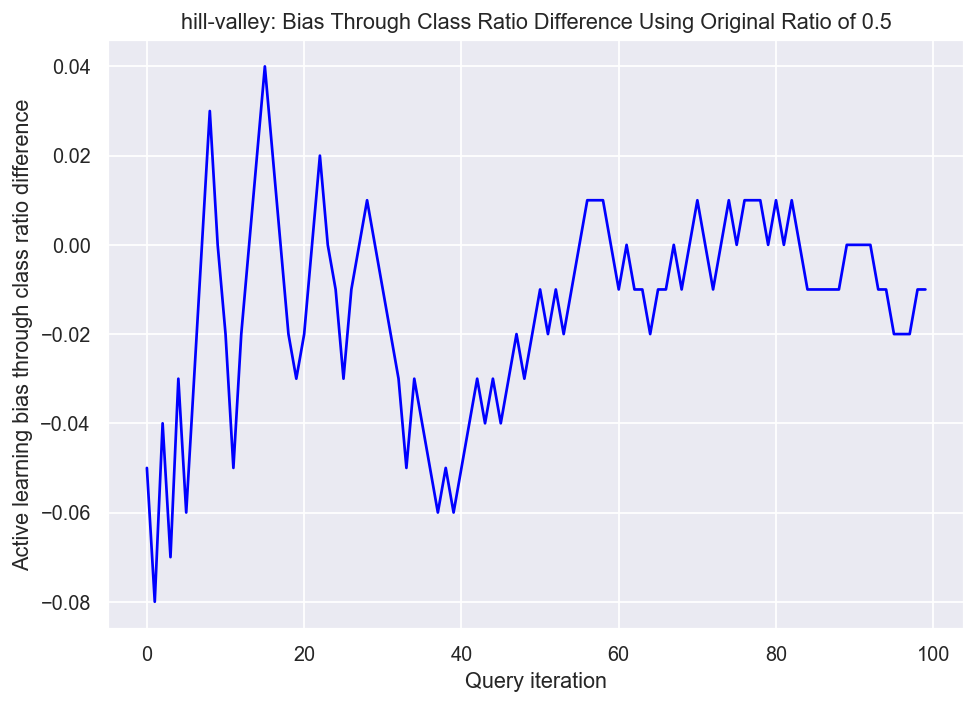

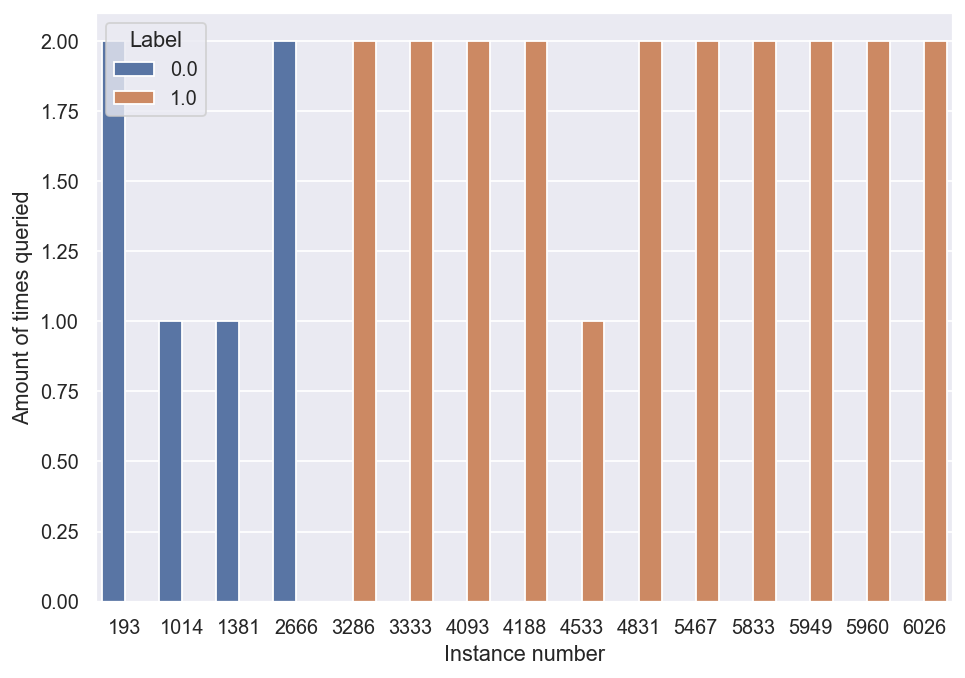

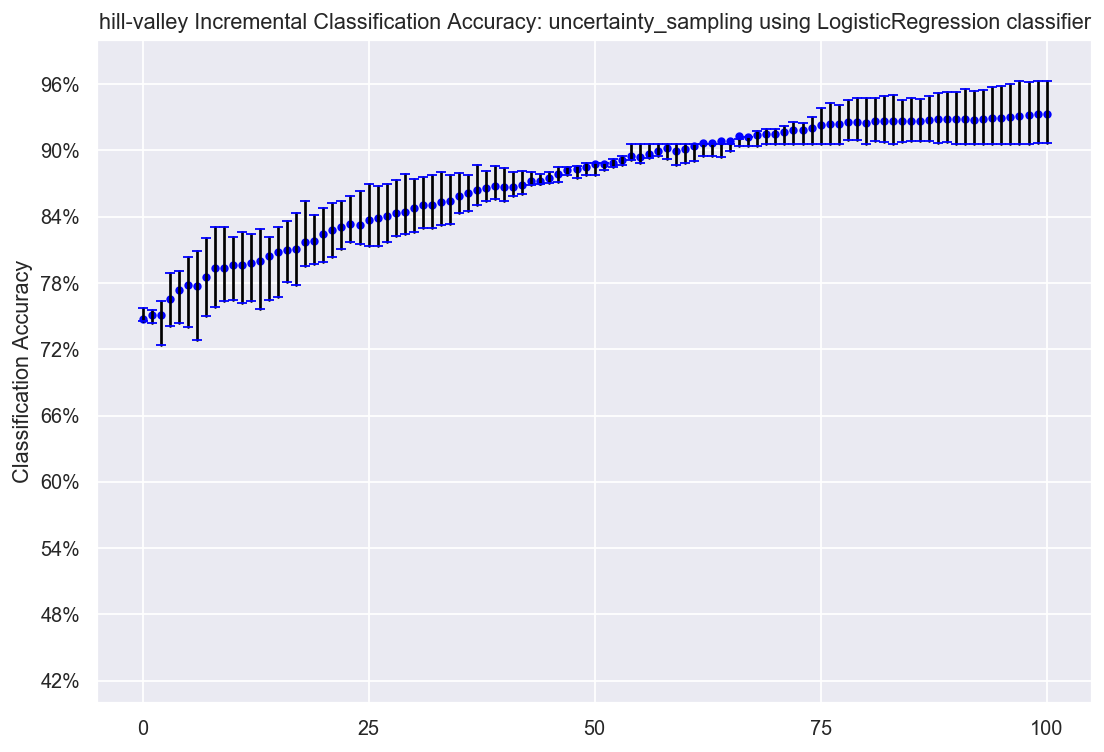

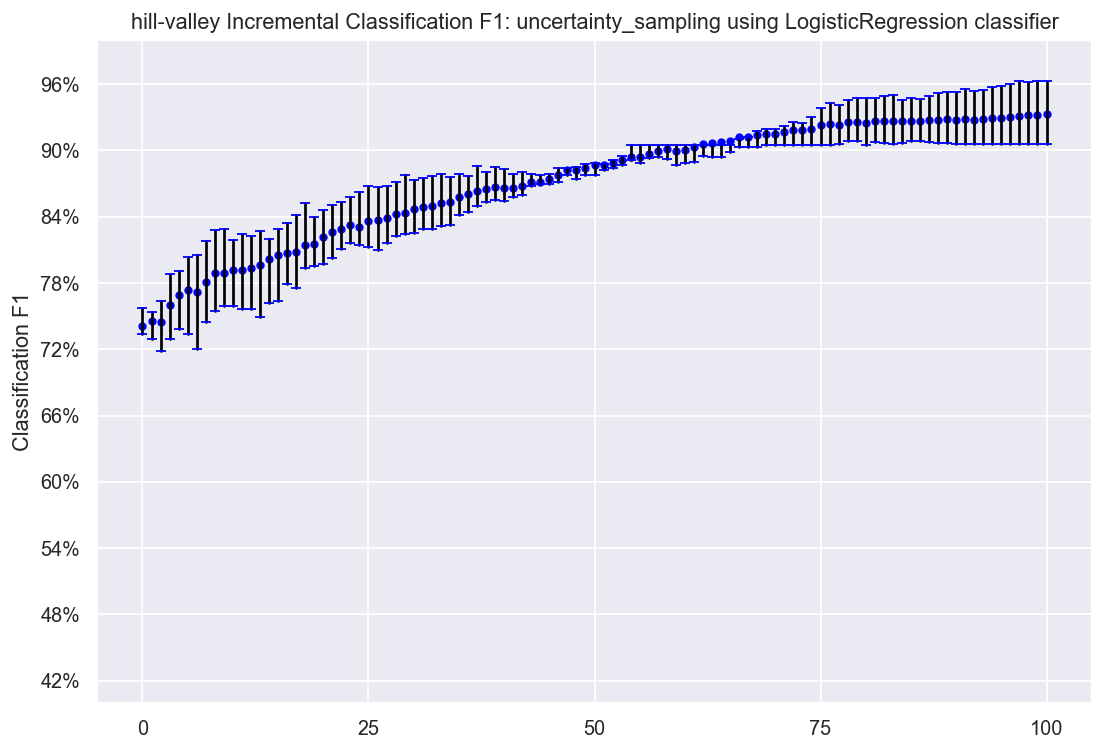

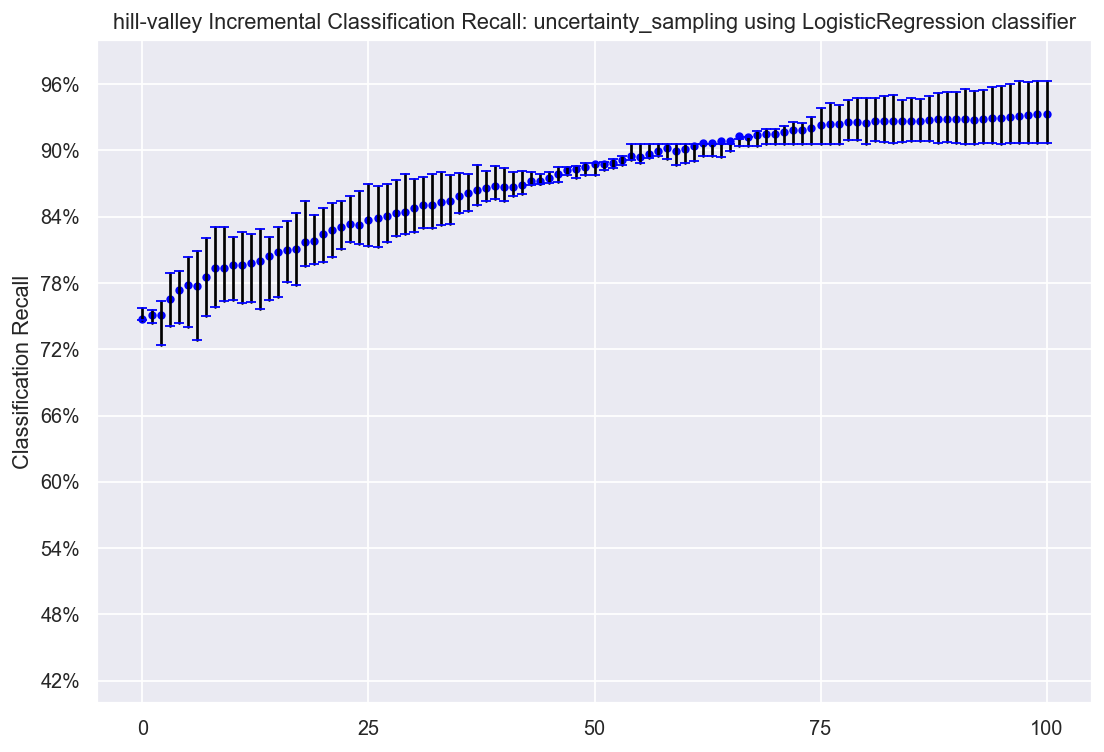

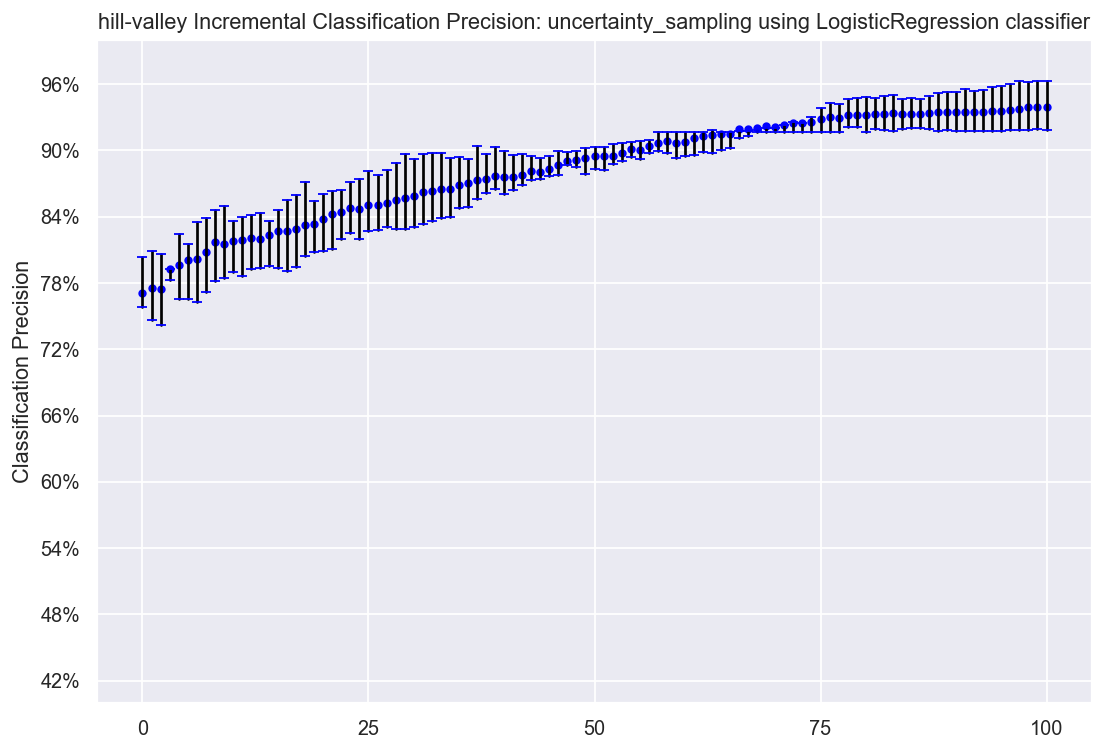

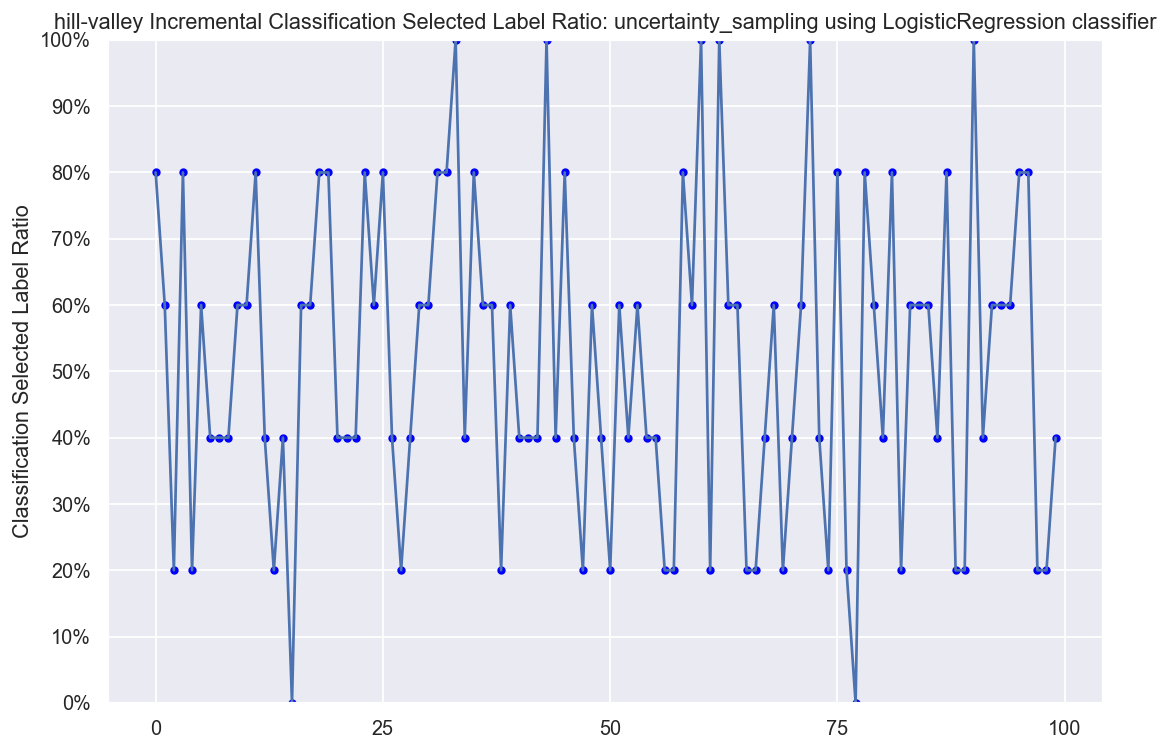

ALC is:  48.60686756494855


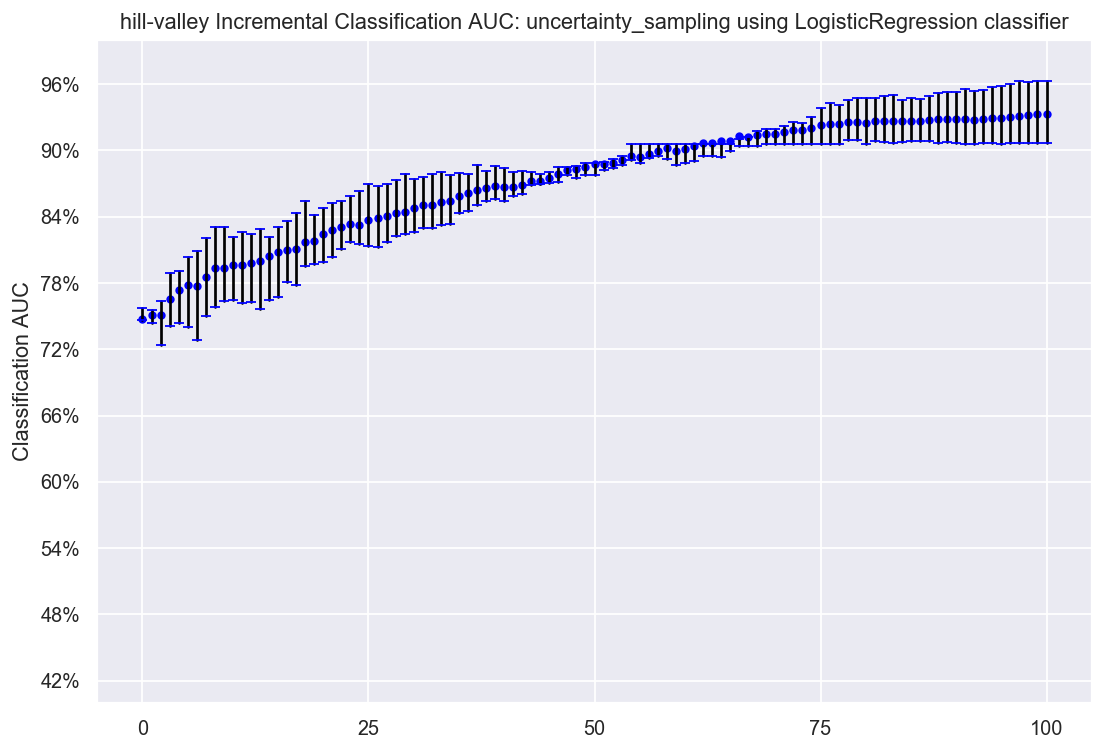

Evaluating on 75-25 class ratio data using uncertainty_sampling and the LogisticRegression classifier:


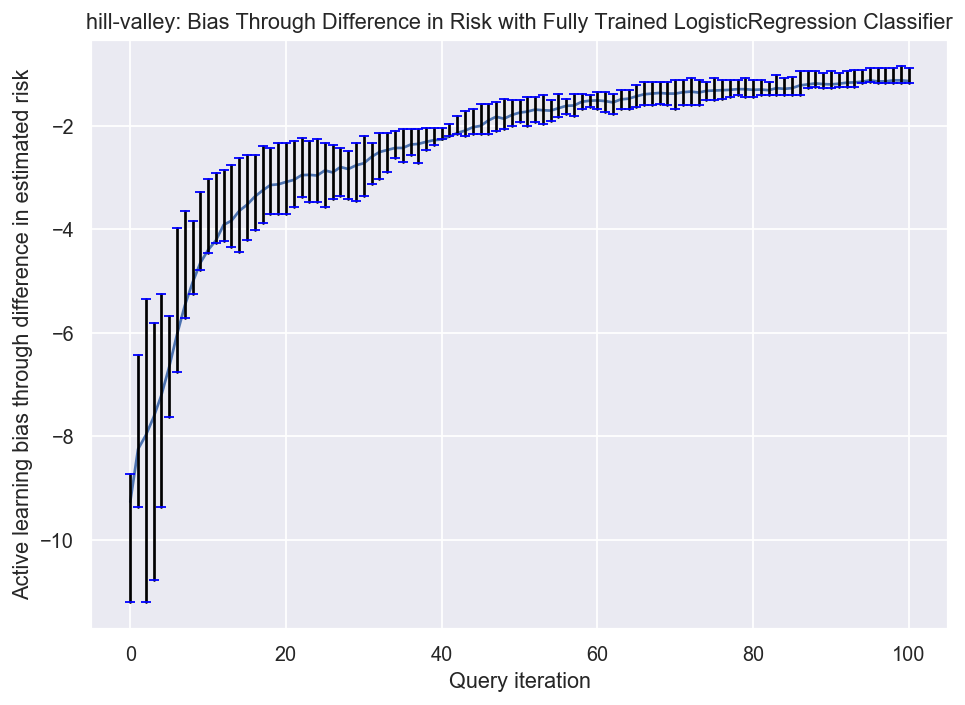

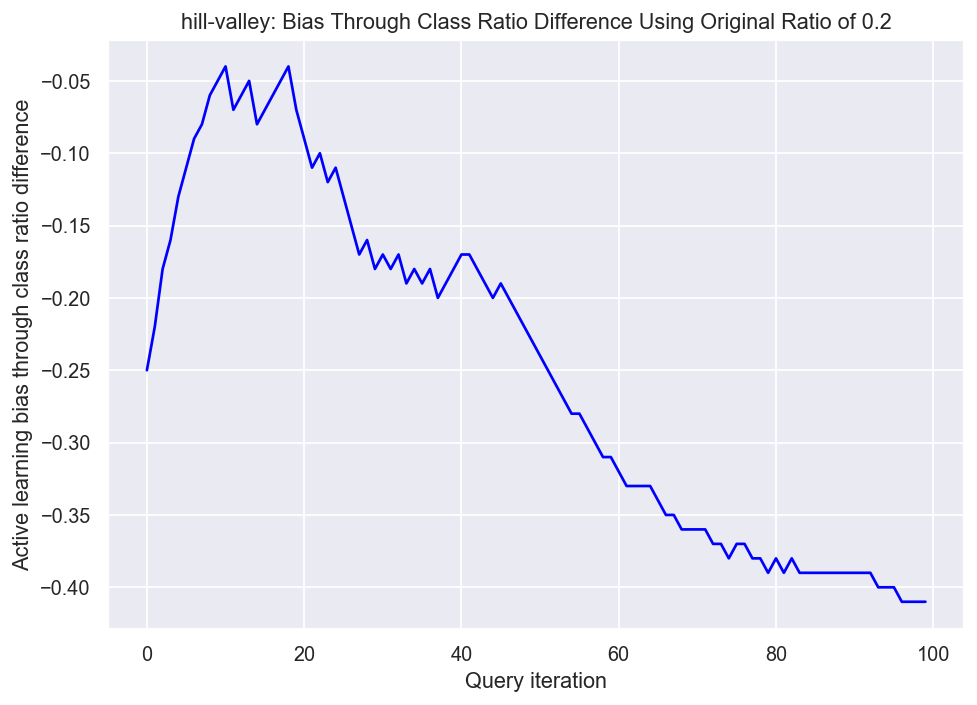

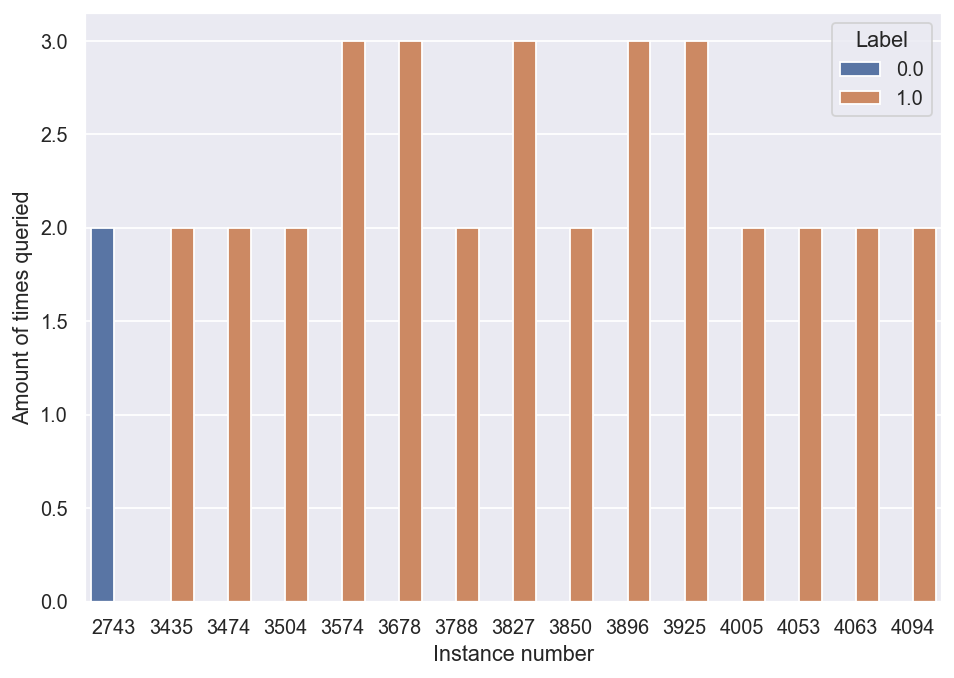

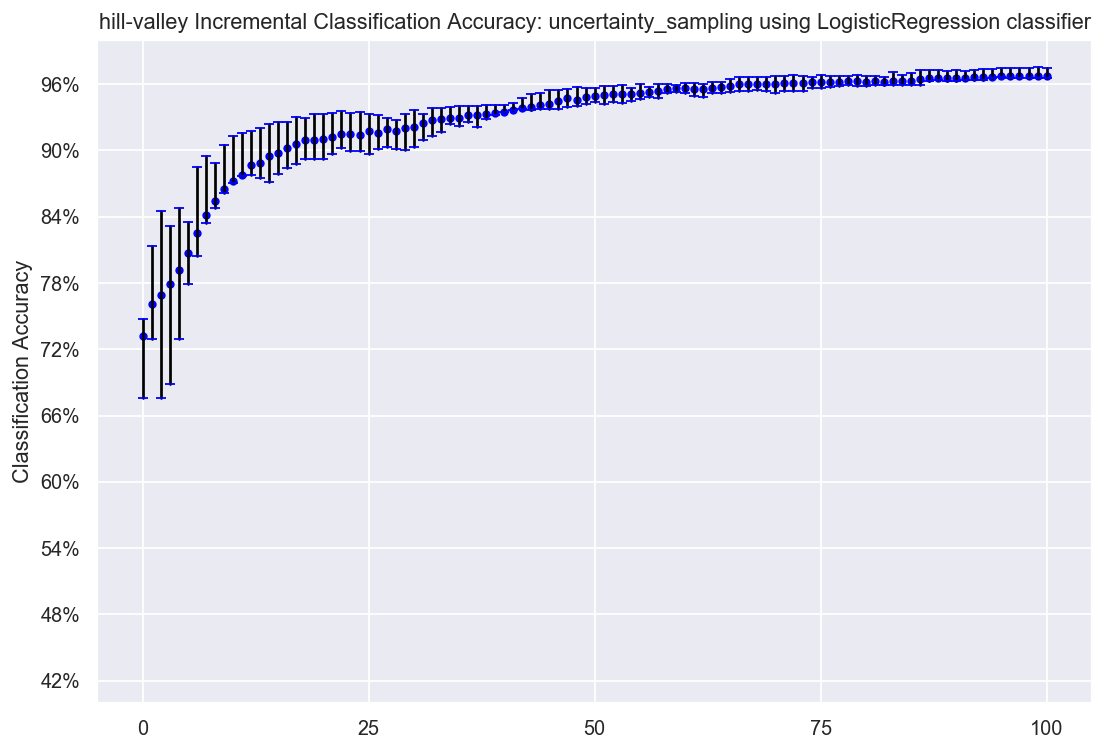

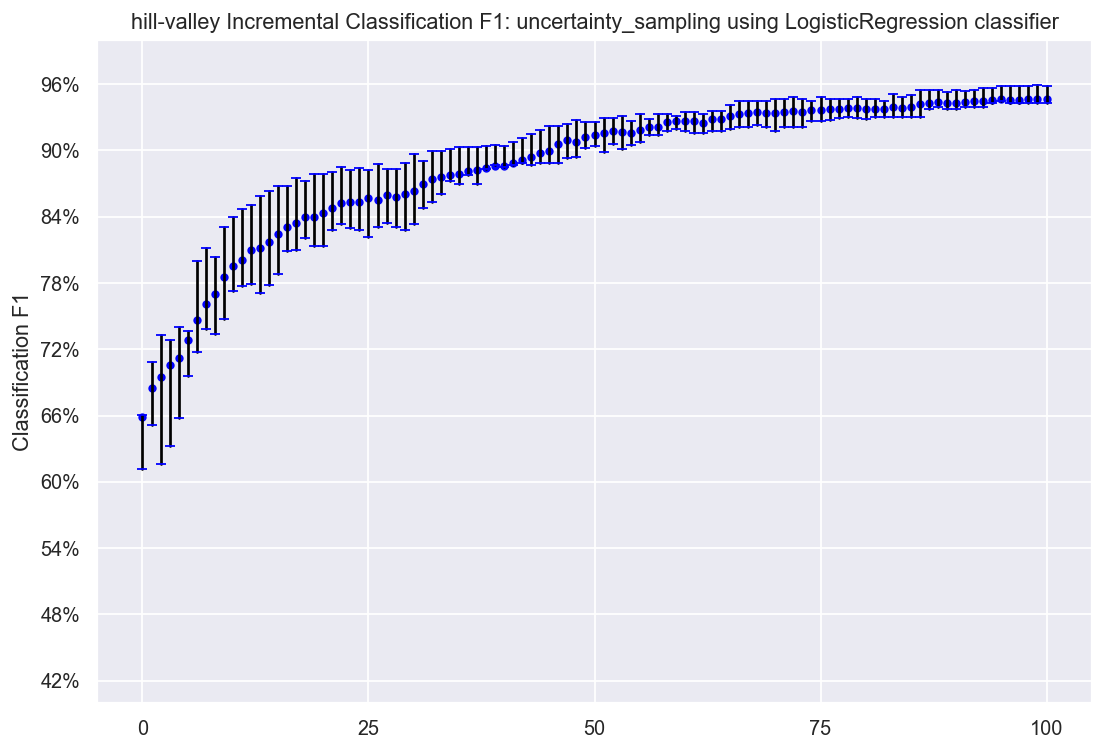

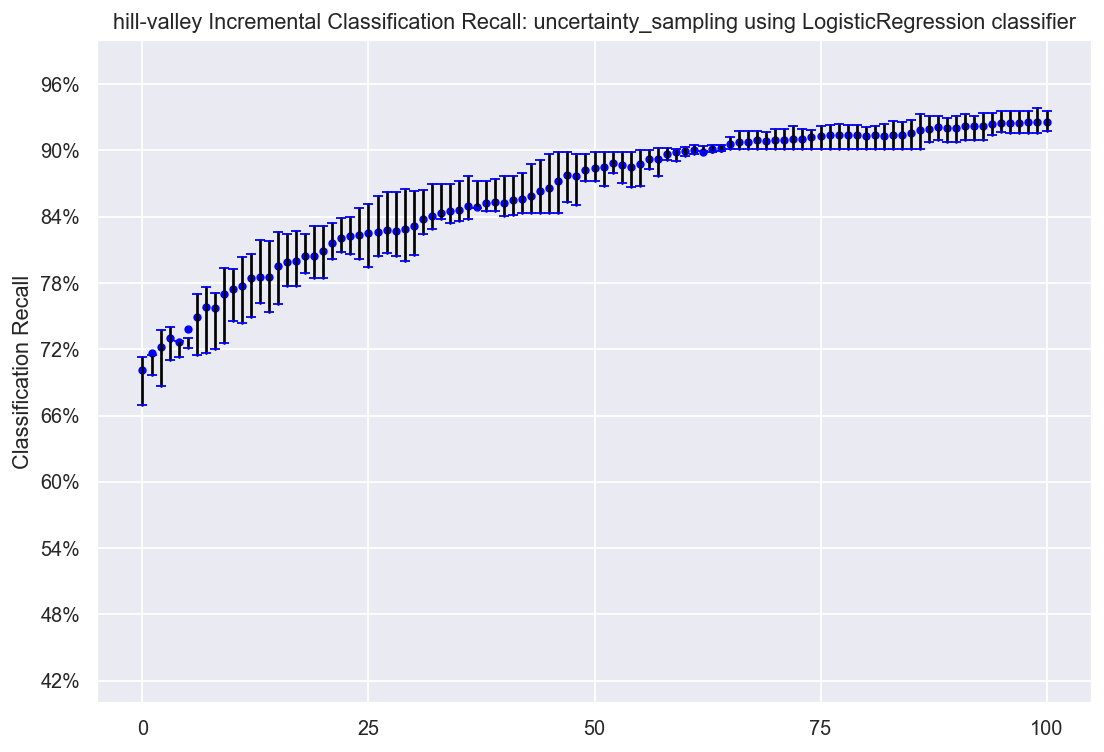

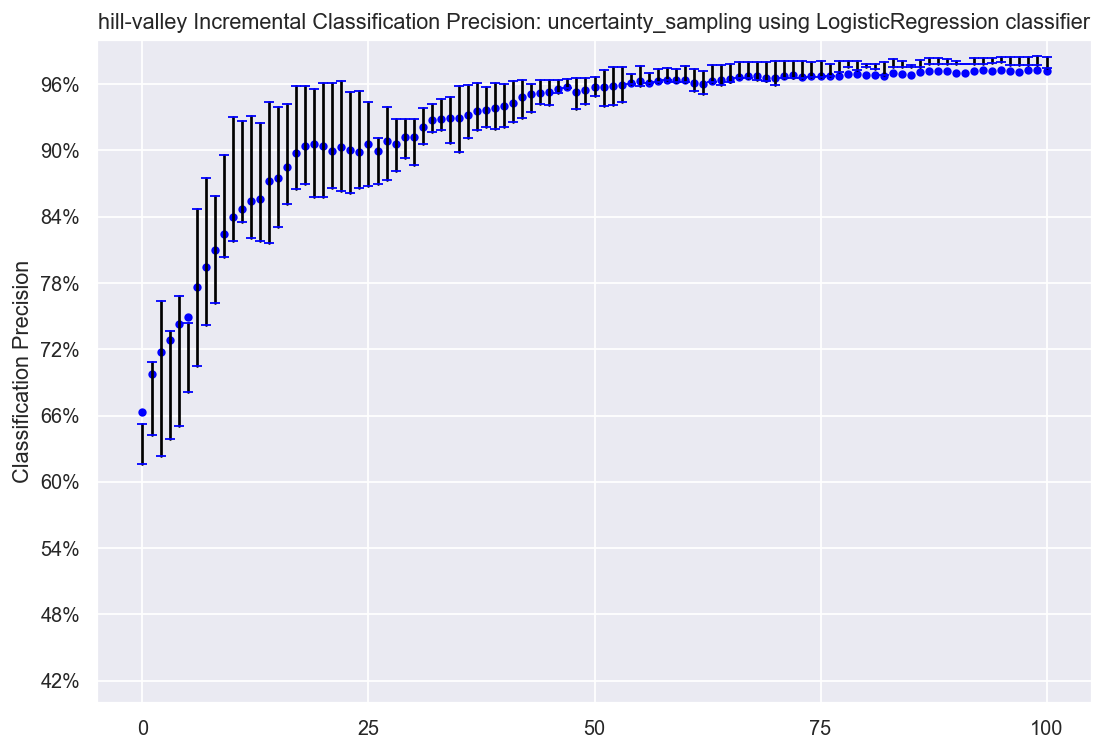

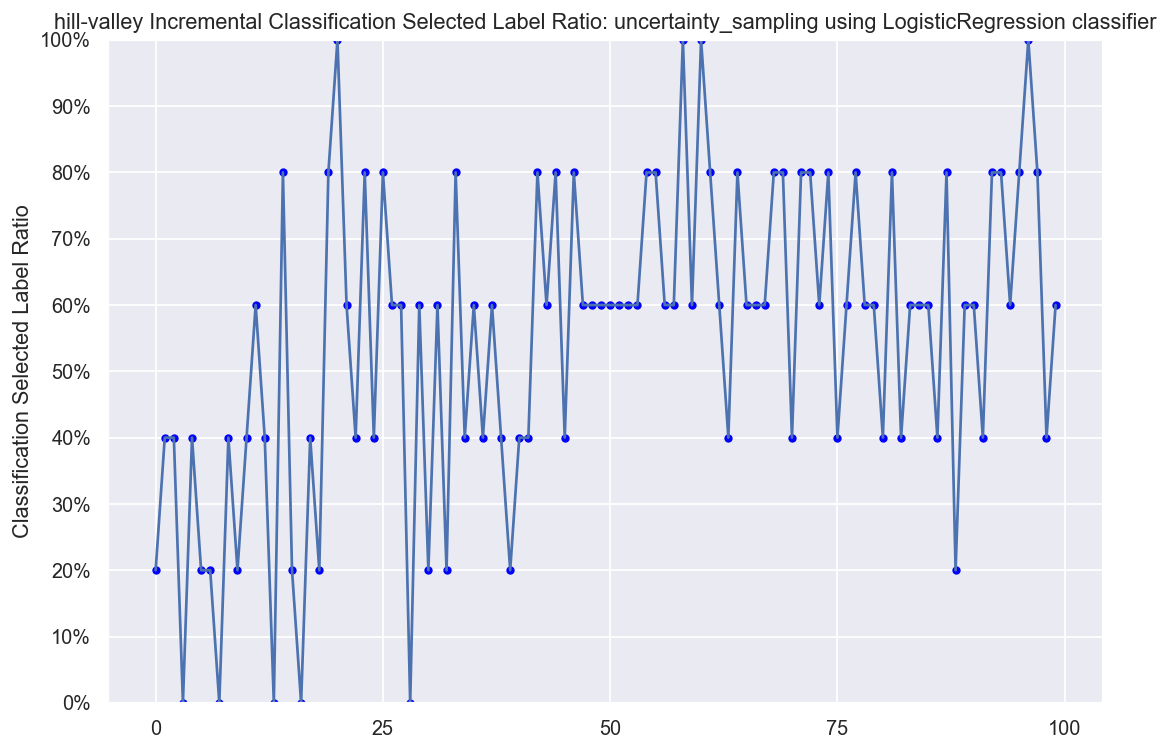

ALC is:  40.703772288194564


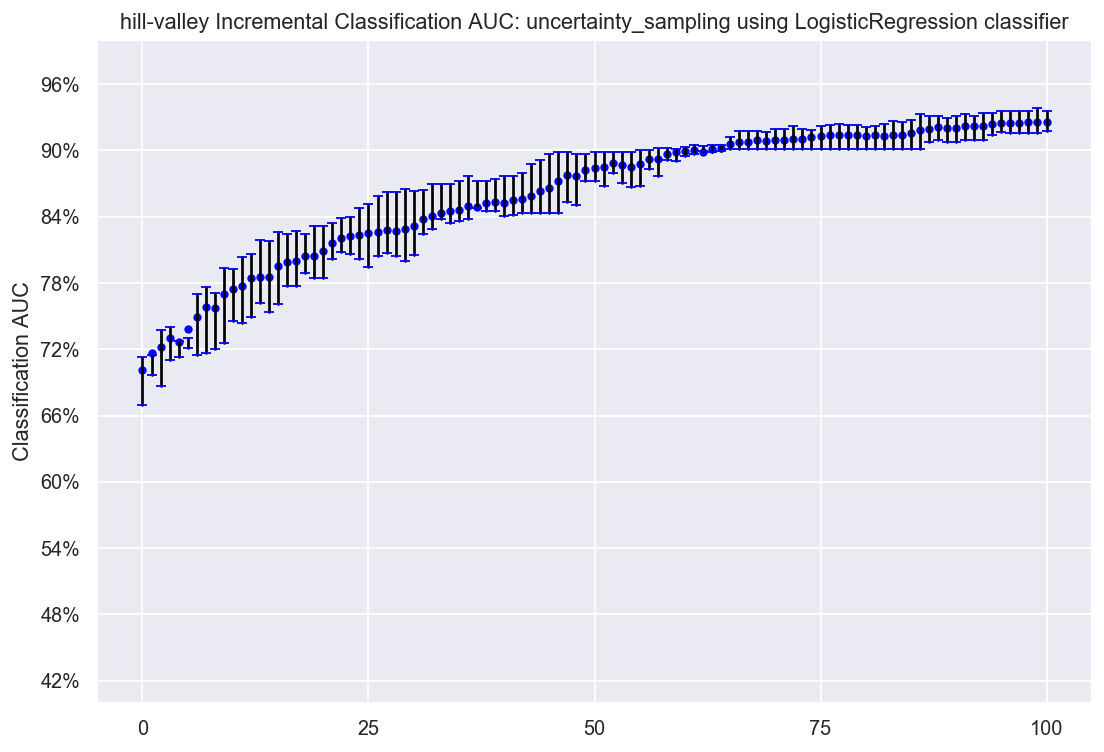

Evaluating on 95-5 class ratio data using uncertainty_sampling and the LogisticRegression classifier:


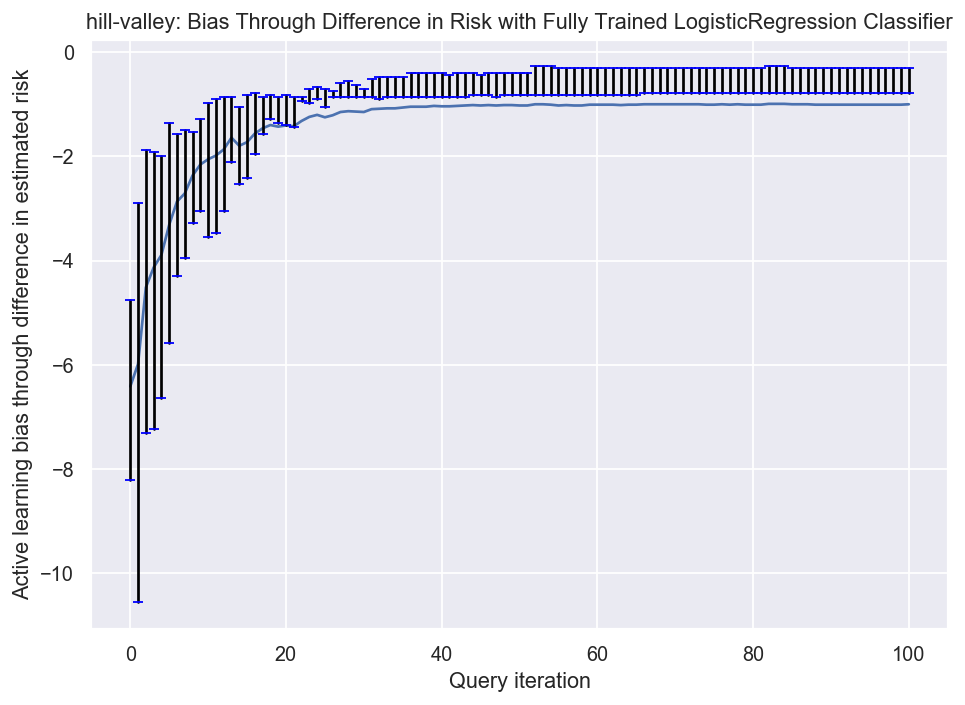

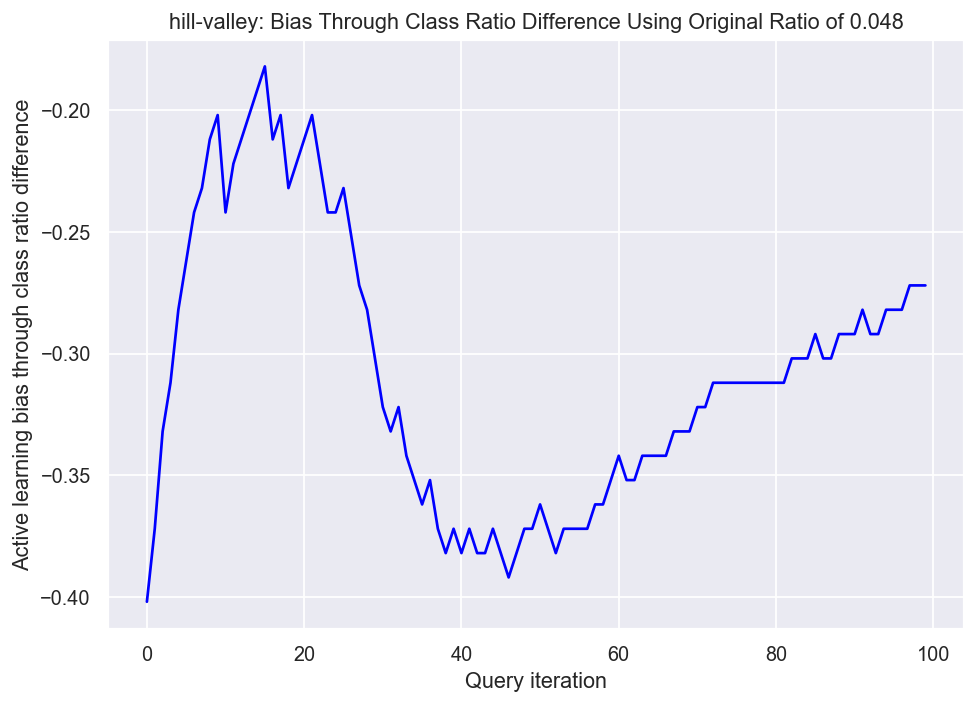

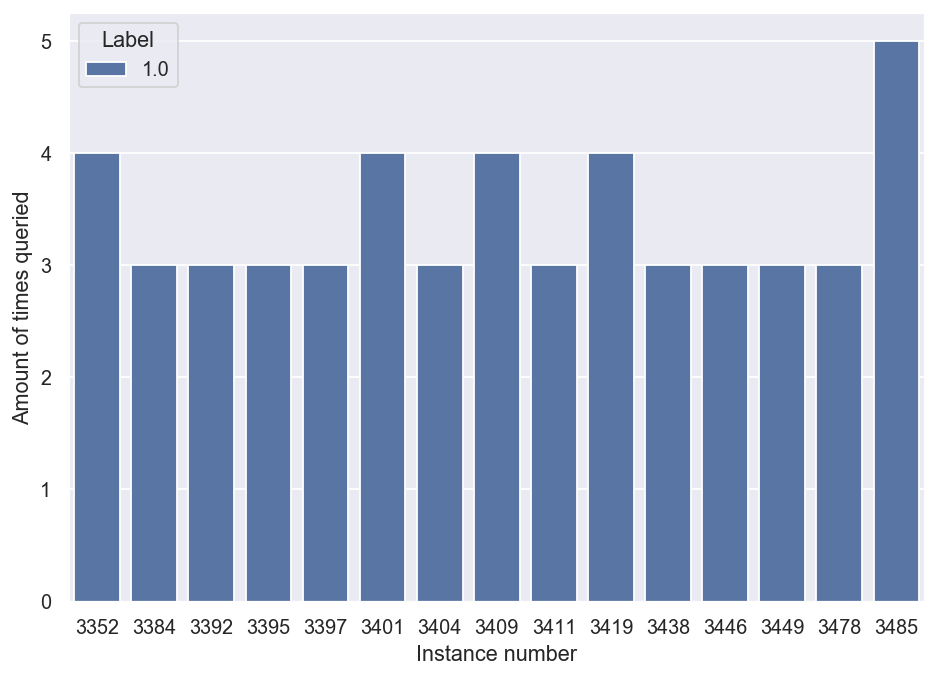

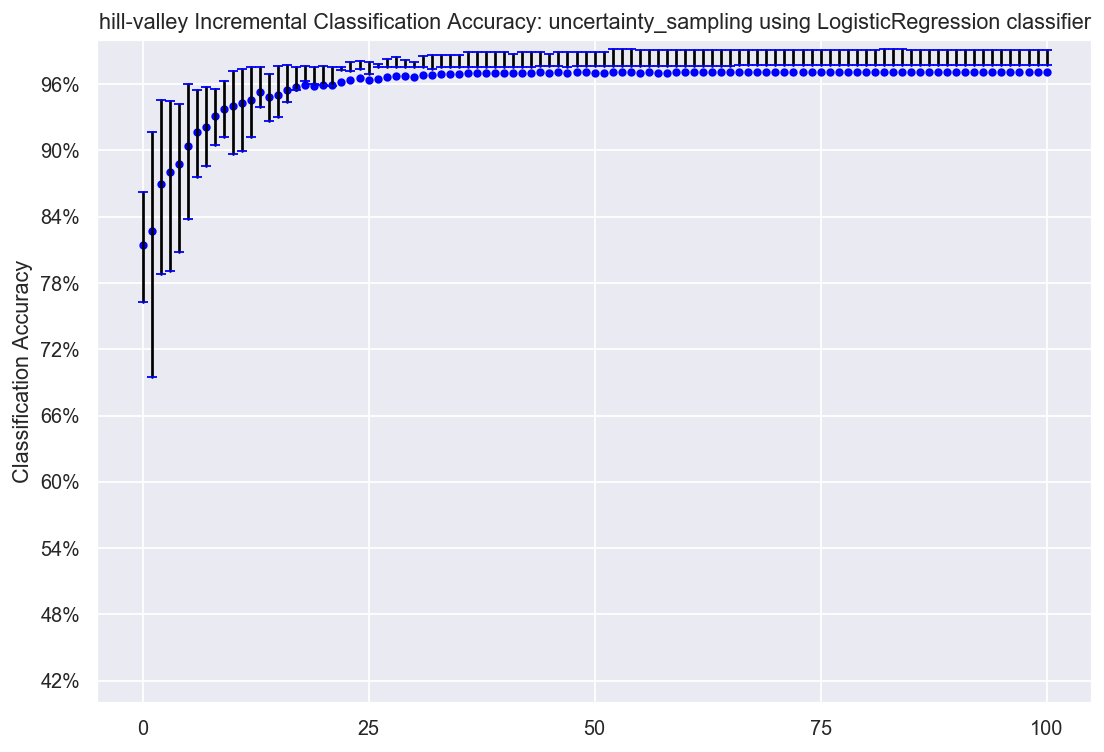

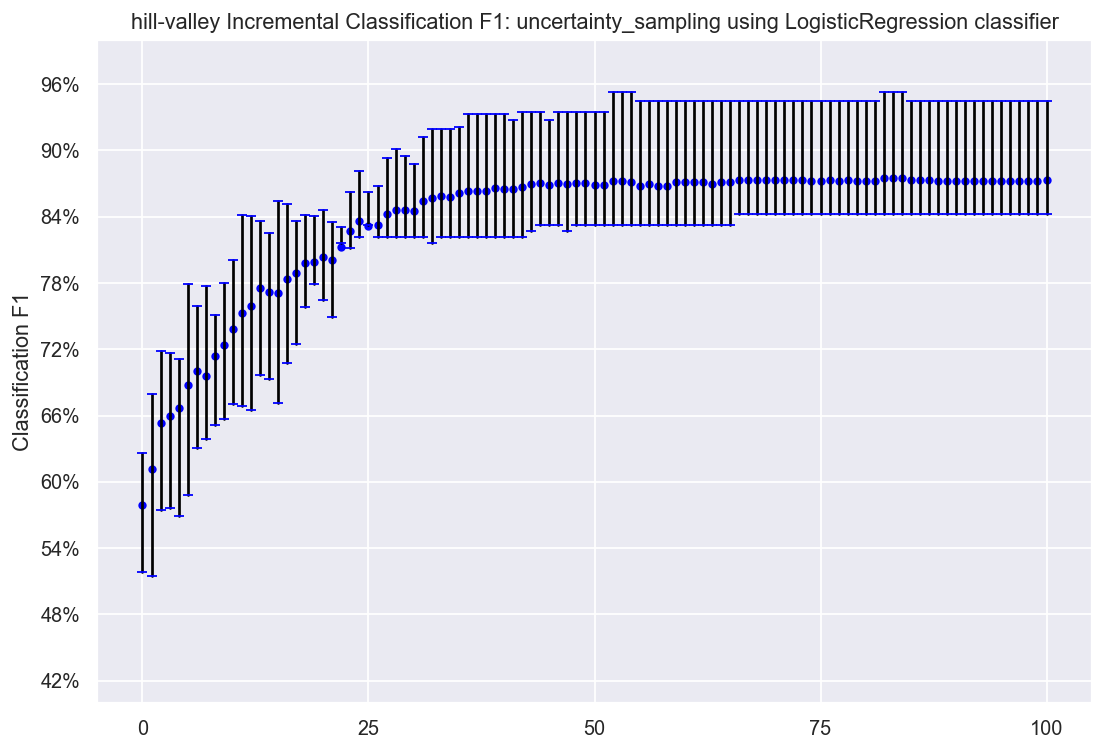

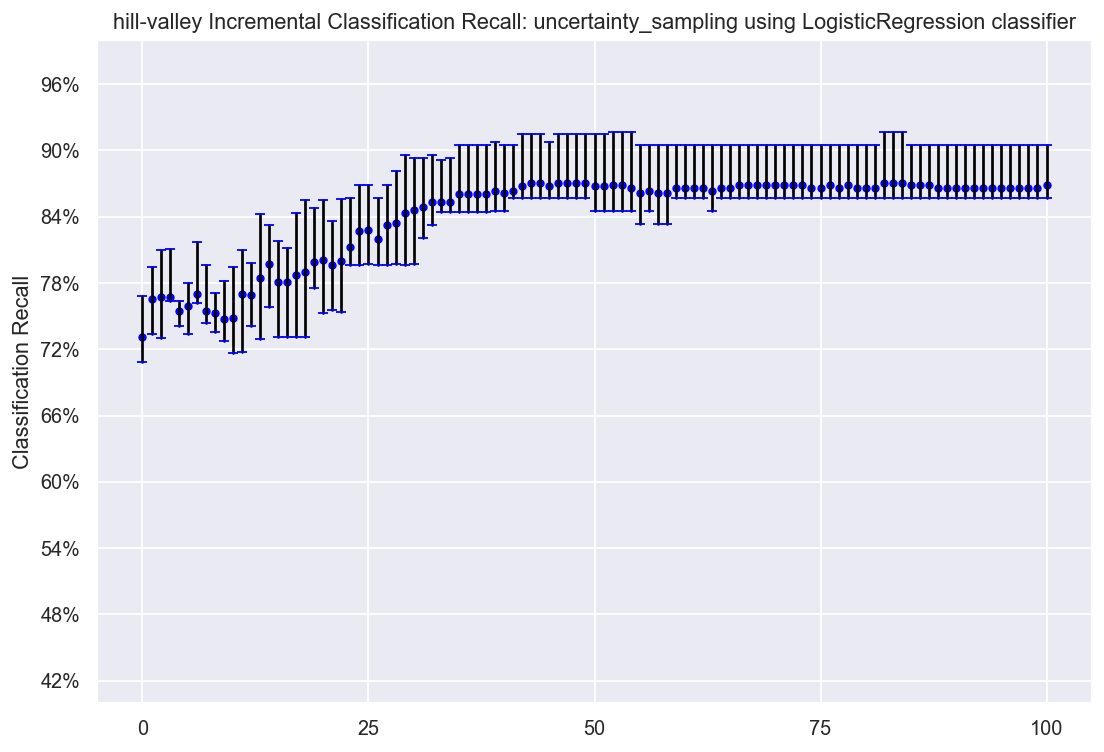

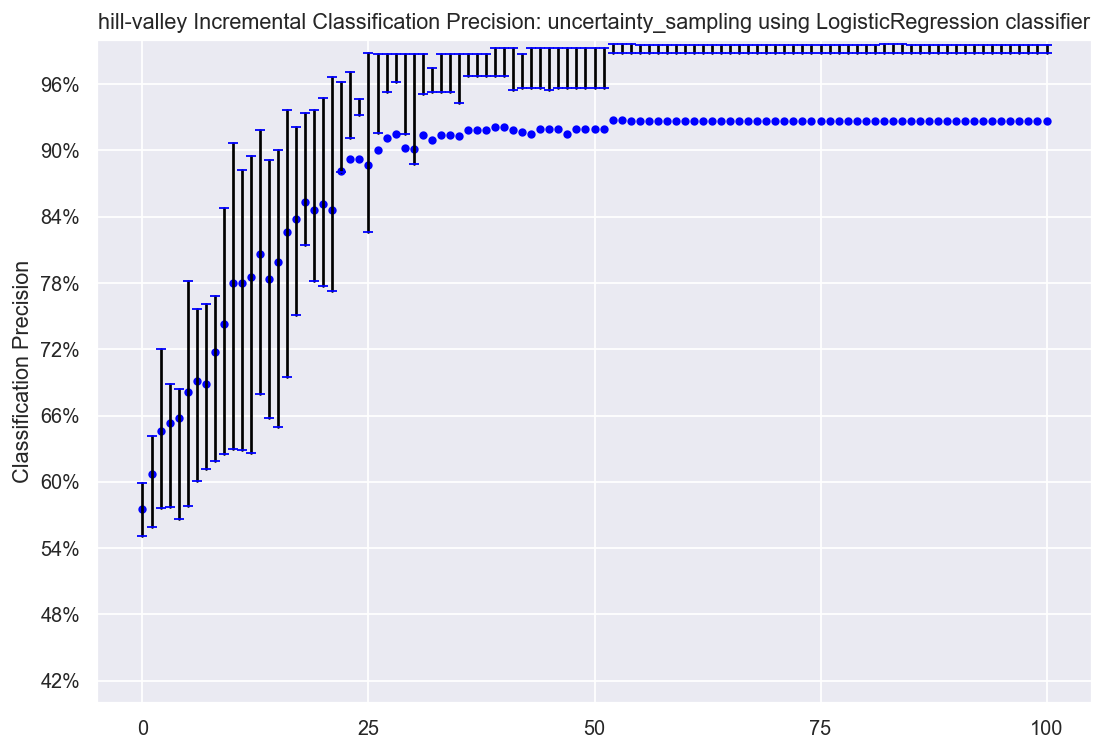

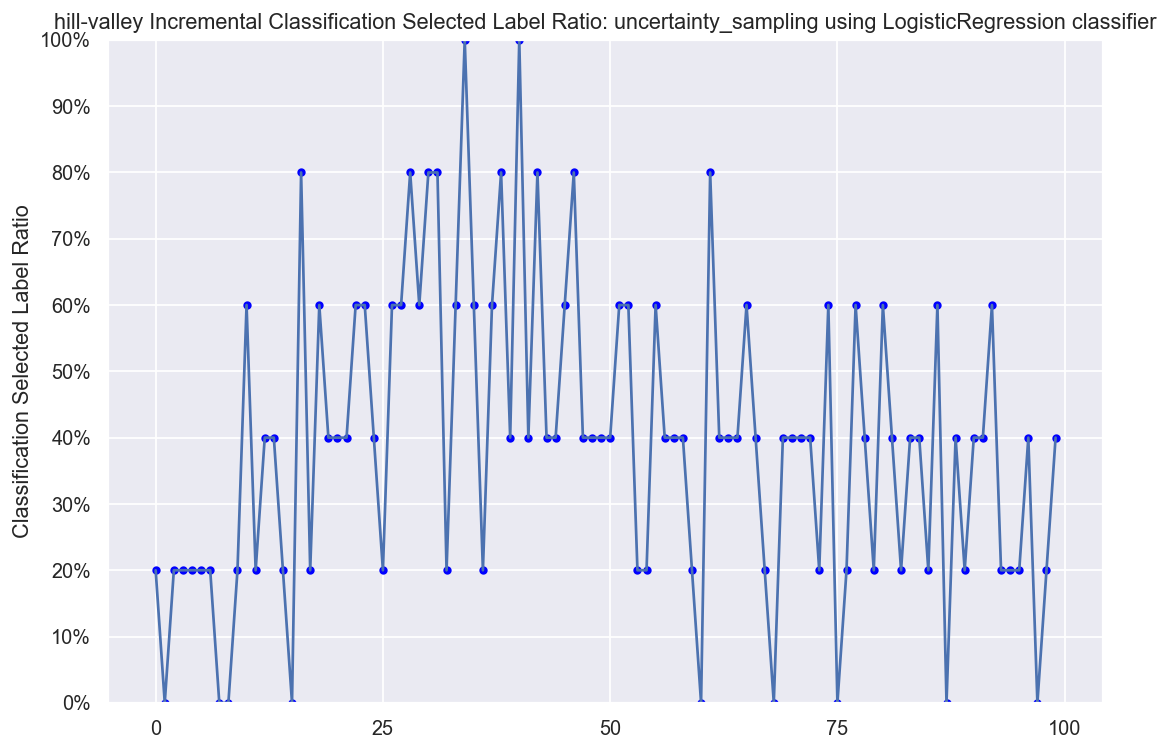

ALC is:  44.06964168145523


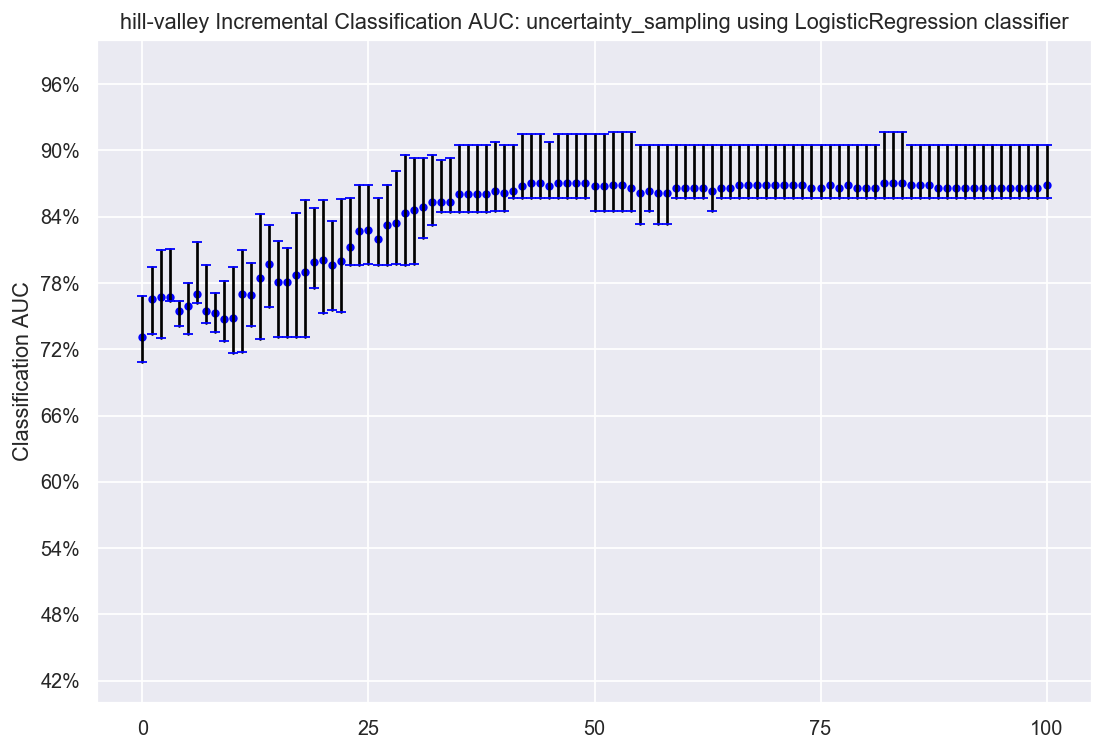

Aggregate Results:


TypeError: plot_results() missing 1 required positional argument: 'ml_method_'

<Figure size 432x288 with 0 Axes>

In [103]:
def run_openML_test_class_imbalance():
    performance_results = []
    n_queries = 100
    ml_method = 1
    al_method = 2

    aggregate_ci_results = {'Original':{'Accuracy':pd.DataFrame(columns = range(n_queries+1)),'F1':pd.DataFrame(columns = range(n_queries+1)), 'Recall':pd.DataFrame(columns = range(n_queries+1)), 'Precision':pd.DataFrame(columns = range(n_queries+1)), "Selected Label Ratio":pd.DataFrame(columns = range(n_queries)), "AUC":pd.DataFrame(columns = range(n_queries+1))},
                               'Balanced':{'Accuracy':pd.DataFrame(columns = range(n_queries+1)),'F1':pd.DataFrame(columns = range(n_queries+1)), 'Recall':pd.DataFrame(columns = range(n_queries+1)), 'Precision':pd.DataFrame(columns = range(n_queries+1)), "Selected Label Ratio":pd.DataFrame(columns = range(n_queries)), "AUC":pd.DataFrame(columns = range(n_queries+1))},
                               '75-25':{'Accuracy':pd.DataFrame(columns = range(n_queries+1)),'F1':pd.DataFrame(columns =range(n_queries+1)), 'Recall':pd.DataFrame(columns = range(n_queries+1)), 'Precision':pd.DataFrame(columns = range(n_queries+1)), "Selected Label Ratio":pd.DataFrame(columns = range(n_queries)), "AUC":pd.DataFrame(columns = range(n_queries+1))},
                               '95-5':{'Accuracy':pd.DataFrame(columns = range(n_queries+1)),'F1':pd.DataFrame(columns = range(n_queries+1)), 'Recall':pd.DataFrame(columns = range(n_queries+1)), 'Precision':pd.DataFrame(columns = range(n_queries+1)), "Selected Label Ratio":pd.DataFrame(columns = range(n_queries)), "AUC":pd.DataFrame(columns = range(n_queries+1))}}
    for idx, dataset_name in enumerate(dataset_list):
        dataset = openml.datasets.get_dataset(dataset_name)
        print('Running experiments on', dataset.name)
        X_df, y_df, X, y, number_majority, number_minority = preprocess_openML_dataset(dataset)
        X_list, y_list = create_openML_subsamples(X, y)
        X_train, X_test, y_train, y_test, ML_results_fully_trained, ML_results_subsample_trained, ML_results_subsample_trained_biased = evaluate_all_models(X,y, X_list, y_list)
        #run_experiments_openML_dataset(X_train, y_train, X_list=X_list,y_list=y_list)
        dataset_results = ci_run_single_dataset(X_list, y_list, al_method, ml_method, X_df, ML_results_fully_trained)
        for experiment_type, experiment_results in dataset_results.items():
            for performance_metric, performance in dataset_results[experiment_type].items():
                aggregate_ci_results[experiment_type][performance_metric] = aggregate_ci_results[experiment_type][performance_metric].append(performance, ignore_index=True)


    #for 
    #    plot_aggregate_graphs()
    plot_aggregate_results('Class_Imbalance', aggregate_ci_results)
    plot_aggregate_comparison('Class_Imbalance', aggregate_ci_results)

run_openML_test_class_imbalance()

In [ ]:
# Plot frequency selection heatmap from given dataframe. The matrix is the dataframe containing the frequencies for all trajectories
# The threshold gives the minimum frequency required for a trajectory to be included in the heatmap. Bin size defines the size of bins in the heatmap.
# The name is the name of the file given to the produced file, typically being similar to the name of the file from which the frequencies were taken.
# Target ids is the list of trajectory ids for positive instances, which allows identification of which trajectories are positive or negative.
def plot_heatmap(matrix_, threshold, bin_size, name, target_ids: np.array):
    # Remove trips from matrix for which, at no time point, they have been selected at least threshold amount of times
    matrix_ = matrix_.loc[:, (matrix_ >= threshold).any(axis=0)]
    print(matrix_)
    # Could divide numbers by total number of runs (executions+folds(-1?) to get better scaled numbers
    # Might not be necessary, considering this is mostly used for finding interesting cases for one method at a time.

    # Divide the remaining frequencies into bins
    matrix = matrix_.T
    matrix = matrix.groupby([[i//bin_size for i in range(0,matrix.shape[1])]], axis = 1).sum()
    matrix.columns = [str(i*bin_size + 1) + "-" + str(i*bin_size+bin_size) for i in range(0,int(matrix.shape[1]))]
    matrix = matrix.T
    
    x_axis_labels = matrix_.columns # labels for x-axis
    y_axis_labels = matrix.columns  # labels for y-axis
    
    plt.figure(figsize=(0.6*matrix.shape[1],0.6*matrix.shape[0]))
    ax = plt.axes()
    ax.set_title('Instance Selection Frequencies',fontsize=14, fontweight='bold')

    ax.xticklabels = x_axis_labels
    ax.yticklabels = y_axis_labels
    
    sn.heatmap(matrix, annot=False, cmap="Reds", fmt='g', ax=ax, square = False)
    ax.invert_yaxis()
    
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    # Make all positive labels green, and negative labels red
    for lab in ax.get_xticklabels():
        text =  lab.get_text()
        if text in str(target_ids):
            lab.set_color('green')
        else:
            lab.set_color('red')

    plt.savefig("../Figures/" + name + "_heat.png", bbox_inches='tight')
    plt.show()

# Test example
# confusion_matrix = np.array([[41792,67554,19872,99459],[ 24901,11070,23452,15790],[20190,24793,34254,10582],[90190,24793,34254,20582]])
# confusion_matrix = pd.DataFrame(confusion_matrix, columns = ['trip1', 'trip2', 'trip3', 'trip4'])

# plot_heatmap(confusion_matrix, threshold = 1, bin_size = 2, name = "Test_case", target_ids = [])

In [ ]:
#'density_sampling_WF0_same_sum_maj_100__new_freq', 
result_strings = ['density_sampling_WF0_same_sum_maj_100__new_freq', 'uncertainty_sampling_spambase, class ratio 1,n_queries 100 _freq']
thresholds = [2,2]
for i, string in enumerate(result_strings):
    traj_freq_matrix = pd.read_pickle("../Results/" + string + ".pkl")
    #print(traj_freq_matrix)
    plot_heatmap(traj_freq_matrix, threshold = thresholds[i], bin_size = 2, name = string, target_ids = [])



In [ ]:
from timeit import default_timer as timer

# To run on CPU
def func(a):
    for i in range(10000000):
        a[i]+= 1
# To run on GPU
@jit
def func2(x):
    return x+1

n = 10000000
a = np.ones(n, dtype = np.float64)
start = timer()
func(a)
print("without GPU:", timer()-start)
start = timer()
func2(a)
numba.cuda.profile_stop()
print("with GPU:", timer()-start)
